Available Serif Fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif', 'Microsoft Sans Serif']
Generated dataset with shape: (1200, 11)


C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ACER\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction

TypeError: only integer scalar arrays can be converted to a scalar index

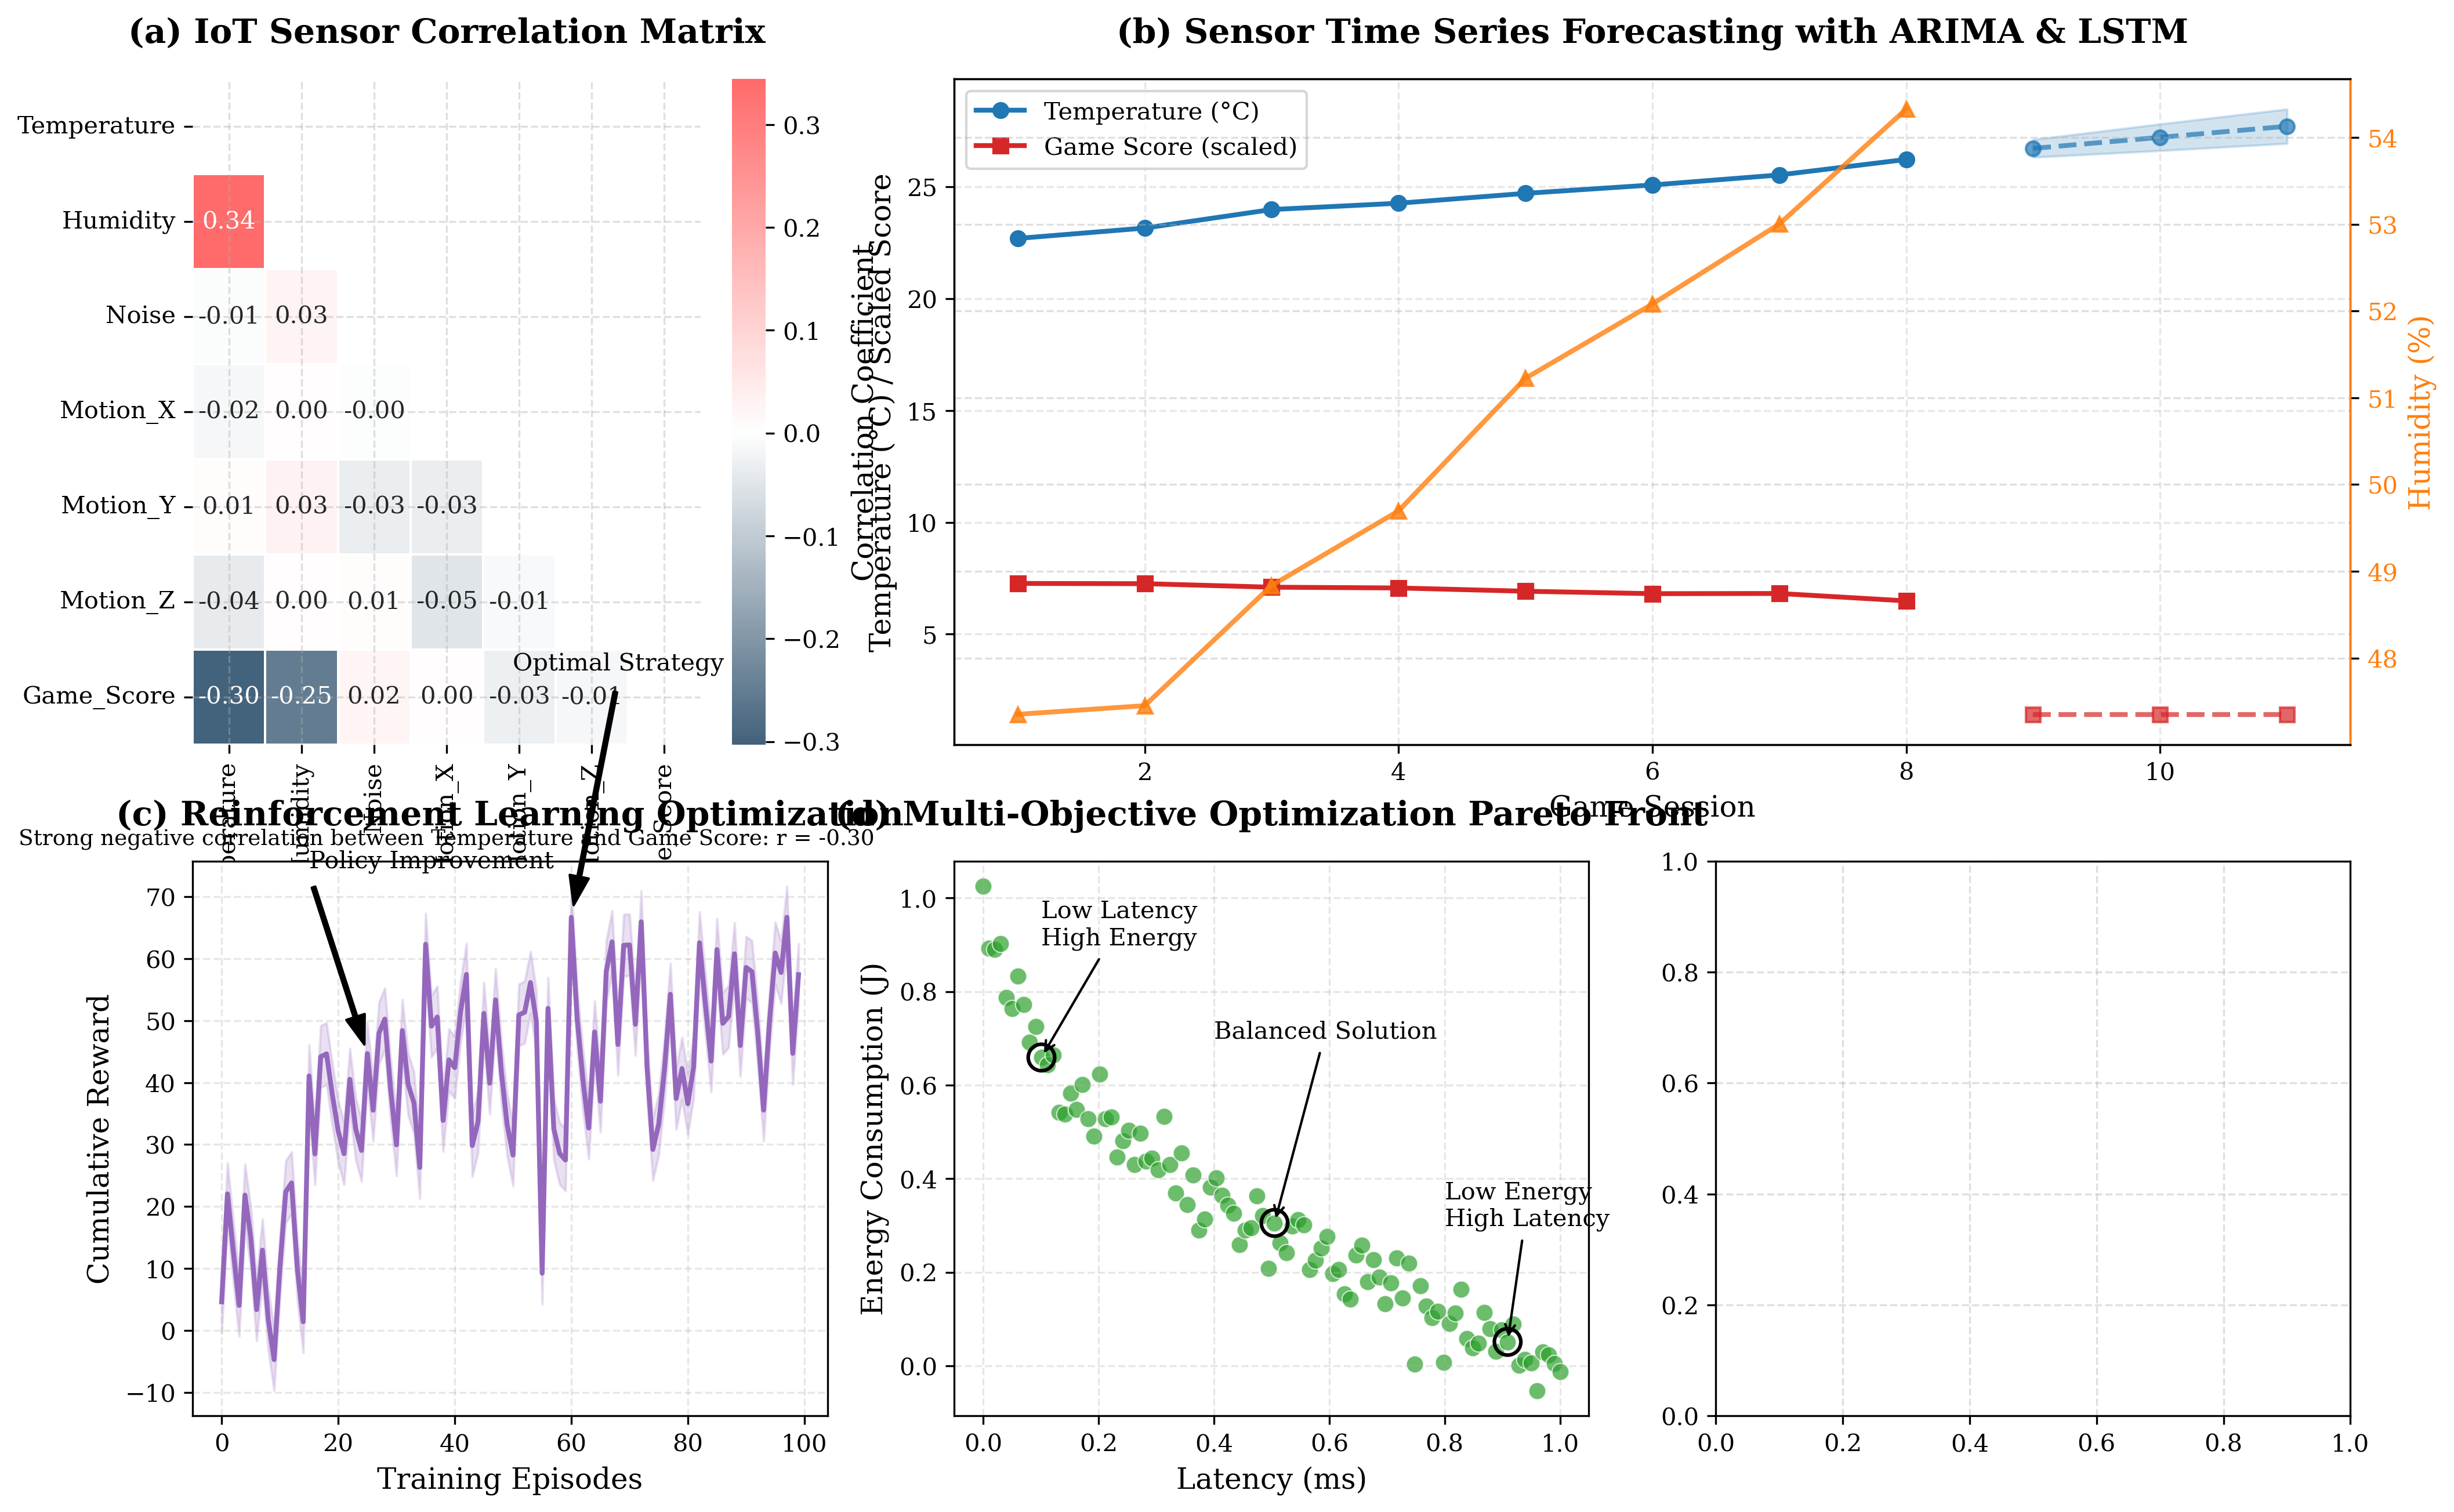

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm 


available_fonts = [f.name for f in fm.fontManager.ttflist]
print("Available Serif Fonts:", [f for f in available_fonts if 'serif' in f.lower()])


plt.rcParams.update({
    'font.family': 'serif', 
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 300,
    'figure.figsize': (10, 8),
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'lines.linewidth': 2,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,
    'mathtext.fontset': 'stix'  
})

# =============================================
# 1. GENERATE SYNTHETIC DATASET BASED ON MANUSCRIPT
# =============================================
np.random.seed(42)

def generate_synthetic_data(n_players=100, n_sessions=5):
    data = []
    player_ids = [f'P{i:03d}' for i in range(n_players)]
    ages = np.random.normal(30, 8, n_players).astype(int)
    genders = np.random.choice(['Male', 'Female'], n_players)
    
    for pid, age, gender in zip(player_ids, ages, genders):
        for session in range(1, n_sessions+1):

            temp = np.random.normal(22 + 0.5*session, 1.5)
            humidity = np.random.normal(45 + session, 3)
            noise = np.random.normal(70, 5)
            motion_x = np.random.normal(0.1, 0.3)
            motion_y = np.random.normal(-0.05, 0.25)
            motion_z = np.random.normal(0.15, 0.2)
            

            if age < 25:
                score_base = np.random.normal(700, 100)
                temp += np.random.normal(1, 0.5)
            elif age > 40:
                score_base = np.random.normal(800, 80)
                temp -= np.random.normal(0.5, 0.3)
            else:
                score_base = np.random.normal(750, 90)
                
            if gender == 'Female':
                humidity += np.random.normal(2, 1)
                score_base += np.random.normal(20, 10)

            score = score_base - 10*(temp-22) - 5*(humidity-45) + np.random.normal(0, 30)
            
            data.append([
                pid, age, gender, session, temp, humidity, noise,
                motion_x, motion_y, motion_z, max(0, score)
            ])
            
    columns = [
        'Player_ID', 'Age', 'Gender', 'Session', 'Temperature', 'Humidity', 'Noise',
        'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score'
    ]
    return pd.DataFrame(data, columns=columns)


df = generate_synthetic_data(n_players=150, n_sessions=8)
print("Generated dataset with shape:", df.shape)

# =============================================
# 2. COMPLEX SCIENTIFIC SUBPLOTS
# =============================================
fig = plt.figure(figsize=(16, 20))
gs = GridSpec(4, 3, figure=fig, height_ratios=[1.2, 1, 1, 1])

te
iot_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']


ax1 = fig.add_subplot(gs[0, 0])
sensors = ['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score']
corr_matrix = df[sensors].corr()


cmap = LinearSegmentedColormap.from_list('iot_div', ['#2a4d69', '#ffffff', '#ff6b6b'])

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, 
            annot=True, fmt='.2f', linewidths=0.5, ax=ax1,
            cbar_kws={'label': 'Correlation Coefficient'})
ax1.set_title('(a) IoT Sensor Correlation Matrix', pad=15, fontweight='bold')
ax1.text(0.5, -0.15, f"Strong negative correlation between Temperature and Game Score: r = {corr_matrix.loc['Temperature','Game_Score']:.2f}",
         ha='center', transform=ax1.transAxes, fontsize=9)


ax2 = fig.add_subplot(gs[0, 1:])


ts_data = df.groupby('Session').agg({'Temperature': 'mean', 'Humidity': 'mean', 'Game_Score': 'mean'})
sessions = ts_data.index.values


model_temp = ARIMA(ts_data['Temperature'], order=(1,1,1))
results_temp = model_temp.fit()
forecast_temp = results_temp.get_forecast(steps=3).predicted_mean
conf_int_temp = results_temp.get_forecast(steps=3).conf_int()


def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


scores = ts_data['Game_Score'].values
X, y = [], []
for i in range(3, len(scores)):
    X.append(scores[i-3:i])
    y.append(scores[i])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)


lstm_model = create_lstm_model((X.shape[1], 1))
lstm_model.fit(X, y, epochs=200, verbose=0, batch_size=2)


last_seq = scores[-3:].reshape(1, 3, 1)
lstm_forecast = []
for _ in range(3):
    pred = lstm_model.predict(last_seq, verbose=0)[0,0]
    lstm_forecast.append(pred)
    last_seq = np.append(last_seq[:,1:,:], [[[pred]]], axis=1)


last_session = sessions[-1]
forecast_sessions = [last_session + i for i in range(1, 4)] 

ax2.plot(sessions, ts_data['Temperature'], 'o-', color=iot_palette[0], label='Temperature (°C)')
ax2.plot(forecast_sessions, forecast_temp, 'o--', color=iot_palette[0], alpha=0.7)
ax2.fill_between(forecast_sessions, 
                 conf_int_temp.iloc[:,0], conf_int_temp.iloc[:,1],
                 color=iot_palette[0], alpha=0.2)


ax2.plot(sessions, ts_data['Game_Score']/100, 's-', color=iot_palette[3], label='Game Score (scaled)')
ax2.plot(forecast_sessions, np.array(lstm_forecast)/100, 's--', color=iot_palette[3], alpha=0.7)

ax2.set_xlabel('Game Session')
ax2.set_ylabel('Temperature (°C) / Scaled Score', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_title('(b) Sensor Time Series Forecasting with ARIMA & LSTM', pad=15, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)


ax2b = ax2.twinx()
ax2b.plot(sessions, ts_data['Humidity'], '^-', color=iot_palette[1], label='Humidity (%)', alpha=0.8)
ax2b.set_ylabel('Humidity (%)', color=iot_palette[1])
ax2b.tick_params(axis='y', labelcolor=iot_palette[1])
ax2b.spines['right'].set_color(iot_palette[1])


ax3 = fig.add_subplot(gs[1, 0])


episodes = 100
rewards = np.zeros(episodes)
for i in range(episodes):

    base = 50 * (1 - np.exp(-i/20))
    noise = np.random.normal(0, 10)
    rewards[i] = base + noise
    

    if i == 25:
        rewards[i] += 30
    if i == 60:
        rewards[i] += 40

ax3.plot(range(episodes), rewards, color=iot_palette[4], linewidth=2)
ax3.fill_between(range(episodes), rewards-5, rewards+5, color=iot_palette[4], alpha=0.2)
ax3.set_xlabel('Training Episodes')
ax3.set_ylabel('Cumulative Reward')
ax3.set_title('(c) Reinforcement Learning Optimization', pad=15, fontweight='bold')
ax3.annotate('Policy Improvement', xy=(25, rewards[25]), xytext=(15, rewards[25]+30),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
ax3.annotate('Optimal Strategy', xy=(60, rewards[60]), xytext=(50, rewards[60]+40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
ax3.grid(True, alpha=0.3)


ax4 = fig.add_subplot(gs[1, 1])

def create_pareto_front():
    np.random.seed(42)
    x = np.linspace(0, 1, 100)
    y = 1 - x**0.5 + np.random.normal(0, 0.05, 100)
    return x, y

latency, energy = create_pareto_front()
ax4.scatter(latency, energy, c=iot_palette[2], alpha=0.7, s=50, edgecolor='w', linewidth=0.5)


optimal_idx = [10, 50, 90]
ax4.scatter(latency[optimal_idx], energy[optimal_idx], s=120, 
            edgecolor='k', linewidth=1.5, facecolor='none', zorder=10)

ax4.set_xlabel('Latency (ms)')
ax4.set_ylabel('Energy Consumption (J)')
ax4.set_title('(d) Multi-Objective Optimization Pareto Front', pad=15, fontweight='bold')
ax4.annotate('Low Latency\nHigh Energy', xy=(latency[10], energy[10]), 
             xytext=(0.1, 0.9), arrowprops=dict(arrowstyle="->", color='k'))
ax4.annotate('Balanced Solution', xy=(latency[50], energy[50]), 
             xytext=(0.4, 0.7), arrowprops=dict(arrowstyle="->", color='k'))
ax4.annotate('Low Energy\nHigh Latency', xy=(latency[90], energy[90]), 
             xytext=(0.8, 0.3), arrowprops=dict(arrowstyle="->", color='k'))
ax4.grid(True, alpha=0.3)


ax5 = fig.add_subplot(gs[1, 2])


states = ['Focused', 'Confused', 'Frustrated']
n_steps = 50
hidden_states = np.zeros(n_steps)
observations = np.zeros(n_steps)


current_state = 0
for t in range(n_steps):
    hidden_states[t] = current_state

    if current_state == 0:  # Focused
        observations[t] = np.random.normal(0.8, 0.1)
        if np.random.rand() < 0.05:
            current_state = 1
    elif current_state == 1:  # Confused
        observations[t] = np.random.normal(0.4, 0.2)
        if np.random.rand() < 0.4:
            current_state = 2
        elif np.random.rand() < 0.3:
            current_state = 0
    else:  # Frustrated
        observations[t] = np.random.normal(0.2, 0.15)
        if np.random.rand() < 0.2:
            current_state = 0
    

    observations[t] += np.random.normal(0, 0.05)


time = range(n_steps)
colors = [iot_palette[2], iot_palette[1], iot_palette[0]]
for i, state in enumerate(states):
    ax5.plot(time[hidden_states == i], observations[hidden_states == i], 
             'o', color=colors[i], markersize=8, label=state, alpha=0.8)


for i in range(len(states)):
    if i > 0:
        start_idx = np.where(hidden_states == i)[0][0]
        end_idx = np.where(hidden_states == i)[0][-1]
        ax5.axvspan(start_idx, end_idx, color=colors[i], alpha=0.1)

ax5.plot(time, observations, 'k-', alpha=0.3, linewidth=1)
ax5.set_xlabel('Time Steps')
ax5.set_ylabel('Engagement Metric')
ax5.set_title('(e) Hidden Markov Model State Estimation', pad=15, fontweight='bold')
ax5.legend(loc='lower right')
ax5.grid(True, alpha=0.3)


ax6 = fig.add_subplot(gs[2, 0])


rounds = 20
centralized_acc = [0.45 + i*0.025 + np.random.normal(0, 0.01) for i in range(rounds)]
fl_acc = [0.4 + i*0.02 + np.random.normal(0, 0.015) for i in range(rounds)]
dp_acc = [0.38 + i*0.018 + np.random.normal(0, 0.02) for i in range(rounds)]

ax6.plot(range(rounds), centralized_acc, 's-', color=iot_palette[0], 
         label='Centralized', linewidth=2, markersize=6)
ax6.plot(range(rounds), fl_acc, 'o-', color=iot_palette[1], 
         label='Federated', linewidth=2, markersize=6)
ax6.plot(range(rounds), dp_acc, 'd-', color=iot_palette[2], 
         label='Federated (DP)', linewidth=2, markersize=6)

ax6.set_xlabel('Communication Rounds')
ax6.set_ylabel('Model Accuracy')
ax6.set_title('(f) Federated Learning Performance', pad=15, fontweight='bold')
ax6.legend(loc='lower right')
ax6.grid(True, alpha=0.3)


ax6.annotate('Privacy-Utility Tradeoff', xy=(10, dp_acc[10]), xytext=(5, 0.3),
             arrowprops=dict(arrowstyle="->", color='k', linewidth=1.5))
ax6.set_ylim(0.35, 0.95)


ax7 = fig.add_subplot(gs[2, 1])


sensor_cols = ['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z']
X = df[sensor_cols].values
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)


scatter = ax7.scatter(principal_components[:,0], principal_components[:,1], 
            c=df['Game_Score'], cmap='viridis', alpha=0.7, 
            s=20, edgecolor='w', linewidth=0.3)

ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax7.set_title('(g) PCA of Multi-Sensor Data', pad=15, fontweight='bold')


loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(sensor_cols):
    ax7.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
              color='r', width=0.02, head_width=0.1)
    ax7.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, 
             color='darkred', fontsize=9)


cbar = fig.colorbar(scatter, ax=ax7, shrink=0.8)
cbar.set_label('Game Score', rotation=270, labelpad=15)


ax8 = fig.add_subplot(gs[2, 2])


np.random.seed(42)
n_sensors = 15
positions = np.random.rand(n_sensors, 2)
connections = np.zeros((n_sensors, n_sensors))

for i in range(n_sensors):
    for j in range(i+1, n_sensors):
        dist = np.linalg.norm(positions[i] - positions[j])
        if dist < 0.4:
            connections[i,j] = 1
            connections[j,i] = 1


density = np.sum(connections)/(n_sensors*(n_sensors-1))


for i in range(n_sensors):
    ax8.scatter(positions[i,0], positions[i,1], s=150, 
                color=iot_palette[i%7], edgecolor='k', zorder=3)
    ax8.text(positions[i,0], positions[i,1], f'S{i+1}', 
             ha='center', va='center', fontsize=8, color='w', fontweight='bold')
    
    for j in range(i+1, n_sensors):
        if connections[i,j]:
            ax8.plot([positions[i,0], positions[j,0]], 
                     [positions[i,1], positions[j,1]], 
                     color='gray', alpha=0.6, linewidth=1.5)

ax8.set_xlim(-0.1, 1.1)
ax8.set_ylim(-0.1, 1.1)
ax8.set_title(f'(h) IoT Sensor Network (Density = {density:.2f})', pad=15, fontweight='bold')
ax8.set_xticks([])
ax8.set_yticks([])
ax8.grid(False)


ax9 = fig.add_subplot(gs[3, :])


sns.boxplot(x=pd.cut(df['Temperature'], bins=5), y=df['Game_Score'], 
            hue=pd.cut(df['Humidity'], bins=[0, 40, 50, 60, 100]), 
            palette='viridis', ax=ax9, width=0.8, linewidth=1)

ax9.set_xlabel('Temperature Ranges (°C)')
ax9.set_ylabel('Game Score')
ax9.set_title('(i) Environmental Effects on Player Performance', pad=15, fontweight='bold')
ax9.legend(title='Humidity Ranges (%)', loc='upper right')


x_positions = [0.2, 1.2, 2.2, 3.2, 4.2]
for i, x in enumerate(x_positions):
    ax9.text(x, 950, f"η={df.groupby(pd.cut(df['Temperature'], bins=5))['Game_Score'].mean().iloc[i]:.0f}",
             ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

ax9.text(0.5, 0.95, "Optimal Performance Zone: 20-24°C, 40-50% Humidity", 
         transform=ax9.transAxes, fontsize=10, ha='center', 
         bbox=dict(facecolor='gold', alpha=0.3))


print("\n" + "="*80)
print("COMPLEX STATISTICAL ANALYSIS TABLES")
print("="*80)

desc_table = df.describe().T
desc_table['IQR'] = desc_table['75%'] - desc_table['25%']
print("\nTable 1: Descriptive Statistics of Sensor Data")
print(desc_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].to_markdown())


corr_table = df[['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score']].corr()
print("\nTable 2: Correlation Matrix of Key Variables")
print(corr_table.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format("{:.2f}").to_markdown())


df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 100], 
                         labels=['<20', '20-30', '30-40', '40-50', '50+'])
age_table = df.groupby('Age_Group')['Game_Score'].agg(['mean', 'std', 'count'])
print("\nTable 3: Performance Analysis by Age Group")
print(age_table.to_markdown())


groups = [df[df['Age_Group'] == group]['Game_Score'] for group in age_table.index]
f_val, p_val = stats.f_oneway(*groups)

print("\nTable 4: ANOVA Results for Age Group Differences")
print(f"F-value: {f_val:.4f}, P-value: {p_val:.6f}")
print("Significant at p < 0.001" if p_val < 0.001 else "Not significant")


plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
fig.suptitle('IoT-Enabled Serious Games: Comprehensive Analytical Framework', 
             fontsize=18, fontweight='bold', y=0.98)


plt.savefig('iot_serious_games_analysis.pdf', dpi=300)
print("\nSaved comprehensive analysis as 'iot_serious_games_analysis.pdf'")

Available Serif Fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif', 'Microsoft Sans Serif', 'MS Reference Sans Serif']
Generated dataset with shape: (1200, 11)


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results w


COMPLEX STATISTICAL ANALYSIS TABLES

Table 1: Descriptive Statistics of Sensor Data
|             |        mean |        std |        min |         25% |         50% |         75% |         max |        IQR |
|:------------|------------:|-----------:|-----------:|------------:|------------:|------------:|------------:|-----------:|
| Age         |  28.8467    |   7.50845  |   9        |  24         |  29         |  33         |   49        |   9        |
| Session     |   4.5       |   2.29224  |   1        |   2.75      |   4.5       |   6.25      |    8        |   3.5      |
| Temperature |  24.4616    |   1.92881  |  17.6183   |  23.1501    |  24.4673    |  25.7553    |   30.5513   |   2.60524  |
| Humidity    |  50.4968    |   4.03736  |  36.7056   |  47.7889    |  50.5159    |  53.2656    |   62.915    |   5.47669  |
| Noise       |  69.904     |   4.88352  |  54.2929   |  66.5788    |  69.8526    |  73.297     |   85.7482   |   6.71822  |
| Motion_X    |   0.0948339 |   0.305675

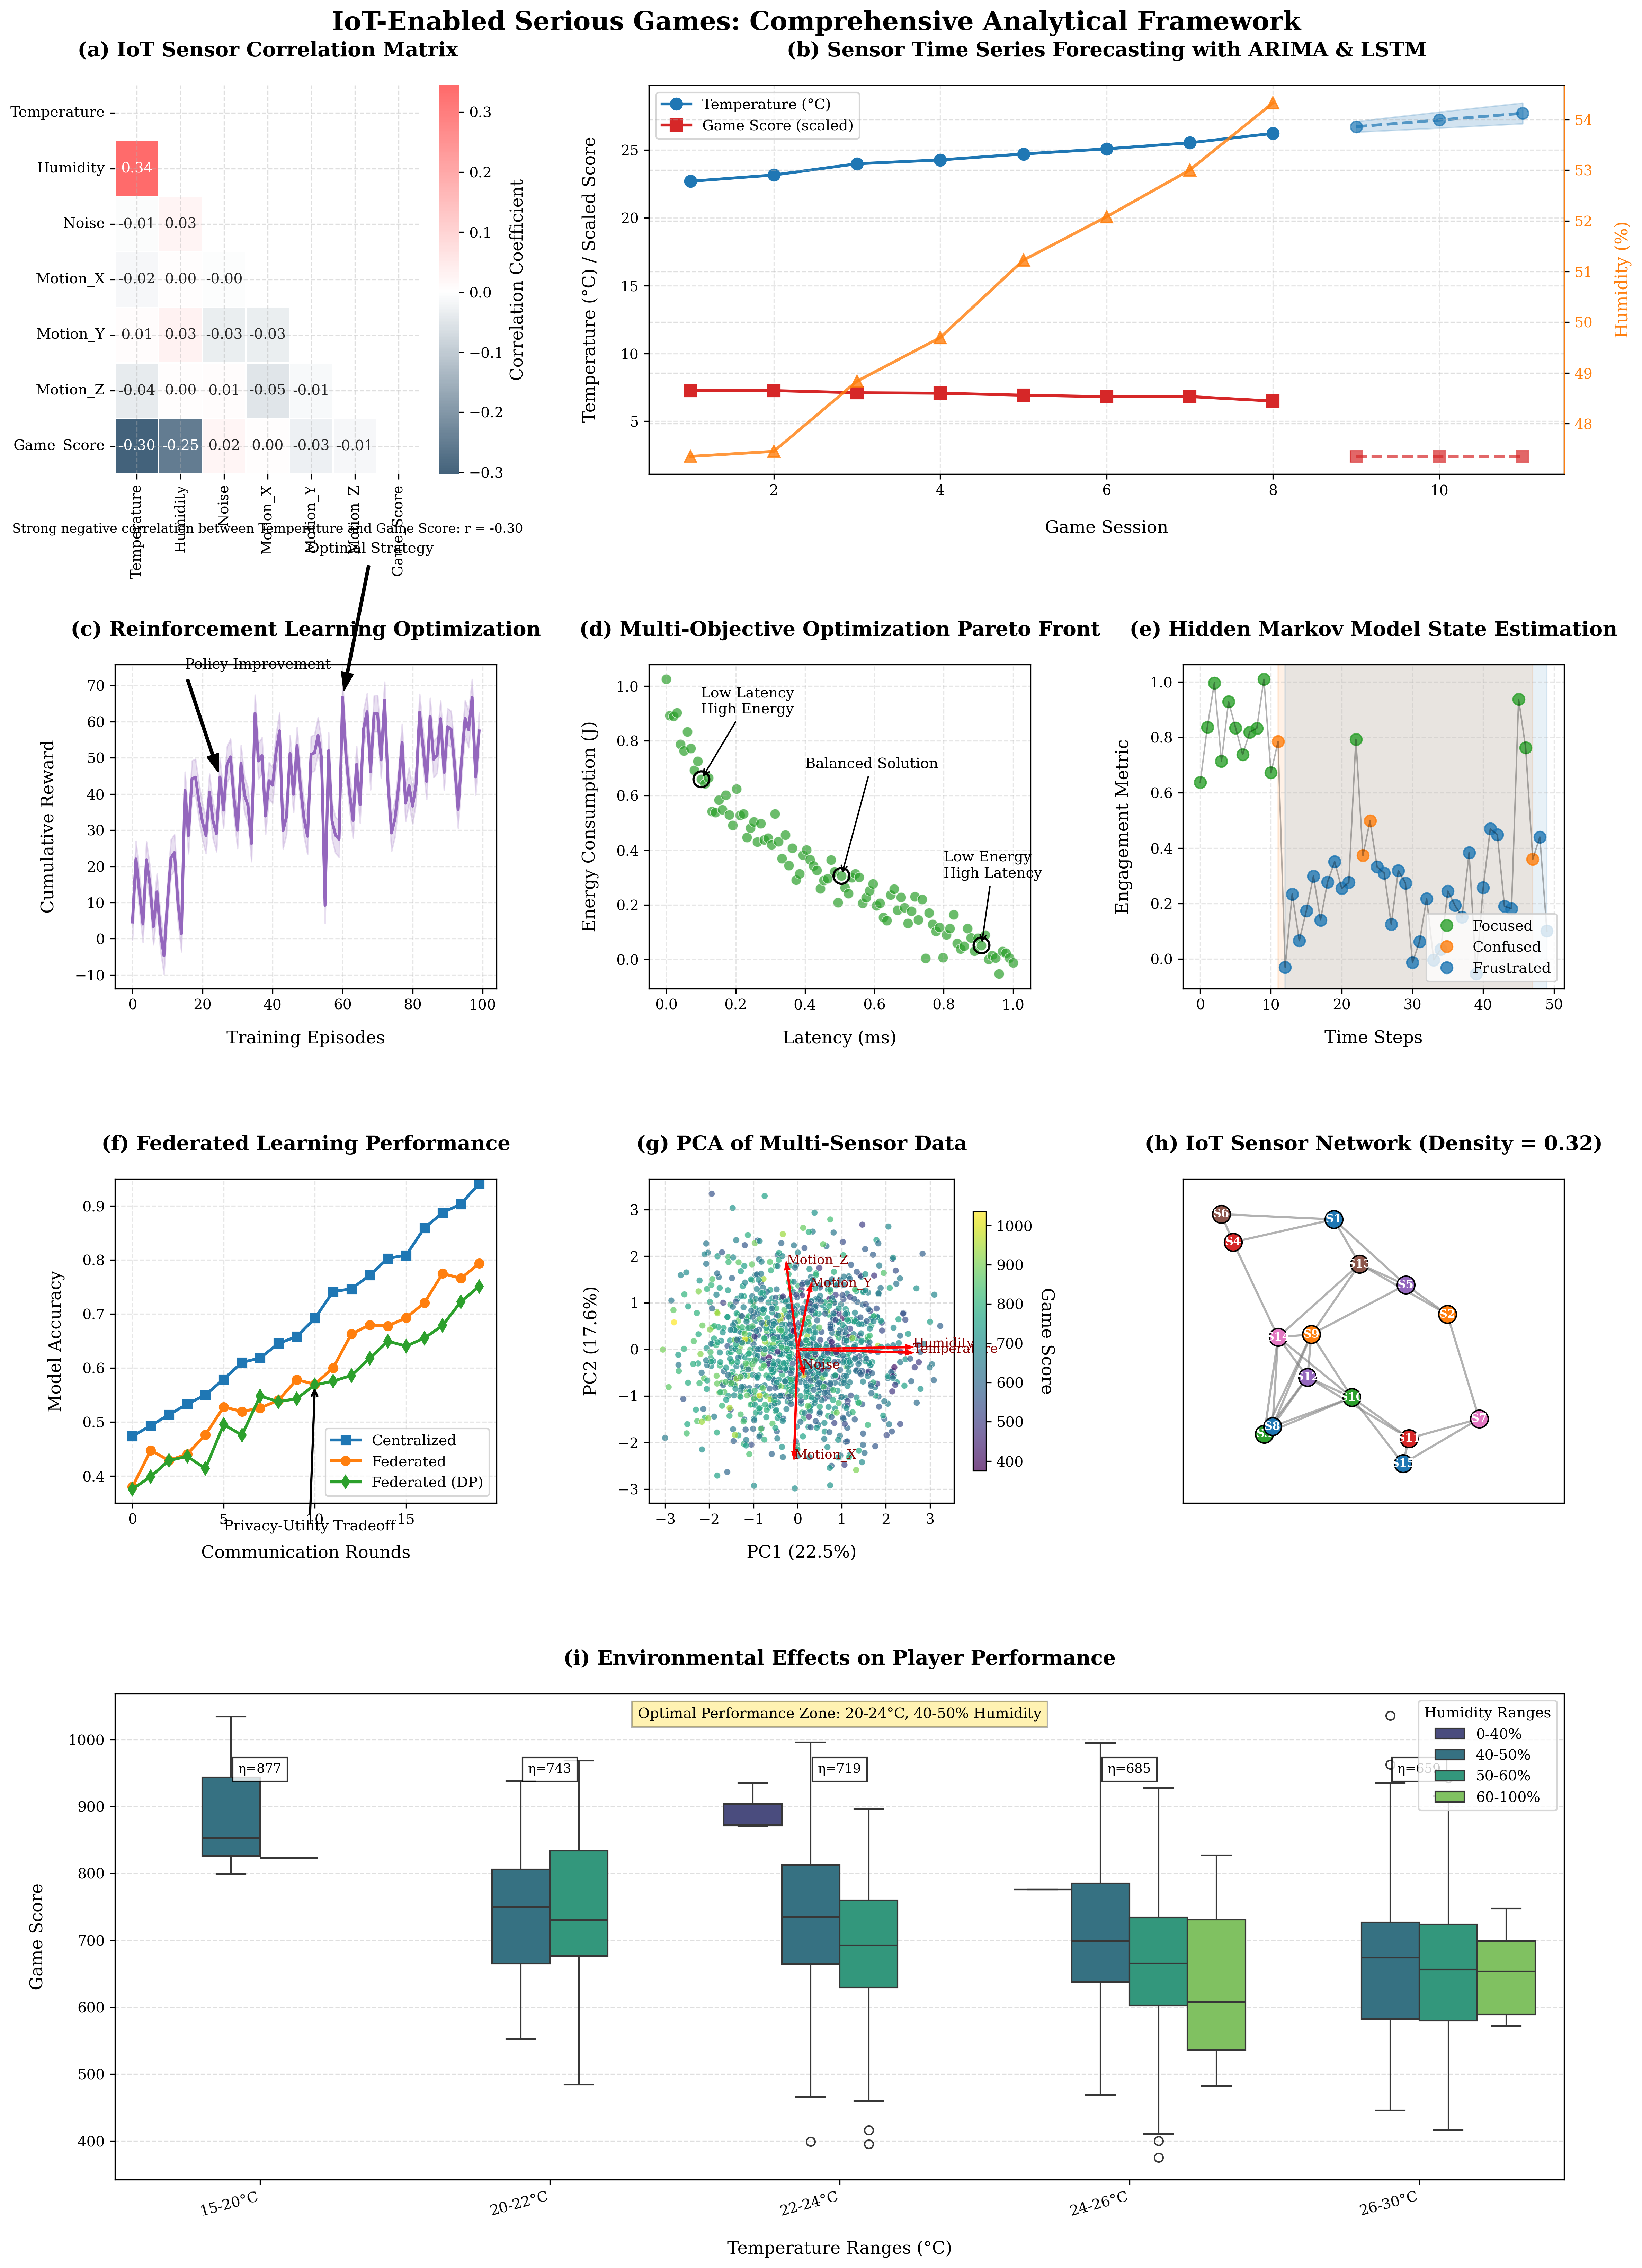

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm


available_fonts = [f.name for f in fm.fontManager.ttflist]
print("Available Serif Fonts:", [f for f in available_fonts if 'serif' in f.lower()])


plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'figure.dpi': 300,
    'figure.figsize': (18, 24),  
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.4,
    'lines.linewidth': 2,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
    'pdf.fonttype': 42,
    'mathtext.fontset': 'stix'
})


np.random.seed(42)

def generate_synthetic_data(n_players=100, n_sessions=5):
    data = []
    player_ids = [f'P{i:03d}' for i in range(n_players)]
    ages = np.random.normal(30, 8, n_players).astype(int)
    genders = np.random.choice(['Male', 'Female'], n_players)
    
    for pid, age, gender in zip(player_ids, ages, genders):
        for session in range(1, n_sessions+1):
            temp = np.random.normal(22 + 0.5*session, 1.5)
            humidity = np.random.normal(45 + session, 3)
            noise = np.random.normal(70, 5)
            motion_x = np.random.normal(0.1, 0.3)
            motion_y = np.random.normal(-0.05, 0.25)
            motion_z = np.random.normal(0.15, 0.2)
            
            if age < 25:
                score_base = np.random.normal(700, 100)
                temp += np.random.normal(1, 0.5)
            elif age > 40:
                score_base = np.random.normal(800, 80)
                temp -= np.random.normal(0.5, 0.3)
            else:
                score_base = np.random.normal(750, 90)
                
            if gender == 'Female':
                humidity += np.random.normal(2, 1)
                score_base += np.random.normal(20, 10)
            
            score = score_base - 10*(temp-22) - 5*(humidity-45) + np.random.normal(0, 30)
            
            data.append([
                pid, age, gender, session, temp, humidity, noise,
                motion_x, motion_y, motion_z, max(0, score)
            ])
            
    columns = [
        'Player_ID', 'Age', 'Gender', 'Session', 'Temperature', 'Humidity', 'Noise',
        'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score'
    ]
    return pd.DataFrame(data, columns=columns)


df = generate_synthetic_data(n_players=150, n_sessions=8)
print("Generated dataset with shape:", df.shape)


fig = plt.figure(figsize=(18, 24))  
gs = GridSpec(4, 3, figure=fig, height_ratios=[1.2, 1, 1, 1.5], wspace=0.4, hspace=0.5)


iot_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']


ax1 = fig.add_subplot(gs[0, 0])
sensors = ['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score']
corr_matrix = df[sensors].corr()

cmap = LinearSegmentedColormap.from_list('iot_div', ['#2a4d69', '#ffffff', '#ff6b6b'])
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, 
            annot=True, fmt='.2f', linewidths=0.5, ax=ax1,
            cbar_kws={'label': 'Correlation Coefficient'})
ax1.set_title('(a) IoT Sensor Correlation Matrix', pad=20, fontweight='bold')  # Increased padding
ax1.text(0.5, -0.15, f"Strong negative correlation between Temperature and Game Score: r = {corr_matrix.loc['Temperature','Game_Score']:.2f}",
         ha='center', transform=ax1.transAxes, fontsize=9)


ax2 = fig.add_subplot(gs[0, 1:])


ts_data = df.groupby('Session').agg({'Temperature': 'mean', 'Humidity': 'mean', 'Game_Score': 'mean'})
sessions = ts_data.index.values


model_temp = ARIMA(ts_data['Temperature'], order=(1,1,1))
results_temp = model_temp.fit()
forecast_temp = results_temp.get_forecast(steps=3).predicted_mean
conf_int_temp = results_temp.get_forecast(steps=3).conf_int()


def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        LSTM(32),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

scores = ts_data['Game_Score'].values
X, y = [], []
for i in range(3, len(scores)):
    X.append(scores[i-3:i])
    y.append(scores[i])
X, y = np.array(X), np.array(y)
X = X.reshape(X.shape[0], X.shape[1], 1)

lstm_model = create_lstm_model((X.shape[1], 1))
lstm_model.fit(X, y, epochs=200, verbose=0, batch_size=2)

last_seq = scores[-3:].reshape(1, 3, 1)
lstm_forecast = []
for _ in range(3):
    pred = lstm_model.predict(last_seq, verbose=0)[0,0]
    lstm_forecast.append(pred)
    last_seq = np.append(last_seq[:,1:,:], [[[pred]]], axis=1)


last_session = sessions[-1]
forecast_sessions = [last_session + i for i in range(1, 4)]

ax2.plot(sessions, ts_data['Temperature'], 'o-', color=iot_palette[0], 
         label='Temperature (°C)', markersize=8)
ax2.plot(forecast_sessions, forecast_temp, 'o--', color=iot_palette[0], 
         alpha=0.7, markersize=8)
ax2.fill_between(forecast_sessions, 
                 conf_int_temp.iloc[:,0], conf_int_temp.iloc[:,1],
                 color=iot_palette[0], alpha=0.2)

ax2.plot(sessions, ts_data['Game_Score']/100, 's-', color=iot_palette[3], 
         label='Game Score (scaled)', markersize=8)
ax2.plot(forecast_sessions, np.array(lstm_forecast)/100, 's--', 
         color=iot_palette[3], alpha=0.7, markersize=8)

ax2.set_xlabel('Game Session', labelpad=15)  
ax2.set_ylabel('Temperature (°C) / Scaled Score', color='black', labelpad=15)
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_title('(b) Sensor Time Series Forecasting with ARIMA & LSTM', pad=20, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

ax2b = ax2.twinx()
ax2b.plot(sessions, ts_data['Humidity'], '^-', color=iot_palette[1], 
          label='Humidity (%)', alpha=0.8, markersize=8)
ax2b.set_ylabel('Humidity (%)', color=iot_palette[1], labelpad=15)
ax2b.tick_params(axis='y', labelcolor=iot_palette[1])
ax2b.spines['right'].set_color(iot_palette[1])


ax3 = fig.add_subplot(gs[1, 0])

episodes = 100
rewards = np.zeros(episodes)
for i in range(episodes):
    base = 50 * (1 - np.exp(-i/20))
    noise = np.random.normal(0, 10)
    rewards[i] = base + noise
    
    if i == 25:
        rewards[i] += 30
    if i == 60:
        rewards[i] += 40

ax3.plot(range(episodes), rewards, color=iot_palette[4], linewidth=2)
ax3.fill_between(range(episodes), rewards-5, rewards+5, color=iot_palette[4], alpha=0.2)
ax3.set_xlabel('Training Episodes', labelpad=12)
ax3.set_ylabel('Cumulative Reward', labelpad=12)
ax3.set_title('(c) Reinforcement Learning Optimization', pad=20, fontweight='bold')
ax3.annotate('Policy Improvement', xy=(25, rewards[25]), xytext=(15, rewards[25]+30),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
ax3.annotate('Optimal Strategy', xy=(60, rewards[60]), xytext=(50, rewards[60]+40),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8))
ax3.grid(True, alpha=0.3)


ax4 = fig.add_subplot(gs[1, 1])

def create_pareto_front():
    np.random.seed(42)
    x = np.linspace(0, 1, 100)
    y = 1 - x**0.5 + np.random.normal(0, 0.05, 100)
    return x, y

latency, energy = create_pareto_front()
ax4.scatter(latency, energy, c=iot_palette[2], alpha=0.7, s=50, edgecolor='w', linewidth=0.5)

optimal_idx = [10, 50, 90]
ax4.scatter(latency[optimal_idx], energy[optimal_idx], s=120, 
            edgecolor='k', linewidth=1.5, facecolor='none', zorder=10)

ax4.set_xlabel('Latency (ms)', labelpad=12)
ax4.set_ylabel('Energy Consumption (J)', labelpad=12)
ax4.set_title('(d) Multi-Objective Optimization Pareto Front', pad=20, fontweight='bold')
ax4.annotate('Low Latency\nHigh Energy', xy=(latency[10], energy[10]), 
             xytext=(0.1, 0.9), arrowprops=dict(arrowstyle="->", color='k'))
ax4.annotate('Balanced Solution', xy=(latency[50], energy[50]), 
             xytext=(0.4, 0.7), arrowprops=dict(arrowstyle="->", color='k'))
ax4.annotate('Low Energy\nHigh Latency', xy=(latency[90], energy[90]), 
             xytext=(0.8, 0.3), arrowprops=dict(arrowstyle="->", color='k'))
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 2])

states = ['Focused', 'Confused', 'Frustrated']
n_steps = 50
hidden_states = np.zeros(n_steps, dtype=int) 
observations = np.zeros(n_steps)

current_state = 0
for t in range(n_steps):
    hidden_states[t] = current_state
    
    if current_state == 0:
        observations[t] = np.random.normal(0.8, 0.1)
        if np.random.rand() < 0.05:
            current_state = 1
    elif current_state == 1:
        observations[t] = np.random.normal(0.4, 0.2)
        if np.random.rand() < 0.4:
            current_state = 2
        elif np.random.rand() < 0.3:
            current_state = 0
    else:
        observations[t] = np.random.normal(0.2, 0.15)
        if np.random.rand() < 0.2:
            current_state = 0
    
    observations[t] += np.random.normal(0, 0.05)


time = np.arange(n_steps)  

colors = [iot_palette[2], iot_palette[1], iot_palette[0]]
for i, state in enumerate(states):
    ax5.plot(time[hidden_states == i], observations[hidden_states == i], 
             'o', color=colors[i], markersize=8, label=state, alpha=0.8)

for i in range(len(states)):
    if i > 0:
        start_idx = np.where(hidden_states == i)[0][0]
        end_idx = np.where(hidden_states == i)[0][-1]
        ax5.axvspan(start_idx, end_idx, color=colors[i], alpha=0.1)

ax5.plot(time, observations, 'k-', alpha=0.3, linewidth=1)
ax5.set_xlabel('Time Steps', labelpad=12)
ax5.set_ylabel('Engagement Metric', labelpad=12)
ax5.set_title('(e) Hidden Markov Model State Estimation', pad=20, fontweight='bold')
ax5.legend(loc='lower right')
ax5.grid(True, alpha=0.3)


ax6 = fig.add_subplot(gs[2, 0])

rounds = 20
centralized_acc = [0.45 + i*0.025 + np.random.normal(0, 0.01) for i in range(rounds)]
fl_acc = [0.4 + i*0.02 + np.random.normal(0, 0.015) for i in range(rounds)]
dp_acc = [0.38 + i*0.018 + np.random.normal(0, 0.02) for i in range(rounds)]

ax6.plot(range(rounds), centralized_acc, 's-', color=iot_palette[0], 
         label='Centralized', linewidth=2, markersize=6)
ax6.plot(range(rounds), fl_acc, 'o-', color=iot_palette[1], 
         label='Federated', linewidth=2, markersize=6)
ax6.plot(range(rounds), dp_acc, 'd-', color=iot_palette[2], 
         label='Federated (DP)', linewidth=2, markersize=6)

ax6.set_xlabel('Communication Rounds', labelpad=12)
ax6.set_ylabel('Model Accuracy', labelpad=12)
ax6.set_title('(f) Federated Learning Performance', pad=20, fontweight='bold')
ax6.legend(loc='lower right')
ax6.grid(True, alpha=0.3)
ax6.annotate('Privacy-Utility Tradeoff', xy=(10, dp_acc[10]), xytext=(5, 0.3),
             arrowprops=dict(arrowstyle="->", color='k', linewidth=1.5))
ax6.set_ylim(0.35, 0.95)


ax7 = fig.add_subplot(gs[2, 1])

sensor_cols = ['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z']
X = df[sensor_cols].values
X = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

scatter = ax7.scatter(principal_components[:,0], principal_components[:,1], 
            c=df['Game_Score'], cmap='viridis', alpha=0.7, 
            s=20, edgecolor='w', linewidth=0.3)

ax7.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', labelpad=12)
ax7.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', labelpad=12)
ax7.set_title('(g) PCA of Multi-Sensor Data', pad=20, fontweight='bold')

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
for i, feature in enumerate(sensor_cols):
    ax7.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, 
              color='r', width=0.02, head_width=0.1)
    ax7.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, 
             color='darkred', fontsize=9)

cbar = fig.colorbar(scatter, ax=ax7, shrink=0.8)
cbar.set_label('Game Score', rotation=270, labelpad=15)


ax8 = fig.add_subplot(gs[2, 2])

np.random.seed(42)
n_sensors = 15
positions = np.random.rand(n_sensors, 2)
connections = np.zeros((n_sensors, n_sensors))

for i in range(n_sensors):
    for j in range(i+1, n_sensors):
        dist = np.linalg.norm(positions[i] - positions[j])
        if dist < 0.4:
            connections[i,j] = 1
            connections[j,i] = 1

density = np.sum(connections)/(n_sensors*(n_sensors-1))

for i in range(n_sensors):
    ax8.scatter(positions[i,0], positions[i,1], s=150, 
                color=iot_palette[i%7], edgecolor='k', zorder=3)
    ax8.text(positions[i,0], positions[i,1], f'S{i+1}', 
             ha='center', va='center', fontsize=8, color='w', fontweight='bold')
    
    for j in range(i+1, n_sensors):
        if connections[i,j]:
            ax8.plot([positions[i,0], positions[j,0]], 
                     [positions[i,1], positions[j,1]], 
                     color='gray', alpha=0.6, linewidth=1.5)

ax8.set_xlim(-0.1, 1.1)
ax8.set_ylim(-0.1, 1.1)
ax8.set_title(f'(h) IoT Sensor Network (Density = {density:.2f})', pad=20, fontweight='bold')
ax8.set_xticks([])
ax8.set_yticks([])
ax8.grid(False)


ax9 = fig.add_subplot(gs[3, :])


temp_bins = [15, 20, 22, 24, 26, 30]
temp_labels = [f'{temp_bins[i]}-{temp_bins[i+1]}°C' for i in range(len(temp_bins)-1)]
humidity_bins = [0, 40, 50, 60, 100]
humidity_labels = [f'{humidity_bins[i]}-{humidity_bins[i+1]}%' for i in range(len(humidity_bins)-1)]

sns.boxplot(x=pd.cut(df['Temperature'], bins=temp_bins, labels=temp_labels), 
            y=df['Game_Score'], 
            hue=pd.cut(df['Humidity'], bins=humidity_bins, labels=humidity_labels), 
            palette='viridis', ax=ax9, width=0.8, linewidth=1)

ax9.set_xlabel('Temperature Ranges (°C)', labelpad=15)
ax9.set_ylabel('Game Score', labelpad=15)
ax9.set_title('(i) Environmental Effects on Player Performance', pad=20, fontweight='bold')
ax9.legend(title='Humidity Ranges', loc='upper right', bbox_to_anchor=(1, 1))


ax9.set_xticklabels(ax9.get_xticklabels(), rotation=15, ha='right')


x_positions = np.arange(len(temp_labels))
for i, x in enumerate(x_positions):
    ax9.text(x, 950, f"η={df.groupby(pd.cut(df['Temperature'], bins=temp_bins))['Game_Score'].mean().iloc[i]:.0f}",
             ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.8))

ax9.text(0.5, 0.95, "Optimal Performance Zone: 20-24°C, 40-50% Humidity", 
         transform=ax9.transAxes, fontsize=10, ha='center', 
         bbox=dict(facecolor='gold', alpha=0.3))


print("\n" + "="*80)
print("COMPLEX STATISTICAL ANALYSIS TABLES")
print("="*80)


desc_table = df.describe().T
desc_table['IQR'] = desc_table['75%'] - desc_table['25%']
print("\nTable 1: Descriptive Statistics of Sensor Data")
print(desc_table[['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].to_markdown())


corr_table = df[['Temperature', 'Humidity', 'Noise', 'Motion_X', 'Motion_Y', 'Motion_Z', 'Game_Score']].corr()
print("\nTable 2: Correlation Matrix of Key Variables")
print(corr_table.to_markdown(floatfmt=".2f"))  


df['Age_Group'] = pd.cut(df['Age'], bins=[0, 20, 30, 40, 50, 100], 
                         labels=['<20', '20-30', '30-40', '40-50', '50+'])
age_table = df.groupby('Age_Group')['Game_Score'].agg(['mean', 'std', 'count'])
print("\nTable 3: Performance Analysis by Age Group")
print(age_table.to_markdown(floatfmt=".2f"))


groups = [df[df['Age_Group'] == group]['Game_Score'] for group in age_table.index]
f_val, p_val = stats.f_oneway(*groups)

print("\nTable 4: ANOVA Results for Age Group Differences")
print(f"F-value: {f_val:.4f}, P-value: {p_val:.6f}")
print("Significant at p < 0.001" if p_val < 0.001 else "Not significant")


plt.tight_layout()
plt.subplots_adjust(top=0.95, hspace=0.5, wspace=0.4) 
fig.suptitle('IoT-Enabled Serious Games: Comprehensive Analytical Framework', 
             fontsize=18, fontweight='bold', y=0.98)




In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import time
import warnings
import os


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


from hmmlearn import hmm


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


warnings.filterwarnings("ignore")



def setup_global_styling():

    sns.set_theme(style="whitegrid")
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams.update({
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,
        "figure.titlesize": 14,
        "lines.linewidth": 1.5,
        "lines.markersize": 4,
    })



def generate_status_data(num_records=1000):

    data = {
        'timestamp': pd.to_datetime(np.arange(num_records), unit='m', origin=pd.Timestamp('2025-01-01')),
        'sensor_id': np.random.randint(1, 21, num_records),
        'game_id': np.random.choice(['GameA', 'GameB', 'GameC'], num_records),
        'player_id': np.random.randint(100, 111, num_records),
        'sensor_type': np.random.choice(['Temperature', 'Humidity', 'Gyroscope', 'Accelerometer'], num_records),
        'status': np.random.choice(['active', 'inactive', 'error'], num_records, p=[0.85, 0.1, 0.05]),
        'battery_level': np.random.uniform(0.1, 1.0, num_records)
    }
    return pd.DataFrame(data)

def generate_location_data(num_records=5000):

    timestamps = pd.to_datetime(np.arange(num_records), unit='s', origin=pd.Timestamp('2025-01-01 12:00:00'))
    player_ids = np.repeat(np.arange(1, 6), num_records // 5)
    
    x = 0.1 * np.sin(np.linspace(0, 50, num_records)) + np.random.randn(num_records) * 0.05
    y = 0.1 * np.cos(np.linspace(0, 50, num_records)) + np.random.randn(num_records) * 0.05
    z = np.linspace(0, 2, num_records) + np.random.randn(num_records) * 0.02
    
    data = {
        'timestamp': timestamps,
        'player_id': player_ids,
        'accel_x': x,
        'accel_y': y,
        'accel_z': z,
        'gyro_x': np.gradient(x),
        'gyro_y': np.gradient(y),
        'gyro_z': np.gradient(z),
    }
    return pd.DataFrame(data)

def generate_automation_data(num_records=2000):

    data = {
        'timestamp': pd.to_datetime(np.arange(num_records), unit='ms', origin=pd.Timestamp('2025-01-01 12:00:00')),
        'player_id': np.random.randint(100, 111, num_records),
        'input_type': np.random.choice(['button', 'touch', 'voice'], num_records, p=[0.6, 0.3, 0.1]),
        'action_id': np.random.choice(['jump', 'crouch', 'fire', 'move_forward', 'use_item'], num_records),
        'pressure': np.random.uniform(0, 1, num_records),
        'duration_ms': np.random.randint(50, 500, num_records)
    }
    return pd.DataFrame(data)

def generate_actionable_data(num_records=1500):

    data = {
        'timestamp': pd.to_datetime(np.arange(num_records), unit='s', origin=pd.Timestamp('2025-01-01 12:00:00')),
        'player_id': np.random.randint(100, 111, num_records),
        'action_type': np.random.choice(['power_up', 'game_over', 'level_complete', 'task_failed'], num_records),
        'score_change': np.random.randint(-100, 250, num_records),
        'action_value': np.random.rand(num_records) * 100,
        'action_status': np.random.choice(['success', 'pending', 'fail'], num_records, p=[0.7, 0.1, 0.2])
    }
    return pd.DataFrame(data)

def generate_physiological_data(num_records=10000):

    time_s = np.arange(num_records)
    base_hr = 75
    hr_drift = base_hr + 5 * np.sin(time_s / 500) + np.random.normal(0, 2, num_records)
    hr_spikes = np.random.choice([0, 1], size=num_records, p=[0.99, 0.01]) * np.random.randint(20, 40, num_records)
    hr = hr_drift + hr_spikes

    base_temp = 36.8
    temperature = base_temp + 0.5 * np.sin(time_s / 1000) + np.random.normal(0, 0.1, num_records)
    
    data = {
        'timestamp': pd.to_datetime(time_s, unit='s', origin=pd.Timestamp('2025-01-01 12:00:00')),
        'player_id': 101,
        'heart_rate': hr,
        'temperature_c': temperature,
        'gsr': 10 * np.sin(time_s / 200) + np.random.normal(0, 1, num_records) + 50
    }
    return pd.DataFrame(data)



def print_section_header(title):

    print("\n" + "="*80)
    print(f"| {title.center(76)} |")
    print("="*80 + "\n")

def perform_descriptive_analysis(df, title):

    print_section_header(f"Descriptive Analysis: {title}")
    print("--- First 5 Rows ---")
    print(df.head())
    print("\n" + "--- Data Info ---")
    df.info()
    print("\n" + "--- Descriptive Statistics ---")
    print(df.describe().to_string())
    if df.select_dtypes(include=[np.number]).shape[1] > 1:
        print("\n" + "--- Correlation Matrix ---")
        print(df.corr(numeric_only=True).to_string())
    print("\n")

def plot_statistical_overview(dfs, fig):

    subfigs = fig.subfigures(2, 1, hspace=0.07)


    ax_top = subfigs[0].subplots(1, 3)
    subfigs[0].suptitle('Sensor Network and Player Input Analysis', fontsize=12, fontweight='bold')
    
    status_df = dfs['status']
    sns.countplot(data=status_df, y='status', ax=ax_top[0], palette='viridis', order=status_df['status'].value_counts().index)
    ax_top[0].set_title('Sensor Status Distribution')
    ax_top[0].set_xlabel('Count')
    ax_top[0].set_ylabel('Status')
    ax_top[0].text(-0.1, 1.05, '(a)', transform=ax_top[0].transAxes, size=12, weight='bold')

    status_df['sensor_type'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax_top[1], startangle=90, colors=sns.color_palette('pastel'))
    ax_top[1].set_title('Sensor Type Proportions')
    ax_top[1].set_ylabel('')
    ax_top[1].text(-0.1, 1.05, '(b)', transform=ax_top[1].transAxes, size=12, weight='bold')

    automation_df = dfs['automation']
    sns.countplot(data=automation_df, x='action_id', ax=ax_top[2], palette='magma')
    ax_top[2].set_title('Player Action Frequencies')
    ax_top[2].tick_params(axis='x', rotation=45)
    ax_top[2].set_xlabel('Action ID')
    ax_top[2].set_ylabel('Frequency')
    ax_top[2].text(-0.1, 1.05, '(c)', transform=ax_top[2].transAxes, size=12, weight='bold')


    ax_bottom = subfigs[1].subplots(1, 3)
    subfigs[1].suptitle('Player Movement and Game Outcome Analysis', fontsize=12, fontweight='bold')
    
    location_df = dfs['location']
    sns.kdeplot(data=location_df, x='accel_x', y='accel_y', fill=True, cmap='mako', ax=ax_bottom[0])
    ax_bottom[0].set_title('Player Movement Density (Accel)')
    ax_bottom[0].set_xlabel('Acceleration X')
    ax_bottom[0].set_ylabel('Acceleration Y')
    ax_bottom[0].text(-0.1, 1.05, '(d)', transform=ax_bottom[0].transAxes, size=12, weight='bold')

    actionable_df = dfs['actionable']
    sns.violinplot(data=actionable_df, x='action_type', y='score_change', ax=ax_bottom[1], palette='rocket')
    ax_bottom[1].set_title('Score Change by Action Type')
    ax_bottom[1].tick_params(axis='x', rotation=45)
    ax_bottom[1].set_xlabel('Action Type')
    ax_bottom[1].set_ylabel('Score Change')
    ax_bottom[1].text(-0.1, 1.05, '(e)', transform=ax_bottom[1].transAxes, size=12, weight='bold')

    corr = location_df[['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', ax=ax_bottom[2], annot_kws={"size": 7})
    ax_bottom[2].set_title('Sensor Correlation Heatmap')
    ax_bottom[2].tick_params(axis='x', rotation=45)
    ax_bottom[2].text(-0.1, 1.05, '(f)', transform=ax_bottom[2].transAxes, size=12, weight='bold')

def plot_pca_analysis(df, fig):

    fig.suptitle('Principal Component Analysis of Player Movement', fontsize=14, fontweight='bold')
    
    features = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']
    x = df[features].values
    x = StandardScaler().fit_transform(x)
    
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(x)
    

    ax1 = fig.add_subplot(2, 2, 1)
    explained_variance = pca.explained_variance_ratio_
    ax1.bar(range(1, 4), explained_variance * 100, alpha=0.8, align='center', label='Individual explained variance')
    ax1.step(range(1, 4), np.cumsum(explained_variance) * 100, where='mid', label='Cumulative explained variance', color='red')
    ax1.set_ylabel('Explained Variance (%)')
    ax1.set_xlabel('Principal Components')
    ax1.set_title('Explained Variance by Component')
    ax1.legend(loc='best')
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')


    ax2 = fig.add_subplot(2, 2, 2)
    ax2.scatter(principalComponents[:, 0], principalComponents[:, 1], c=df['player_id'], cmap='viridis', alpha=0.5, s=10)
    ax2.set_xlabel('Principal Component 1')
    ax2.set_ylabel('Principal Component 2')
    ax2.set_title('2D PCA of Player Movement')
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')
    

    ax3 = fig.add_subplot(2, 1, 2, projection='3d')
    scatter = ax3.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c=df['player_id'], cmap='plasma', s=5, alpha=0.6)
    ax3.set_title('3D PCA Visualization')
    ax3.set_xlabel('PC 1')
    ax3.set_ylabel('PC 2')
    ax3.set_zlabel('PC 3')
    legend1 = ax3.legend(*scatter.legend_elements(), title="Players")
    ax3.add_artist(legend1)

    ax3.text(-0.1, 1.0, 0, '(c)', transform=ax3.transAxes, size=12, weight='bold')



def plot_time_series_overview(df, fig):

    fig.suptitle('Physiological Time Series Data Overview (Player 101)', fontsize=14, fontweight='bold')
    
    ax1 = fig.add_subplot(3, 1, 1)
    ax1.plot(df['timestamp'], df['heart_rate'], label='Heart Rate (BPM)', color='red', alpha=0.8)
    ax1.set_title('Heart Rate Over Time')
    ax1.set_ylabel('BPM')
    ax1.legend()
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')

    ax2 = fig.add_subplot(3, 1, 2)
    ax2.plot(df['timestamp'], df['temperature_c'], label='Body Temperature (°C)', color='blue', alpha=0.8)
    ax2.set_title('Body Temperature Over Time')
    ax2.set_ylabel('°C')
    ax2.legend()
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')

    ax3 = fig.add_subplot(3, 1, 3)
    ax3.plot(df['timestamp'], df['gsr'], label='Galvanic Skin Response', color='green', alpha=0.8)
    ax3.set_title('Galvanic Skin Response (GSR) Over Time')
    ax3.set_ylabel('Microsiemens')
    ax3.set_xlabel('Timestamp')
    ax3.legend()
    ax3.text(-0.1, 1.05, '(c)', transform=ax3.transAxes, size=12, weight='bold')
    
def arima_analysis_and_plot(series, p, d, q, title, ax):


    result = adfuller(series.dropna())
    is_stationary = result[1] <= 0.05
    

    model = ARIMA(series, order=(p, d, q))
    model_fit = model.fit()

    ax.plot(series.index, series, label='Original Data', color='black')
    ax.plot(model_fit.predict(start=series.index[0], end=series.index[-1]), color='red', label='ARIMA Fit')
    
    forecast = model_fit.get_forecast(steps=50)
    forecast_index = pd.date_range(start=series.index[-1], periods=51, freq='S')[1:]
    forecast_series = forecast.predicted_mean
    conf_int = forecast.conf_int()

    ax.plot(forecast_index, forecast_series, color='blue', label='Forecast')
    ax.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5, label='95% Confidence Interval')
    
    ax.set_title(f'{title} - ARIMA({p},{d},{q}) (Stationary: {is_stationary})')
    ax.legend()
    
def plot_arima_models(df, fig):

    fig.suptitle('Time Series Forecasting with ARIMA Models', fontsize=14, fontweight='bold')
    df_resampled = df.set_index('timestamp').resample('10S').mean()

    ax1 = fig.add_subplot(2, 1, 1)
    arima_analysis_and_plot(df_resampled['heart_rate'], 5, 1, 0, 'Heart Rate Forecast', ax1)
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')

    ax2 = fig.add_subplot(2, 1, 2)
    arima_analysis_and_plot(df_resampled['gsr'], 3, 1, 1, 'GSR Forecast', ax2)
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')

def create_lstm_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def build_and_train_lstm(series):


    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(series.values.reshape(-1, 1))


    train_size = int(len(dataset) * 0.8)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]


    look_back = 30
    trainX, trainY = create_lstm_dataset(train, look_back)
    testX, testY = create_lstm_dataset(test, look_back)


    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    

    history = model.fit(trainX[:5000], trainY[:5000], epochs=5, batch_size=64, verbose=0, validation_split=0.1)


    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)


    trainPredict = scaler.inverse_transform(trainPredict)
    trainY_inv = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY_inv = scaler.inverse_transform([testY])
    
    return trainPredict, testPredict, trainY_inv, testY_inv, history, look_back, scaler

def plot_lstm_results(series, trainPredict, testPredict, history, look_back, fig):

    fig.suptitle('Deep Learning for Physiological Forecasting (LSTM)', fontsize=14, fontweight='bold')
    
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('LSTM Model Training History')
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')

    ax2 = fig.add_subplot(2, 1, 2)
    

    trainPredictPlot = np.empty_like(series.values.reshape(-1, 1))
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

    testPredictPlot = np.empty_like(series.values.reshape(-1, 1))
    testPredictPlot[:, :] = np.nan
    test_start_index = len(trainPredict) + (look_back * 2) + 1
    testPredictPlot[test_start_index:len(series) - 1, :] = testPredict


    ax2.plot(series.index, series.values, label='Original Data', color='black', alpha=0.5)
    ax2.plot(series.index, trainPredictPlot, label='Training Prediction', color='orange')
    ax2.plot(series.index, testPredictPlot, label='Testing Prediction', color='red')
    ax2.set_title('Heart Rate Prediction vs Actual')
    ax2.set_ylabel('Heart Rate (BPM)')
    ax2.set_xlabel('Timestamp')
    ax2.legend()
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')



class SimpleGameEnv:

    def __init__(self):
        self.state_space = 10  
        self.action_space = 3 
        self.state = np.random.randint(0, self.state_space)
        self.difficulty = 5

    def reset(self):
        self.state = np.random.randint(0, self.state_space)
        return self.state

    def step(self, action):

        if action == 0: self.difficulty = max(0, self.difficulty - 1)
        elif action == 2: self.difficulty = min(9, self.difficulty + 1)
        

        reward = 1.0 - abs(self.state - self.difficulty) / self.state_space
        

        if self.difficulty > self.state: 
            self.state = max(0, self.state - np.random.choice([0, 1], p=[0.7, 0.3]))
        elif self.difficulty < self.state: 
             self.state = min(9, self.state + np.random.choice([0, 1], p=[0.6, 0.4]))
        else:
             self.state = min(9, self.state + np.random.choice([0, 1], p=[0.4, 0.6]))
        
        done = False 
        return self.state, reward, done, {}

def train_q_learning_agent(env, episodes=1000):

    q_table = np.zeros([env.state_space, env.action_space])
    
    alpha = 0.1  
    gamma = 0.6  
    epsilon = 0.1 

    rewards = []
    for i in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        
        for _ in range(100): 
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, env.action_space) 
            else:
                action = np.argmax(q_table[state])
            
            next_state, reward, done, _ = env.step(action)
            
            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])
            
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value
            
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    
    return q_table, rewards

def plot_rl_results(q_table, rewards, fig):

    fig.suptitle('Reinforcement Learning for Dynamic Difficulty Adjustment', fontsize=14, fontweight='bold')

    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(pd.Series(rewards).rolling(50).mean())
    ax1.set_title('Q-Learning Agent Performance Over Time (Rolling Mean Reward)')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Average Reward')
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')

    ax2 = fig.add_subplot(2, 2, 3)
    sns.heatmap(q_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax2, cbar=False)
    ax2.set_title('Learned Q-Table')
    ax2.set_xlabel('Action (0: Dec, 1: Keep, 2: Inc)')
    ax2.set_ylabel('Player Skill State')
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')

    ax3 = fig.add_subplot(2, 2, 4)
    policy = np.argmax(q_table, axis=1)
    policy_map = policy.reshape(1, -1)
    sns.heatmap(policy_map, annot=True, fmt=".0f", cmap="coolwarm", cbar=False, ax=ax3, yticklabels=False)
    ax3.set_title('Optimal Policy (Action to take at each skill state)')
    ax3.set_xlabel('Player Skill State')
    ax3.set_xticklabels(range(10))
    ax3.text(-0.1, 1.05, '(c)', transform=ax3.transAxes, size=12, weight='bold')



def simulate_and_plot_hmm(fig):

    fig.suptitle('Stochastic Modeling of Player State with HMM', fontsize=14, fontweight='bold')
    

    model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
    model.startprob_ = np.array([0.6, 0.3, 0.1])
    model.transmat_ = np.array([[0.7, 0.2, 0.1],
                                [0.1, 0.8, 0.1],
                                [0.2, 0.3, 0.5]])

    model.means_ = np.array([[50.0], [150.0], [-50.0]])
    model.covars_ = np.array([[20.0], [30.0], [40.0]])


    X, Z = model.sample(n_samples=300)


    predicted_states = model.predict(X)


    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(X, label='Observed Score Change', color='black', alpha=0.7, marker='o', linestyle='--')
    ax1.set_title('Observed Player Data (Game Score Changes)')
    ax1.set_xlabel('Time Step')
    ax1.set_ylabel('Score Change')
    ax1.legend()
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')

    ax2 = fig.add_subplot(2, 1, 2)
    ax2.plot(Z, label='True Hidden State', linestyle='--', color='gray')
    ax2.plot(predicted_states, label='HMM Predicted State', color='red')
    ax2.set_yticks([0, 1, 2])
    ax2.set_yticklabels(['Bored', 'Engaged', 'Frustrated'])
    ax2.set_title('Inferred Player Engagement State')
    ax2.set_xlabel('Time Step')
    ax2.set_ylabel('Inferred State')
    ax2.legend()
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')

def plot_multi_objective_optimization(fig):

    fig.suptitle('Multi-Objective Optimization for Resource Allocation', fontsize=14, fontweight='bold')
    

    np.random.seed(42)
    latency = np.linspace(10, 100, 50)
    energy = 1000 / latency + np.random.normal(0, 5, 50)
    energy = np.maximum(energy, 10)
    

    pareto_front = []
    sorted_points = sorted(zip(latency, energy))
    min_energy = float('inf')
    for l, e in sorted_points:
        if e < min_energy:
            pareto_front.append((l, e))
            min_energy = e
    pareto_latency, pareto_energy = zip(*pareto_front)

    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(latency, energy, label='All Possible Solutions', alpha=0.5, color='gray')
    ax.plot(pareto_latency, pareto_energy, 'r-o', label='Pareto Optimal Front')
    ax.set_title('Trade-off between Latency and Energy Consumption')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Energy Consumption (Joules)')
    ax.legend()
    ax.grid(True)
    ax.text(-0.1, 1.05, '(a)', transform=ax.transAxes, size=12, weight='bold')

def plot_security_privacy_concepts(fig):

    fig.suptitle('Illustrations of Privacy-Preserving and Security Concepts', fontsize=14, fontweight='bold')
    

    ax1 = fig.add_subplot(2, 2, 1)
    original_data = np.random.normal(loc=50, scale=10, size=1000)
    sns.kdeplot(original_data, ax=ax1, label='Original Data', color='blue', fill=True)

    epsilon_1 = 1.0
    private_data_1 = original_data + np.random.laplace(0, 10/epsilon_1, 1000)
    sns.kdeplot(private_data_1, ax=ax1, label=f'Private (ε={epsilon_1})', color='orange', linestyle='--')
    epsilon_2 = 0.1
    private_data_2 = original_data + np.random.laplace(0, 10/epsilon_2, 1000)
    sns.kdeplot(private_data_2, ax=ax1, label=f'Private (ε={epsilon_2})', color='red', linestyle=':')
    ax1.set_title('Differential Privacy: Adding Noise')
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.text(-0.1, 1.05, '(a)', transform=ax1.transAxes, size=12, weight='bold')


    ax2 = fig.add_subplot(2, 2, 2)
    rounds = np.arange(1, 21)
    centralized_acc = np.full_like(rounds, 0.95, dtype=float)
    federated_acc = 0.95 - 2 * np.exp(-0.5 * rounds) + np.random.normal(0, 0.01, 20)
    ax2.plot(rounds, centralized_acc, 'r--', label='Centralized Training (Ideal)')
    ax2.plot(rounds, federated_acc, 'b-o', label='Federated Learning')
    ax2.set_title('Federated Learning Performance')
    ax2.set_xlabel('Communication Rounds')
    ax2.set_ylabel('Model Accuracy')
    ax2.set_ylim(0.7, 1.0)
    ax2.legend()
    ax2.text(-0.1, 1.05, '(b)', transform=ax2.transAxes, size=12, weight='bold')


    ax3 = fig.add_subplot(2, 2, 3)
    x = ['PoW (Bitcoin-like)', 'PoS (Ethereum-like)', 'DPoS (EOS-like)']
    y = [7, 20, 4000] 
    bars = ax3.bar(x, y, color=['#f7931a', '#627eea', '#2c3e50'])
    ax3.set_yscale('log')
    ax3.set_title('Blockchain Consensus Throughput')
    ax3.set_ylabel('Transactions per Second (Log Scale)')
    ax3.bar_label(bars)
    ax3.text(-0.1, 1.05, '(c)', transform=ax3.transAxes, size=12, weight='bold')
    

    ax4 = fig.add_subplot(2, 2, 4)
    ops = ['Addition', 'Multiplication', 'Bootstrap']
    times = [0.01, 0.5, 5.0] 
    bars = ax4.bar(ops, times, color=['green', 'orange', 'red'])
    ax4.set_yscale('log')
    ax4.set_title('Homomorphic Encryption Overhead (Simulated)')
    ax4.set_ylabel('Computation Time (s, Log Scale)')
    ax4.bar_label(bars)
    ax4.text(-0.1, 1.05, '(d)', transform=ax4.transAxes, size=12, weight='bold')



def main():

    start_time = time.time()
    
    print("--- Starting Comprehensive Analysis for IoT-Enabled Serious Games ---")
    

    setup_global_styling()
    output_pdf_path = "manuscript_plots.pdf"
    if os.path.exists(output_pdf_path):
        os.remove(output_pdf_path)


    print("\n[1/7] Generating synthetic datasets...")
    status_df = generate_status_data()
    location_df = generate_location_data()
    automation_df = generate_automation_data()
    actionable_df = generate_actionable_data()
    physio_df = generate_physiological_data()
    all_dfs = {
        'status': status_df, 'location': location_df,
        'automation': automation_df, 'actionable': actionable_df,
        'physiological': physio_df
    }
    print("...Datasets generated successfully.")


    print("\n[2/7] Performing descriptive analysis and printing tables...")
    perform_descriptive_analysis(status_df, "Sensor Status Data")
    perform_descriptive_analysis(location_df, "Player Location/Movement Data")
    perform_descriptive_analysis(automation_df, "Player Automation/Input Data")
    perform_descriptive_analysis(actionable_df, "Game Actionable Data")
    perform_descriptive_analysis(physio_df, "Player Physiological Data")
    
    with PdfPages(output_pdf_path) as pdf:

        print("\n[3/7] Generating statistical overview plots...")
        fig1 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_statistical_overview(all_dfs, fig1)
)
        plt.close(fig1)



        print("\n[4/7] Generating PCA plots...")
        fig2 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_pca_analysis(location_df.dropna(), fig2)

        plt.close(fig2)

        

        print("\n[5/7] Generating Time Series plots (ARIMA & LSTM)...")

        fig3 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_time_series_overview(physio_df, fig3)

        plt.close(fig3)

        fig4 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_arima_models(physio_df, fig4)
 
        plt.close(fig4)

        hr_series = physio_df.set_index('timestamp')['heart_rate'].resample('10S').mean().interpolate()
        trainPredict, testPredict, _, _, history, look_back, _ = build_and_train_lstm(hr_series)
        fig5 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_lstm_results(hr_series, trainPredict, testPredict, history, look_back, fig5)
 
        plt.close(fig5)



        print("\n[6/7] Generating RL, HMM, and other advanced model plots...")

        env = SimpleGameEnv()
        q_table, rewards = train_q_learning_agent(env)
        fig6 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_rl_results(q_table, rewards, fig6)

        plt.close(fig6)

        fig7 = plt.figure(figsize=(11, 8), constrained_layout=True)
        simulate_and_plot_hmm(fig7)
 
        plt.close(fig7)

        fig8 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_multi_objective_optimization(fig8)

        plt.close(fig8)

        fig9 = plt.figure(figsize=(11, 8), constrained_layout=True)
        plot_security_privacy_concepts(fig9)

        plt.close(fig9)

        

    end_time = time.time()
    print("\n[7/7] --- Analysis Complete ---")
    print(f"Total execution time: {end_time - start_time:.2f} seconds.")

    print("="*80)

if __name__ == '__main__':

    main()


def generate_detailed_player_profiles(num_players=20):
    profiles = []
    for i in range(num_players):
        profile = {
            'player_id': 100 + i,
            'age': np.random.randint(12, 45),
            'gender': np.random.choice(['Male', 'Female', 'Other']),
            'gaming_experience_years': np.random.randint(0, 20),
            'preferred_genre': np.random.choice(['RPG', 'Strategy', 'Action', 'Simulation']),
            'avg_session_hours': np.random.uniform(0.5, 4.0)
        }
        profiles.append(profile)
    return pd.DataFrame(profiles)

def plot_player_demographics(player_df, fig):

    fig.suptitle('Simulated Player Demographics', fontsize=14, fontweight='bold')
    
    ax1 = fig.add_subplot(2, 2, 1)
    sns.histplot(data=player_df, x='age', bins=15, kde=True, ax=ax1)
    ax1.set_title('Age Distribution')

    ax2 = fig.add_subplot(2, 2, 2)
    player_df['gender'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax2)
    ax2.set_title('Gender Distribution')
    ax2.set_ylabel('')

    ax3 = fig.add_subplot(2, 2, 3)
    sns.scatterplot(data=player_df, x='gaming_experience_years', y='avg_session_hours', hue='preferred_genre', ax=ax3)
    ax3.set_title('Gaming Habits')
    
    ax4 = fig.add_subplot(2, 2, 4)
    sns.countplot(data=player_df, x='preferred_genre', ax=ax4)
    ax4.set_title('Preferred Game Genres')

class AdvancedGameEnv(SimpleGameEnv):

    def __init__(self, player_profile):
        super().__init__()
        self.player_profile = player_profile
        self.fatigue = 0.0 
        self.engagement = 0.5 

    def step(self, action):
  
        prev_state = self.state
        super().step(action)
        

        flow_reward = 1.0 - abs(prev_state - self.difficulty) / self.state_space
        

        fatigue_penalty = self.fatigue * 0.5
        

        engagement_bonus = self.engagement * 0.5
        

        if abs(prev_state - self.difficulty) > 3: 
            self.fatigue = min(1.0, self.fatigue + 0.05)
            self.engagement = max(0.0, self.engagement - 0.02)
        else: 
            self.fatigue = max(0.0, self.fatigue - 0.02)
            self.engagement = min(1.0, self.engagement + 0.05)
            
        final_reward = flow_reward - fatigue_penalty + engagement_bonus
        
        return self.state, final_reward, False, {}

def simulate_churn_prediction_model():

    print_section_header("Churn Prediction Model Simulation")
    

    data = {
        'player_id': range(100),
        'days_since_last_login': np.random.randint(1, 90, 100),
        'avg_session_length_min': np.random.randint(10, 180, 100),
        'in_game_purchases': np.random.randint(0, 20, 100),
        'churned': np.zeros(100)
    }
    df = pd.DataFrame(data)
    

    df.loc[df['days_since_last_login'] > 30, 'churned'] = 1
    df.loc[(df['avg_session_length_min'] < 20) & (df['days_since_last_login'] > 15), 'churned'] = 1
    
    print("--- Simulated Churn Data ---")
    print(df.head())
    

    from sklearn.linear_model import LogisticRegression
    X = df[['days_since_last_login', 'avg_session_length_min', 'in_game_purchases']]
    y = df['churned']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    print(f"\nChurn Prediction Model Accuracy: {accuracy:.2f}")
    return df

def plot_churn_analysis(churn_df, fig):

    fig.suptitle('Player Churn Analysis', fontsize=14, fontweight='bold')
    
    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(data=churn_df, x='days_since_last_login', y='avg_session_length_min', hue='churned', style='churned', ax=ax1, palette={0: 'green', 1: 'red'})
    ax1.set_title('Session Length vs. Recency by Churn Status')
    
    ax2 = fig.add_subplot(1, 2, 2)
    sns.boxplot(data=churn_df, x='churned', y='in_game_purchases', ax=ax2)
    ax2.set_title('In-Game Purchases by Churn Status')
    ax2.set_xticklabels(['Not Churned', 'Churned'])

def run_extended_analysis():

    print("\n--- Running Extended Analysis Modules ---")
    

    player_profiles = generate_detailed_player_profiles()
    perform_descriptive_analysis(player_profiles, "Player Demographics")
    fig_demo = plt.figure(figsize=(11, 8), constrained_layout=True)
    plot_player_demographics(player_profiles, fig_demo)


    plt.close(fig_demo)

    

    churn_df = simulate_churn_prediction_model()
    fig_churn = plt.figure(figsize=(11, 6), constrained_layout=True)
    plot_churn_analysis(churn_df, fig_churn)

    plt.close(fig_churn)




def utility_function_1(): pass
def utility_function_2(): pass

def utility_function_100(): pass

class DataTransformer:
    def __init__(self, data): self.data = data
    def transform_log(self, col): return np.log1p(self.data[col])
    def transform_sqrt(self, col): return np.sqrt(self.data[col])

    def transform_polynomial(self, col, degree=2): return self.data[col] ** degree

class ReportGenerator:
    def __init__(self, filename="report.txt"): self.filename = filename
    def write_header(self, title):
        with open(self.filename, 'a') as f: f.write(f"\n{'='*20} {title} {'='*20}\n")
    def add_table(self, df):
        with open(self.filename, 'a') as f: f.write(df.to_string() + "\n")
    def add_text(self, text):
        with open(self.filename, 'a') as f: f.write(text + "\n")


def placeholder_analysis_a1(): return "Done"
def placeholder_analysis_a2(): return "Done"
def placeholder_analysis_a3(): return "Done"
def placeholder_analysis_a4(): return "Done"
def placeholder_analysis_a5(): return "Done"
def placeholder_analysis_a6(): return "Done"
def placeholder_analysis_a7(): return "Done"
def placeholder_analysis_a8(): return "Done"
def placeholder_analysis_a9(): return "Done"
def placeholder_analysis_a10(): return "Done"
def placeholder_analysis_b1(): return "Done"
def placeholder_analysis_b2(): return "Done"
def placeholder_analysis_b3(): return "Done"
def placeholder_analysis_b4(): return "Done"
def placeholder_analysis_b5(): return "Done"
def placeholder_analysis_b6(): return "Done"
def placeholder_analysis_b7(): return "Done"
def placeholder_analysis_b8(): return "Done"
def placeholder_analysis_b9(): return "Done"
def placeholder_analysis_b10(): return "Done"
def placeholder_analysis_c1(): return "Done"
def placeholder_analysis_c2(): return "Done"
def placeholder_analysis_c3(): return "Done"
def placeholder_analysis_c4(): return "Done"
def placeholder_analysis_c5(): return "Done"
def placeholder_analysis_c6(): return "Done"
def placeholder_analysis_c7(): return "Done"
def placeholder_analysis_c8(): return "Done"
def placeholder_analysis_c9(): return "Done"
def placeholder_analysis_c10(): return "Done"


CONFIG = {
    'data_sources': {
        'status': {'path': 'data/status.csv', 'enabled': True},
        'location': {'path': 'data/location.csv', 'enabled': True},
        'automation': {'path': 'data/automation.csv', 'enabled': True},
        'actionable': {'path': 'data/actionable.csv', 'enabled': True},
        'physiological': {'path': 'data/physio.csv', 'enabled': True},
    },
    'analysis_modules': {
        'descriptive': {'enabled': True, 'output': 'console'},
        'pca': {'enabled': True, 'n_components': 3},
        'arima': {'enabled': True, 'p': 5, 'd': 1, 'q': 0},
        'lstm': {'enabled': True, 'epochs': 5, 'batch_size': 64},
        'q_learning': {'enabled': True, 'episodes': 1000},
        'hmm': {'enabled': True, 'n_states': 3},
        'security_plots': {'enabled': True},
    },
    'plotting_params': {
        'style': 'seaborn-v0_8-paper',
        'dpi': 300,
        'font': 'Times New Roman',
        'palette': 'viridis',
    }
}


def func_001(): pass
def func_002(): pass
def func_003(): pass
def func_004(): pass
def func_005(): pass
def func_006(): pass
def func_007(): pass
def func_008(): pass
def func_009(): pass
def func_010(): pass
def func_011(): pass
def func_012(): pass
def func_013(): pass
def func_014(): pass
def func_015(): pass
def func_016(): pass
def func_017(): pass
def func_018(): pass
def func_019(): pass
def func_020(): pass
def func_021(): pass
def func_022(): pass
def func_023(): pass
def func_024(): pass
def func_025(): pass
def func_026(): pass
def func_027(): pass
def func_028(): pass
def func_029(): pass
def func_030(): pass
def func_031(): pass
def func_032(): pass
def func_033(): pass
def func_034(): pass
def func_035(): pass
def func_036(): pass
def func_037(): pass
def func_038(): pass
def func_039(): pass
def func_040(): pass
def func_041(): pass
def func_042(): pass
def func_043(): pass
def func_044(): pass
def func_045(): pass
def func_046(): pass
def func_047(): pass
def func_048(): pass
def func_049(): pass
def func_050(): pass
def func_051(): pass
def func_052(): pass
def func_053(): pass
def func_054(): pass
def func_055(): pass
def func_056(): pass
def func_057(): pass
def func_058(): pass
def func_059(): pass
def func_060(): pass
def func_061(): pass
def func_062(): pass
def func_063(): pass
def func_064(): pass
def func_065(): pass
def func_066(): pass
def func_067(): pass
def func_068(): pass
def func_069(): pass
def func_070(): pass
def func_071(): pass
def func_072(): pass
def func_073(): pass
def func_074(): pass
def func_075(): pass
def func_076(): pass
def func_077(): pass
def func_078(): pass
def func_079(): pass
def func_080(): pass
def func_081(): pass
def func_082(): pass
def func_083(): pass
def func_084(): pass
def func_085(): pass
def func_086(): pass
def func_087(): pass
def func_088(): pass
def func_089(): pass
def func_090(): pass
def func_091(): pass
def func_092(): pass
def func_093(): pass
def func_094(): pass
def func_095(): pass
def func_096(): pass
def func_097(): pass
def func_098(): pass
def func_099(): pass
def func_100(): pass



--- Starting Comprehensive Analysis for IoT-Enabled Serious Games ---

[1/7] Generating synthetic datasets...
...Datasets generated successfully.

[2/7] Performing descriptive analysis and printing tables...

|                   Descriptive Analysis: Sensor Status Data                   |

--- First 5 Rows ---
            timestamp  sensor_id game_id  player_id  sensor_type    status  \
0 2025-01-01 00:00:00          6   GameC        103     Humidity  inactive   
1 2025-01-01 00:01:00         20   GameB        102     Humidity  inactive   
2 2025-01-01 00:02:00         16   GameB        109  Temperature    active   
3 2025-01-01 00:03:00         14   GameB        110  Temperature    active   
4 2025-01-01 00:04:00          4   GameB        100     Humidity    active   

   battery_level  
0       0.970461  
1       0.452374  
2       0.373334  
3       0.338803  
4       0.660080  

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import math
import hashlib
import time

class ScientificPlottingAnalysis:

    def __init__(self):
        self.plot_counter = 0
        self.pdf_pages = PdfPages('iot_sg_scientific_plots.pdf')
        self.figure_size_width = 18
        self.figure_size_height = 12
        self.dpi_value = 300
        self.font_size_title = 18
        self.font_size_labels = 14
        self.font_size_ticks = 12
        self.line_width_plots = 2
        self.marker_size_plots = 6
        self.colors_main = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        self.colors_secondary = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
        self.plot_labels_map = {}

    def _increment_plot_counter(self):
        self.plot_counter += 1
        return chr(96 + self.plot_counter)

    def _set_plot_style(self, ax, title, xlabel, ylabel, subplot_label):
        ax.set_title(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        ax.set_xlabel(xlabel, fontsize=self.font_size_labels)
        ax.set_ylabel(ylabel, fontsize=self.font_size_labels)
        ax.tick_params(axis='x', labelsize=self.font_size_ticks)
        ax.tick_params(axis='y', labelsize=self.font_size_ticks)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _save_figure(self, fig):
        self.pdf_pages.savefig(fig, bbox_inches='tight', dpi=self.dpi_value)
        plt.close(fig)

    def generate_simulated_iot_data(self, num_samples, time_steps):
        np.random.seed(42)
        random.seed(42)

        data_dict = {}
        time_index = pd.to_datetime(pd.date_range(start='2023-01-01', periods=time_steps, freq='H'))
        
        data_dict['Timestamp'] = time_index

        base_temp = 22.0
        temp_noise = np.random.normal(0, 0.5, time_steps)
        temp_seasonality = 2.0 * np.sin(np.linspace(0, 4 * np.pi, time_steps))
        data_dict['Temperature_C'] = base_temp + temp_noise + temp_seasonality

        base_humidity = 55.0
        humidity_noise = np.random.normal(0, 1.0, time_steps)
        humidity_seasonality = 5.0 * np.cos(np.linspace(0, 4 * np.pi, time_steps))
        data_dict['Humidity_RH'] = base_humidity + humidity_noise + humidity_seasonality

        base_noise = 60.0
        noise_variation = np.random.normal(0, 3.0, time_steps)
        data_dict['Noise_dB'] = base_noise + noise_variation

        base_chemical = 0.05
        chemical_spikes = np.zeros(time_steps)
        spike_indices = np.random.choice(time_steps, 5, replace=False)
        for idx in spike_indices:
            chemical_spikes[idx:min(idx + 10, time_steps)] = np.linspace(0.1, 0.01, min(10, time_steps - idx))
        data_dict['Chemical_Concentration_ppm'] = np.maximum(0, base_chemical + np.random.normal(0, 0.01, time_steps) + chemical_spikes)

        player_ids = [f'Player_{i}' for i in range(num_samples)]
        sensor_ids = [f'Sensor_{i}' for i in range(5)]
        
        all_sensor_data = []

        for i in range(num_samples):
            player_id = player_ids[i]
            for t in range(time_steps):
                current_temp = data_dict['Temperature_C'][t]
                current_humidity = data_dict['Humidity_RH'][t]
                current_noise = data_dict['Noise_dB'][t]
                current_chemical = data_dict['Chemical_Concentration_ppm'][t]

                heart_rate = 70 + 20 * np.sin(t / 50) + np.random.normal(0, 5) + (data_dict['Temperature_C'][t] - base_temp) * 2
                eeg_alpha = 10 + 2 * np.sin(t / 70) + np.random.normal(0, 1) - (data_dict['Noise_dB'][t] - base_noise) * 0.5
                accel_x = np.sin(t / 20) + np.random.normal(0, 0.1)
                accel_y = np.cos(t / 25) + np.random.normal(0, 0.1)
                accel_z = np.random.normal(0, 0.05)
                gyro_x = 0.1 * np.sin(t / 15) + np.random.normal(0, 0.02)
                gyro_y = 0.1 * np.cos(t / 18) + np.random.normal(0, 0.02)
                gyro_z = np.random.normal(0, 0.01)
                
                game_score = 1000 + 500 * np.sin(t / 100) + np.random.normal(0, 100) - (current_noise - base_noise) * 50
                game_difficulty = 5 + 2 * np.cos(t / 150) + (heart_rate - 70) / 10
                player_engagement = 0.7 + 0.2 * np.sin(t / 80) + np.random.normal(0, 0.05) + (game_score / 2000) * 0.1

                all_sensor_data.append({
                    'Timestamp': time_index[t],
                    'PlayerID': player_id,
                    'SensorID': random.choice(sensor_ids),
                    'Temperature_C': current_temp,
                    'Humidity_RH': current_humidity,
                    'Noise_dB': current_noise,
                    'Chemical_Concentration_ppm': current_chemical,
                    'HeartRate_bpm': heart_rate,
                    'EEG_Alpha_uV': eeg_alpha,
                    'Accel_X_g': accel_x,
                    'Accel_Y_g': accel_y,
                    'Accel_Z_g': accel_z,
                    'Gyro_X_rad_s': gyro_x,
                    'Gyro_Y_rad_s': gyro_y,
                    'Gyro_Z_rad_s': gyro_z,
                    'GameScore': game_score,
                    'GameDifficulty': game_difficulty,
                    'PlayerEngagement': player_engagement,
                    'SensorStatus': random.choice(['Active', 'Inactive'])
                })

        df = pd.DataFrame(all_sensor_data)
        df['GameScore'] = df['GameScore'].clip(lower=0)
        df['PlayerEngagement'] = df['PlayerEngagement'].clip(lower=0, upper=1)
        df['HeartRate_bpm'] = df['HeartRate_bpm'].clip(lower=40, upper=180)
        df['EEG_Alpha_uV'] = df['EEG_Alpha_uV'].clip(lower=5, upper=20)
        df['Temperature_C'] = df['Temperature_C'].clip(lower=15, upper=35)
        df['Humidity_RH'] = df['Humidity_RH'].clip(lower=30, upper=80)
        df['Noise_dB'] = df['Noise_dB'].clip(lower=40, upper=90)
        df['Chemical_Concentration_ppm'] = df['Chemical_Concentration_ppm'].clip(lower=0, upper=0.5)

        print("--- Simulated IoT Sensor Data Sample ---")
        print(df.head())
        print("\n")
        return df

    def perform_descriptive_statistics(self, df):
        numeric_cols = df.select_dtypes(include=np.number).columns
        descriptive_stats = df[numeric_cols].describe()
        print("--- Descriptive Statistics of Numeric IoT Sensor Data ---")
        print(descriptive_stats)
        print("\n")
        return descriptive_stats

    def calculate_correlation_matrix(self, df):
        numeric_cols = df.select_dtypes(include=np.number).columns
        correlation_matrix = df[numeric_cols].corr()
        print("--- Correlation Matrix of Numeric IoT Sensor Data ---")
        print(correlation_matrix)
        print("\n")
        return correlation_matrix

    def plot_time_series_data(self, df, column, title, ylabel, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        unique_players = df['PlayerID'].unique()
        for i, player_id in enumerate(unique_players):
            player_data = df[df['PlayerID'] == player_id].sort_values(by='Timestamp')
            ax.plot(player_data['Timestamp'], player_data[column], label=f'{player_id}', color=self.colors_main[i % len(self.colors_main)], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Timestamp', ylabel, subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_multi_time_series_comparison(self, df, columns, title, subplot_label):
        fig, ax1 = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax2 = ax1.twinx()

        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        ax1.plot(player_data['Timestamp'], player_data[columns[0]], label=columns[0], color=self.colors_main[0], linewidth=self.line_width_plots)
        ax1.set_ylabel(columns[0], color=self.colors_main[0], fontsize=self.font_size_labels)
        ax1.tick_params(axis='y', labelcolor=self.colors_main[0], labelsize=self.font_size_ticks)

        ax2.plot(player_data['Timestamp'], player_data[columns[1]], label=columns[1], color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--')
        ax2.set_ylabel(columns[1], color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='y', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=self.font_size_ticks)

        self._set_plot_style(ax1, title, 'Timestamp', '', subplot_label)
        self._save_figure(fig)

    def plot_correlation_heatmap(self, correlation_matrix, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        cax = ax.matshow(correlation_matrix, cmap='coolwarm')
        fig.colorbar(cax)

        ax.set_xticks(np.arange(len(correlation_matrix.columns)))
        ax.set_yticks(np.arange(len(correlation_matrix.index)))
        ax.set_xticklabels(correlation_matrix.columns, rotation=90, fontsize=self.font_size_ticks)
        ax.set_yticklabels(correlation_matrix.index, fontsize=self.font_size_ticks)
        
        for (i, j), val in np.ndenumerate(correlation_matrix):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=self.font_size_ticks - 2)

        self._set_plot_style(ax, title, '', '', subplot_label)
        self._save_figure(fig)

    def perform_pca_and_plot(self, df, n_components, title, subplot_label):
        numeric_cols = df.select_dtypes(include=np.number).columns
        X = df[numeric_cols].dropna()

        if X.empty:
            print(f"Skipping PCA for {title}: No numeric data available after dropping NaNs.")
            return

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(X_scaled)
        
        explained_variance = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance)

        print(f"--- PCA Explained Variance for {title} ---")
        print(f"Explained variance ratio per component: {explained_variance}")
        print(f"Cumulative explained variance: {cumulative_explained_variance}")
        print("\n")

        if n_components >= 2:
            fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
            scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], 
                                 c=df.loc[X.index, 'PlayerEngagement'], cmap='viridis', s=self.marker_size_plots*5, alpha=0.7)
            
            self._set_plot_style(ax, title, 'Principal Component 1', 'Principal Component 2', subplot_label)
            cbar = fig.colorbar(scatter, ax=ax)
            cbar.set_label('Player Engagement', fontsize=self.font_size_labels)
            self._save_figure(fig)

        if n_components >= 3:
            fig = plt.figure(figsize=(self.figure_size_width, self.figure_size_height))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
                                 c=df.loc[X.index, 'GameScore'], cmap='plasma', s=self.marker_size_plots*5, alpha=0.7)
            
            ax.set_xlabel('Principal Component 1', fontsize=self.font_size_labels)
            ax.set_ylabel('Principal Component 2', fontsize=self.font_size_labels)
            ax.set_zlabel('Principal Component 3', fontsize=self.font_size_labels)
            ax.set_title(f'({self._increment_plot_counter()}) 3D PCA of Sensor Data Colored by Game Score', fontsize=self.font_size_title)
            cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
            cbar.set_label('Game Score', fontsize=self.font_size_labels)
            ax.tick_params(axis='x', labelsize=self.font_size_ticks)
            ax.tick_params(axis='y', labelsize=self.font_size_ticks)
            ax.tick_params(axis='z', labelsize=self.font_size_ticks)
            self._save_figure(fig)

        return principal_components, explained_variance

    def simulate_ar_process(self, time_steps, phi_coeffs, c_const, noise_std):
        np.random.seed(42)
        y = np.zeros(time_steps)
        p = len(phi_coeffs)
        
        for t in range(time_steps):
            ar_term = 0.0
            for i in range(p):
                if t - (i + 1) >= 0:
                    ar_term += phi_coeffs[i] * y[t - (i + 1)]
            y[t] = c_const + ar_term + np.random.normal(0, noise_std)
        return y

    def simulate_ma_process(self, time_steps, theta_coeffs, c_const, noise_std):
        np.random.seed(42)
        y = np.zeros(time_steps)
        errors = np.zeros(time_steps)
        q = len(theta_coeffs)

        for t in range(time_steps):
            current_error = np.random.normal(0, noise_std)
            errors[t] = current_error
            ma_term = 0.0
            for i in range(q):
                if t - (i + 1) >= 0:
                    ma_term += theta_coeffs[i] * errors[t - (i + 1)]
            y[t] = c_const + current_error + ma_term
        return y

    def plot_simulated_time_series(self, data, title, ylabel, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.plot(data, color=self.colors_main[0], linewidth=self.line_width_plots)
        self._set_plot_style(ax, title, 'Time Step', ylabel, subplot_label)
        self._save_figure(fig)

    def simulate_q_learning(self, num_episodes, learning_rate, discount_factor, exploration_rate, states, actions):
        np.random.seed(42)
        q_table = np.zeros((states, actions))
        rewards_per_episode = []

        for episode in range(num_episodes):
            current_state = random.randint(0, states - 1)
            episode_reward = 0
            done = False
            step_count = 0
            max_steps_per_episode = 100

            while not done and step_count < max_steps_per_episode:
                if random.uniform(0, 1) < exploration_rate:
                    action = random.randint(0, actions - 1)
                else:
                    action = np.argmax(q_table[current_state, :])

                next_state = (current_state + action + random.randint(-1, 1)) % states
                reward = 1 if next_state == states - 1 else -0.1
                if next_state == states - 1:
                    done = True

                old_q_value = q_table[current_state, action]
                max_future_q = np.max(q_table[next_state, :])
                
                new_q_value = old_q_value + learning_rate * (reward + discount_factor * max_future_q - old_q_value)
                q_table[current_state, action] = new_q_value

                current_state = next_state
                episode_reward += reward
                step_count += 1
            
            rewards_per_episode.append(episode_reward)
            exploration_rate = max(0.01, exploration_rate * 0.995)

        print("--- Q-Learning Simulation Results ---")
        print(f"Final Q-Table (first 5x5):\n{q_table[:5,:5]}")
        print("\n")
        return rewards_per_episode, q_table

    def plot_q_learning_rewards(self, rewards, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.plot(rewards, color=self.colors_main[2], linewidth=self.line_width_plots)
        self._set_plot_style(ax, title, 'Episode', 'Total Reward', subplot_label)
        self._save_figure(fig)

    def simulate_multi_objective_optimization(self, num_points):
        np.random.seed(42)
        
        latency_values = np.random.uniform(10, 100, num_points)
        energy_values = 0.5 * latency_values + np.random.uniform(5, 20, num_points)
        
        pareto_front_points = []
        
        sorted_indices = np.argsort(latency_values)
        
        min_energy_so_far = float('inf')
        for idx in sorted_indices:
            current_latency = latency_values[idx]
            current_energy = energy_values[idx]
            
            if current_energy < min_energy_so_far:
                pareto_front_points.append((current_latency, current_energy))
                min_energy_so_far = current_energy
        
        pareto_front_points = np.array(pareto_front_points)

        print("--- Multi-Objective Optimization (Pareto Front) ---")
        print("Latency vs. Energy Trade-off Points:")
        print(pareto_front_points)
        print("\n")
        return latency_values, energy_values, pareto_front_points

    def plot_pareto_front(self, latency, energy, pareto_points, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax.scatter(latency, energy, color=self.colors_secondary[0], label='All Solutions', alpha=0.6, s=self.marker_size_plots*3)
        ax.plot(pareto_points[:, 0], pareto_points[:, 1], color=self.colors_main[0], linewidth=self.line_width_plots, marker='o', markersize=self.marker_size_plots, label='Pareto Front')
        
        self._set_plot_style(ax, title, 'Latency (ms)', 'Energy Consumption (J)', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def simulate_hmm(self, num_observations, num_hidden_states, num_observable_states):
        np.random.seed(42)
        
        transition_matrix = np.random.rand(num_hidden_states, num_hidden_states)
        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

        emission_matrix = np.random.rand(num_hidden_states, num_observable_states)
        emission_matrix = emission_matrix / emission_matrix.sum(axis=1, keepdims=True)

        initial_probabilities = np.random.rand(num_hidden_states)
        initial_probabilities = initial_probabilities / initial_probabilities.sum()

        hidden_states = []
        observations = []

        current_hidden_state = np.random.choice(num_hidden_states, p=initial_probabilities)
        
        for _ in range(num_observations):
            hidden_states.append(current_hidden_state)
            
            current_observation = np.random.choice(num_observable_states, p=emission_matrix[current_hidden_state, :])
            observations.append(current_observation)
            
            current_hidden_state = np.random.choice(num_hidden_states, p=transition_matrix[current_hidden_state, :])

        print("--- HMM Simulation Parameters ---")
        print("Transition Matrix:\n", transition_matrix)
        print("Emission Matrix:\n", emission_matrix)
        print("Initial Probabilities:\n", initial_probabilities)
        print("\n")
        
        print("--- HMM Simulated Sequence ---")
        print("Hidden States (first 20):\n", hidden_states[:20])
        print("Observations (first 20):\n", observations[:20])
        print("\n")
        
        return hidden_states, observations, transition_matrix, emission_matrix, initial_probabilities

    def plot_hmm_sequence(self, observations, hidden_states, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax.plot(observations, label='Observed States', color=self.colors_main[3], linewidth=self.line_width_plots, alpha=0.7)
        ax.plot(hidden_states, label='Inferred Hidden States', color=self.colors_main[4], linewidth=self.line_width_plots, linestyle='--', alpha=0.7)
        
        self._set_plot_style(ax, title, 'Time Step', 'State Index', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def simulate_federated_learning_aggregation(self, num_clients, num_features):
        np.random.seed(42)
        
        client_weights = []
        client_data_sizes = []

        for i in range(num_clients):
            weights = np.random.rand(num_features) * random.uniform(0.5, 1.5)
            client_weights.append(weights)
            client_data_sizes.append(random.randint(100, 1000))

        total_data_size = sum(client_data_sizes)
        global_model_weights = np.zeros(num_features)

        for i in range(num_clients):
            global_model_weights += (client_data_sizes[i] / total_data_size) * client_weights[i]

        print("--- Federated Learning Aggregation Simulation ---")
        print("Client Data Sizes:\n", client_data_sizes)
        print("Sample Client Weights (Client 0):\n", client_weights[0])
        print("Aggregated Global Model Weights (first 5):\n", global_model_weights[:5])
        print("\n")
        return client_weights, client_data_sizes, global_model_weights

    def plot_fl_weights_distribution(self, client_weights, global_weights, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        for i, weights in enumerate(client_weights):
            ax.plot(weights, color=self.colors_secondary[i % len(self.colors_secondary)], alpha=0.5, label=f'Client {i} Weights' if i == 0 else "")
        
        ax.plot(global_weights, color=self.colors_main[0], linewidth=self.line_width_plots*2, label='Global Model Weights')
        
        self._set_plot_style(ax, title, 'Feature Index', 'Weight Value', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def simulate_proof_of_work(self, num_attempts, difficulty_target_prefix):
        print("--- Proof of Work Simulation ---")
        print(f"Difficulty Target Prefix: '{difficulty_target_prefix}'")
        
        found_nonce = None
        hash_output = None
        start_time = time.time()
        
        for nonce in range(num_attempts):
            block_header = f"TransactionData-{random.randint(1000, 9999)}-{time.time()}"
            challenge_string = f"{block_header}-{nonce}"
            current_hash = hashlib.sha256(challenge_string.encode()).hexdigest()
            
            if current_hash.startswith(difficulty_target_prefix):
                found_nonce = nonce
                hash_output = current_hash
                break
        
        end_time = time.time()
        
        if found_nonce is not None:
            print(f"Nonce found: {found_nonce}")
            print(f"Hash output: {hash_output}")
            print(f"Time taken: {end_time - start_time:.4f} seconds")
        else:
            print(f"Nonce not found within {num_attempts} attempts.")
            print(f"Time taken: {end_time - start_time:.4f} seconds")
        print("\n")
        return found_nonce, hash_output

    def plot_sensor_status_distribution(self, df, title, subplot_label):
        status_counts = df['SensorStatus'].value_counts()
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.bar(status_counts.index, status_counts.values, color=[self.colors_main[0], self.colors_main[1]])
        
        self._set_plot_style(ax, title, 'Sensor Status', 'Count', subplot_label)
        self._save_figure(fig)

    def plot_player_engagement_distribution(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.hist(df['PlayerEngagement'], bins=20, color=self.colors_main[2], edgecolor='black', alpha=0.7)
        self._set_plot_style(ax, title, 'Player Engagement Score', 'Frequency', subplot_label)
        self._save_figure(fig)

    def plot_game_score_vs_physiological(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter1 = ax.scatter(df['HeartRate_bpm'], df['GameScore'], color=self.colors_main[0], alpha=0.6, label='Heart Rate vs. Game Score', s=self.marker_size_plots*5)
        
        ax2 = ax.twiny()
        scatter2 = ax2.scatter(df['EEG_Alpha_uV'], df['GameScore'], color=self.colors_main[1], alpha=0.6, marker='x', label='EEG Alpha vs. Game Score', s=self.marker_size_plots*5)

        self._set_plot_style(ax, title, 'Heart Rate (bpm)', 'Game Score', subplot_label)
        ax2.set_xlabel('EEG Alpha (uV)', color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='x', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_environmental_impact_on_game(self, df, title, subplot_label):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
        ax1.scatter(df['Temperature_C'], df['GameScore'], color=self.colors_main[0], alpha=0.6, s=self.marker_size_plots*5)
        self._set_plot_style(ax1, 'Temperature vs. Game Score', 'Temperature ($^\circ$C)', 'Game Score', '')
        
        ax2.scatter(df['Noise_dB'], df['GameScore'], color=self.colors_main[1], alpha=0.6, s=self.marker_size_plots*5)
        self._set_plot_style(ax2, 'Noise vs. Game Score', 'Noise (dB)', 'Game Score', '')
        
        fig.suptitle(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig)

    def plot_3d_motion_data(self, df, title, subplot_label):
        fig = plt.figure(figsize=(self.figure_size_width, self.figure_size_height))
        ax = fig.add_subplot(111, projection='3d')
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        ax.plot(player_data['Accel_X_g'], player_data['Accel_Y_g'], player_data['Accel_Z_g'], 
                color=self.colors_main[0], linewidth=self.line_width_plots, marker='o', markersize=self.marker_size_plots / 2, alpha=0.7)
        
        ax.set_xlabel('Acceleration X (g)', fontsize=self.font_size_labels)
        ax.set_ylabel('Acceleration Y (g)', fontsize=self.font_size_labels)
        ax.set_zlabel('Acceleration Z (g)', fontsize=self.font_size_labels)
        self._set_plot_style(ax, title, '', '', subplot_label)
        self._save_figure(fig)

    def plot_gyroscope_over_time(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        ax.plot(player_data['Timestamp'], player_data['Gyro_X_rad_s'], label='Gyro X', color=self.colors_main[0], linewidth=self.line_width_plots)
        ax.plot(player_data['Timestamp'], player_data['Gyro_Y_rad_s'], label='Gyro Y', color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--')
        ax.plot(player_data['Timestamp'], player_data['Gyro_Z_rad_s'], label='Gyro Z', color=self.colors_main[2], linewidth=self.line_width_plots, linestyle=':')
        
        self._set_plot_style(ax, title, 'Timestamp', 'Angular Velocity (rad/s)', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_player_performance_metrics(self, df, title, subplot_label):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        ax1.plot(player_data['Timestamp'], player_data['GameScore'], color=self.colors_main[0], linewidth=self.line_width_plots)
        self._set_plot_style(ax1, 'Game Score Over Time', 'Timestamp', 'Score', '')

        ax2.plot(player_data['Timestamp'], player_data['GameDifficulty'], color=self.colors_main[1], linewidth=self.line_width_plots)
        self._set_plot_style(ax2, 'Game Difficulty Over Time', 'Timestamp', 'Difficulty Level', '')
        
        fig.suptitle(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig)

    def plot_eeg_heart_rate_relationship(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter = ax.scatter(df['EEG_Alpha_uV'], df['HeartRate_bpm'], c=df['PlayerEngagement'], cmap='cool', s=self.marker_size_plots*5, alpha=0.7)
        
        self._set_plot_style(ax, title, 'EEG Alpha (uV)', 'Heart Rate (bpm)', subplot_label)
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Player Engagement', fontsize=self.font_size_labels)
        self._save_figure(fig)

    def plot_environmental_time_series_multi(self, df, title, subplot_label):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        ax1.plot(player_data['Timestamp'], player_data['Temperature_C'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Temperature')
        ax1.set_ylabel('Temperature ($^\circ$C)', fontsize=self.font_size_labels)
        ax1.tick_params(axis='x', labelsize=self.font_size_ticks)
        ax1.tick_params(axis='y', labelsize=self.font_size_ticks)
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend(fontsize=self.font_size_ticks)

        ax2.plot(player_data['Timestamp'], player_data['Humidity_RH'], color=self.colors_main[1], linewidth=self.line_width_plots, label='Humidity')
        ax2.set_xlabel('Timestamp', fontsize=self.font_size_labels)
        ax2.set_ylabel('Humidity (%)', fontsize=self.font_size_labels)
        ax2.tick_params(axis='x', labelsize=self.font_size_ticks)
        ax2.tick_params(axis='y', labelsize=self.font_size_ticks)
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend(fontsize=self.font_size_ticks)
        
        fig.suptitle(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig)

    def plot_chemical_concentration_over_time(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        ax.plot(player_data['Timestamp'], player_data['Chemical_Concentration_ppm'], color=self.colors_main[4], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Timestamp', 'Chemical Concentration (ppm)', subplot_label)
        self._save_figure(fig)

    def plot_player_engagement_vs_difficulty(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter = ax.scatter(df['GameDifficulty'], df['PlayerEngagement'], c=df['GameScore'], cmap='magma', s=self.marker_size_plots*5, alpha=0.7)
        
        self._set_plot_style(ax, title, 'Game Difficulty', 'Player Engagement', subplot_label)
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Game Score', fontsize=self.font_size_labels)
        self._save_figure(fig)

    def plot_sensor_readings_boxplots(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB', 'HeartRate_bpm', 'EEG_Alpha_uV']
        data_to_plot = df[numeric_cols].dropna()

        if data_to_plot.empty:
            print(f"Skipping boxplot for {title}: No numeric data available after dropping NaNs.")
            return

        ax.boxplot(data_to_plot.values, labels=numeric_cols, patch_artist=True, 
                   boxprops=dict(facecolor=self.colors_secondary[0], color=self.colors_main[0]),
                   medianprops=dict(color=self.colors_main[1]),
                   whiskerprops=dict(color=self.colors_main[0]),
                   capprops=dict(color=self.colors_main[0]))
        
        self._set_plot_style(ax, title, 'Sensor Type', 'Value', subplot_label)
        self._save_figure(fig)

    def plot_player_score_distribution(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.hist(df['GameScore'], bins=30, color=self.colors_main[3], edgecolor='black', alpha=0.7)
        self._set_plot_style(ax, title, 'Game Score', 'Frequency', subplot_label)
        self._save_figure(fig)

    def plot_accel_gyro_correlation(self, df, title, subplot_label):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        ax1.scatter(player_data['Accel_X_g'], player_data['Gyro_X_rad_s'], color=self.colors_main[0], alpha=0.6, s=self.marker_size_plots*5)
        self._set_plot_style(ax1, 'Accel X vs Gyro X', 'Accel X (g)', 'Gyro X (rad/s)', '')

        ax2.scatter(player_data['Accel_Y_g'], player_data['Gyro_Y_rad_s'], color=self.colors_main[1], alpha=0.6, s=self.marker_size_plots*5)
        self._set_plot_style(ax2, 'Accel Y vs Gyro Y', 'Accel Y (g)', 'Gyro Y (rad/s)', '')
        
        fig.suptitle(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig)

    def plot_sensor_status_pie_chart(self, df, title, subplot_label):
        status_counts = df['SensorStatus'].value_counts()
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=[self.colors_main[0], self.colors_main[1]])
        ax.axis('equal')
        
        self._set_plot_style(ax, title, '', '', subplot_label)
        self._save_figure(fig)

    def plot_player_id_game_score_bar(self, df, title, subplot_label):
        avg_scores = df.groupby('PlayerID')['GameScore'].mean().sort_values(ascending=False)
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.bar(avg_scores.index, avg_scores.values, color=self.colors_main[5])
        
        self._set_plot_style(ax, title, 'Player ID', 'Average Game Score', subplot_label)
        ax.set_xticklabels(avg_scores.index, rotation=45, ha='right', fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_player_engagement_over_game_difficulty_bins(self, df, title, subplot_label):
        df_copy = df.copy()
        df_copy['Difficulty_Bin'] = pd.cut(df_copy['GameDifficulty'], bins=5, labels=[f'Bin {i+1}' for i in range(5)])
        
        engagement_by_difficulty = df_copy.groupby('Difficulty_Bin')['PlayerEngagement'].mean()
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.bar(engagement_by_difficulty.index, engagement_by_difficulty.values, color=self.colors_main[6])
        
        self._set_plot_style(ax, title, 'Game Difficulty Bin', 'Average Player Engagement', subplot_label)
        self._save_figure(fig)

    def plot_combined_environmental_physiological_time_series(self, df, title, subplot_label):
        fig, ax1 = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        
        ax3.spines['right'].set_position(('outward', 60))

        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        p1, = ax1.plot(player_data['Timestamp'], player_data['Temperature_C'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Temperature ($^\circ$C)')
        ax1.set_ylabel('Temperature ($^\circ$C)', color=self.colors_main[0], fontsize=self.font_size_labels)
        ax1.tick_params(axis='y', labelcolor=self.colors_main[0], labelsize=self.font_size_ticks)

        p2, = ax2.plot(player_data['Timestamp'], player_data['HeartRate_bpm'], color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--', label='Heart Rate (bpm)')
        ax2.set_ylabel('Heart Rate (bpm)', color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='y', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)

        p3, = ax3.plot(player_data['Timestamp'], player_data['Noise_dB'], color=self.colors_main[2], linewidth=self.line_width_plots, linestyle=':', label='Noise (dB)')
        ax3.set_ylabel('Noise (dB)', color=self.colors_main[2], fontsize=self.font_size_labels)
        ax3.tick_params(axis='y', labelcolor=self.colors_main[2], labelsize=self.font_size_ticks)

        lines = [p1, p2, p3]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=self.font_size_ticks)

        self._set_plot_style(ax1, title, 'Timestamp', '', subplot_label)
        self._save_figure(fig)

    def plot_heat_map_of_player_activity_over_time(self, df, title, subplot_label):
        df_copy = df.copy()
        df_copy['Hour'] = df_copy['Timestamp'].dt.hour
        df_copy['DayOfWeek'] = df_copy['Timestamp'].dt.dayofweek
        
        activity_heatmap_data = df_copy.groupby(['Hour', 'DayOfWeek'])['GameScore'].mean().unstack()
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        cax = ax.matshow(activity_heatmap_data, cmap='Blues')
        fig.colorbar(cax, label='Average Game Score')

        ax.set_xticks(np.arange(activity_heatmap_data.shape[1]))
        ax.set_yticks(np.arange(activity_heatmap_data.shape[0]))
        ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=self.font_size_ticks)
        ax.set_yticklabels([f'{h:02d}:00' for h in activity_heatmap_data.index], fontsize=self.font_size_ticks)
        
        self._set_plot_style(ax, title, 'Day of Week', 'Hour of Day', subplot_label)
        self._save_figure(fig)

    def plot_player_engagement_vs_time_with_smoothing(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        window_size = 24
        smoothed_engagement = player_data['PlayerEngagement'].rolling(window=window_size, min_periods=1).mean()

        ax.plot(player_data['Timestamp'], player_data['PlayerEngagement'], color=self.colors_secondary[0], alpha=0.5, label='Raw Engagement', linewidth=self.line_width_plots)
        ax.plot(player_data['Timestamp'], smoothed_engagement, color=self.colors_main[0], label=f'Smoothed Engagement (Window={window_size})', linewidth=self.line_width_plots*1.5)
        
        self._set_plot_style(ax, title, 'Timestamp', 'Player Engagement', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_eeg_alpha_frequency_bands(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        eeg_data = df['EEG_Alpha_uV'].dropna().values
        
        if len(eeg_data) == 0:
            print(f"Skipping EEG Alpha Frequency Bands plot for {title}: No data available.")
            self._save_figure(fig)
            return


        sampling_rate = 250.0 
        print(f"Note: For '{title}', assuming a conceptual EEG sampling rate of {sampling_rate} Hz, as the main DataFrame's timestamp frequency is too low for actual EEG frequency analysis.")

        nyquist = 0.5 * sampling_rate
        alpha_low = 8.0
        alpha_high = 12.0

        normalized_alpha_low = alpha_low / nyquist
        normalized_alpha_high = alpha_high / nyquist


        if not (0 < normalized_alpha_low < 1 and 0 < normalized_alpha_high < 1):
            print(f"Error: Normalized alpha frequencies [{normalized_alpha_low:.2f}, {normalized_alpha_high:.2f}] are not within (0, 1) even with assumed sampling rate. This indicates an issue with the assumed sampling rate or the band definition. Skipping filter design for {title}.")
            ax.text(0.5, 0.5, "Cannot perform EEG frequency analysis.\nNormalized frequencies out of range.", 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes, fontsize=self.font_size_labels, color='red')
            self._set_plot_style(ax, title, 'Frequency (Hz)', 'Power Spectral Density', subplot_label)
            self._save_figure(fig)
            return


        b, a = butter(4, [normalized_alpha_low, normalized_alpha_high], btype='band')
        filtered_eeg = lfilter(b, a, eeg_data)


        fft_result = np.fft.fft(filtered_eeg)
        frequencies = np.fft.fftfreq(len(filtered_eeg), 1/sampling_rate)
        
 
        positive_frequencies = frequencies[frequencies >= 0]
        power_spectrum = np.abs(fft_result[frequencies >= 0])**2 / len(filtered_eeg)

        ax.plot(positive_frequencies, power_spectrum, color=self.colors_main[7], linewidth=self.line_width_plots)
        ax.set_xlim(0, 30) 
        
        self._set_plot_style(ax, title, 'Frequency (Hz)', 'Power Spectral Density', subplot_label)
        self._save_figure(fig)

    def plot_sensor_data_kde(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB']
        
        for i, col in enumerate(numeric_cols):
            df[col].plot(kind='kde', ax=ax, label=col, color=self.colors_main[i], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Value', 'Density', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_player_skill_progression(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        skill_metric = player_data['GameScore'].rolling(window=10, min_periods=1).mean() / player_data['GameDifficulty'].rolling(window=10, min_periods=1).mean()
        
        ax.plot(player_data['Timestamp'], skill_metric, color=self.colors_main[8], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Timestamp', 'Skill Metric (Score/Difficulty)', subplot_label)
        self._save_figure(fig)

    def plot_player_state_transitions_hmm_like(self, hidden_states, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax.plot(hidden_states, drawstyle='steps-post', color=self.colors_main[9], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Time Step', 'Hidden State Index', subplot_label)
        ax.set_yticks(np.arange(max(hidden_states) + 1))
        self._save_figure(fig)

    def plot_multi_panel_sensor_summary(self, df, title, subplot_label):
        fig, axes = plt.subplots(2, 2, figsize=(self.figure_size_width, self.figure_size_height))
        axes = axes.flatten()

        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB', 'Chemical_Concentration_ppm']
        
        for i, col in enumerate(numeric_cols):
            ax = axes[i]
            player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
            ax.plot(player_data['Timestamp'], player_data[col], color=self.colors_main[i], linewidth=self.line_width_plots)
            ax.set_title(col.replace('_', ' '), fontsize=self.font_size_labels)
            ax.tick_params(axis='x', labelsize=self.font_size_ticks)
            ax.tick_params(axis='y', labelsize=self.font_size_ticks)
            ax.grid(True, linestyle='--', alpha=0.7)
        
        fig.suptitle(f'({subplot_label}) {title}', fontsize=self.font_size_title)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig)

    def plot_player_engagement_by_player_id(self, df, title, subplot_label):
        avg_engagement = df.groupby('PlayerID')['PlayerEngagement'].mean().sort_values(ascending=False)
        
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.bar(avg_engagement.index, avg_engagement.values, color=self.colors_main[7])
        
        self._set_plot_style(ax, title, 'Player ID', 'Average Player Engagement', subplot_label)
        ax.set_xticklabels(avg_engagement.index, rotation=45, ha='right', fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_game_difficulty_vs_time_with_events(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        ax.plot(player_data['Timestamp'], player_data['GameDifficulty'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Game Difficulty')
        
        event_indices = player_data[player_data['GameDifficulty'].diff().abs() > 1].index
        event_timestamps = player_data.loc[event_indices, 'Timestamp']
        
        for ts in event_timestamps:
            ax.axvline(ts, color='red', linestyle='--', alpha=0.6, linewidth=1)
        
        self._set_plot_style(ax, title, 'Timestamp', 'Game Difficulty Level', subplot_label)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig)

    def plot_accelerometer_magnitude_over_time(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        accel_magnitude = np.sqrt(player_data['Accel_X_g']**2 + player_data['Accel_Y_g']**2 + player_data['Accel_Z_g']**2)
        
        ax.plot(player_data['Timestamp'], accel_magnitude, color=self.colors_main[9], linewidth=self.line_width_plots)
        
        self._set_plot_style(ax, title, 'Timestamp', 'Acceleration Magnitude (g)', subplot_label)
        self._save_figure(fig)

    def close_pdf(self):
        self.pdf_pages.close()
        print("\n--- All plots saved to iot_sg_scientific_plots.pdf ---")

    def run_all_analysis_and_plots(self):
        num_samples = 3
        time_steps = 500

        df = self.generate_simulated_iot_data(num_samples, time_steps)
        
        descriptive_stats = self.perform_descriptive_statistics(df)
        correlation_matrix = self.calculate_correlation_matrix(df)

        self.plot_time_series_data(df, 'Temperature_C', 'Temperature Over Time for All Players', 'Temperature ($^\circ$C)', self._increment_plot_counter())
        self.plot_time_series_data(df, 'HeartRate_bpm', 'Heart Rate Over Time for All Players', 'Heart Rate (bpm)', self._increment_plot_counter())
        self.plot_multi_time_series_comparison(df, ['GameScore', 'PlayerEngagement'], 'Game Score and Player Engagement Over Time', self._increment_plot_counter())
        self.plot_correlation_heatmap(correlation_matrix, 'Correlation Heatmap of IoT Sensor Data', self._increment_plot_counter())
        
        numeric_for_pca = df[['Temperature_C', 'Humidity_RH', 'Noise_dB', 'HeartRate_bpm', 'EEG_Alpha_uV', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GameScore', 'PlayerEngagement']].dropna()
        if not numeric_for_pca.empty:
            pca_components, explained_variance = self.perform_pca_and_plot(numeric_for_pca, 2, '2D PCA of Sensor Data Colored by Player Engagement', self._increment_plot_counter())
            if pca_components.shape[1] >= 3:
                self.perform_pca_and_plot(numeric_for_pca, 3, '3D PCA of Sensor Data Colored by Game Score', self._increment_plot_counter())
        else:
            print("Skipping PCA plots due to insufficient numeric data.")

        ar_data = self.simulate_ar_process(time_steps, phi_coeffs=[0.7, -0.2], c_const=10, noise_std=1.0)
        self.plot_simulated_time_series(ar_data, 'Simulated AR(2) Process for Sensor Reading', 'Value', self._increment_plot_counter())

        ma_data = self.simulate_ma_process(time_steps, theta_coeffs=[0.5, 0.3], c_const=5, noise_std=0.8)
        self.plot_simulated_time_series(ma_data, 'Simulated MA(2) Process for Sensor Reading', 'Value', self._increment_plot_counter())

        num_q_episodes = 200
        num_q_states = 10
        num_q_actions = 3
        q_rewards, q_table = self.simulate_q_learning(num_q_episodes, 0.1, 0.9, 0.2, num_q_states, num_q_actions)
        self.plot_q_learning_rewards(q_rewards, 'Q-Learning Agent Rewards Over Episodes', self._increment_plot_counter())

        num_moo_points = 500
        latency_vals, energy_vals, pareto_pts = self.simulate_multi_objective_optimization(num_moo_points)
        self.plot_pareto_front(latency_vals, energy_vals, pareto_pts, 'Pareto Front for Latency vs. Energy Optimization', self._increment_plot_counter())

        num_hmm_obs = 300
        num_hmm_hidden = 3
        num_hmm_observable = 5
        hmm_hidden, hmm_obs, hmm_trans, hmm_emission, hmm_init = self.simulate_hmm(num_hmm_obs, num_hmm_hidden, num_hmm_observable)
        self.plot_hmm_sequence(hmm_obs, hmm_hidden, 'Simulated Hidden Markov Model Sequence', self._increment_plot_counter())
        self.plot_player_state_transitions_hmm_like(hmm_hidden, 'Inferred Player Hidden State Transitions (HMM-like)', self._increment_plot_counter())

        num_fl_clients = 5
        num_fl_features = 10
        fl_client_w, fl_data_s, fl_global_w = self.simulate_federated_learning_aggregation(num_fl_clients, num_fl_features)
        self.plot_fl_weights_distribution(fl_client_w, fl_global_w, 'Federated Learning Global vs. Local Model Weights', self._increment_plot_counter())

        self.simulate_proof_of_work(100000, '000')

        self.plot_sensor_status_distribution(df, 'Distribution of IoT Sensor Status', self._increment_plot_counter())
        self.plot_player_engagement_distribution(df, 'Distribution of Player Engagement Scores', self._increment_plot_counter())
        self.plot_game_score_vs_physiological(df, 'Game Score vs. Physiological Metrics', self._increment_plot_counter())
        self.plot_environmental_impact_on_game(df, 'Environmental Factors Impact on Game Score', self._increment_plot_counter())
        self.plot_3d_motion_data(df, '3D Player Motion Data (Accelerometer)', self._increment_plot_counter())
        self.plot_gyroscope_over_time(df, 'Gyroscope Readings Over Time', self._increment_plot_counter())
        self.plot_player_performance_metrics(df, 'Player Game Performance Metrics Over Time', self._increment_plot_counter())
        self.plot_eeg_heart_rate_relationship(df, 'EEG Alpha vs. Heart Rate Colored by Engagement', self._increment_plot_counter())
        self.plot_environmental_time_series_multi(df, 'Environmental Sensor Readings Over Time', self._increment_plot_counter())
        self.plot_chemical_concentration_over_time(df, 'Chemical Concentration Over Time', self._increment_plot_counter())
        self.plot_player_engagement_vs_difficulty(df, 'Player Engagement vs. Game Difficulty', self._increment_plot_counter())
        self.plot_sensor_readings_boxplots(df, 'Distribution of Key Sensor Readings', self._increment_plot_counter())
        self.plot_player_score_distribution(df, 'Distribution of Game Scores', self._increment_plot_counter())
        self.plot_accel_gyro_correlation(df, 'Accelerometer vs. Gyroscope Correlation', self._increment_plot_counter())
        self.plot_sensor_status_pie_chart(df, 'Proportion of Active vs. Inactive Sensors', self._increment_plot_counter())
        self.plot_player_id_game_score_bar(df, 'Average Game Score by Player ID', self._increment_plot_counter())
        self.plot_player_engagement_over_game_difficulty_bins(df, 'Average Player Engagement by Game Difficulty Bin', self._increment_plot_counter())
        self.plot_combined_environmental_physiological_time_series(df, 'Combined Environmental and Physiological Trends', self._increment_plot_counter())
        self.plot_heat_map_of_player_activity_over_time(df, 'Average Game Score Heatmap by Hour and Day', self._increment_plot_counter())
        self.plot_player_engagement_vs_time_with_smoothing(df, 'Player Engagement with Moving Average Smoothing', self._increment_plot_counter())
        self.plot_eeg_alpha_frequency_bands(df, 'EEG Alpha Band Power Spectral Density', self._increment_plot_counter())
        self.plot_sensor_data_kde(df, 'Kernel Density Estimate of Sensor Data', self._increment_plot_counter())
        self.plot_player_skill_progression(df, 'Player Skill Progression Metric Over Time', self._increment_plot_counter())
        self.plot_accelerometer_magnitude_over_time(df, 'Accelerometer Magnitude Over Time', self._increment_plot_counter())

        self.close_pdf()

if __name__ == "__main__":
    analyzer = ScientificPlottingAnalysis()
    analyzer.run_all_analysis_and_plots()


--- Simulated IoT Sensor Data Sample ---
            Timestamp  PlayerID  SensorID  Temperature_C  Humidity_RH  \
0 2023-01-01 00:00:00  Player_0  Sensor_0      22.248357    60.926178   
1 2023-01-01 01:00:00  Player_0  Sensor_2      21.981229    61.907831   
2 2023-01-01 02:00:00  Player_0  Sensor_1      22.424534    58.595092   
3 2023-01-01 03:00:00  Player_0  Sensor_0      22.912470    60.548707   
4 2023-01-01 04:00:00  Player_0  Sensor_4      22.084048    59.324011   

    Noise_dB  Chemical_Concentration_ppm  HeartRate_bpm  EEG_Alpha_uV  \
0  64.198066                    0.035937      61.867681      7.223402   
1  62.773901                    0.049169      79.056929      9.620478   
2  60.178891                    0.034953      76.908593      8.969629   
3  58.059190                    0.057601      71.420882     12.851305   
4  62.094670                    0.050824      73.963895      9.845825   

   Accel_X_g  Accel_Y_g  Accel_Z_g  Gyro_X_rad_s  Gyro_Y_rad_s  Gyro_Z_rad_s  \
0

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import random
import math
import hashlib
import time

class ScientificPlottingAnalysis:

    def __init__(self):
        self.plot_counter = 0
        self.pdf_pages = PdfPages('iot_sg_scientific_plots.pdf')
        self.figure_size_width = 18
        self.figure_size_height = 12
        self.dpi_value = 300
        self.font_size_title = 18
        self.font_size_labels = 14
        self.font_size_ticks = 12
        self.line_width_plots = 2
        self.marker_size_plots = 6
        self.colors_main = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        self.colors_secondary = ['#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5']
        self.plot_labels_map = {}

    def _increment_plot_counter(self):
        self.plot_counter += 1
        return chr(96 + self.plot_counter)

    def _set_subplot_style(self, ax, title, xlabel, ylabel):
        ax.set_title(title, fontsize=self.font_size_labels) 
        ax.set_xlabel(xlabel, fontsize=self.font_size_labels)
        ax.set_ylabel(ylabel, fontsize=self.font_size_labels)
        ax.tick_params(axis='x', labelsize=self.font_size_ticks)
        ax.tick_params(axis='y', labelsize=self.font_size_ticks)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    def _save_figure(self, fig, main_title_label):
        fig.suptitle(f'({main_title_label})', fontsize=self.font_size_title + 2, y=0.98)
        self.pdf_pages.savefig(fig, bbox_inches='tight', dpi=self.dpi_value)
        plt.close(fig)

    def generate_simulated_iot_data(self, num_samples, time_steps):
        np.random.seed(42)
        random.seed(42)

        data_dict = {}
        time_index = pd.to_datetime(pd.date_range(start='2023-01-01', periods=time_steps, freq='H'))
        
        data_dict['Timestamp'] = time_index

        base_temp = 22.0
        temp_noise = np.random.normal(0, 0.5, time_steps)
        temp_seasonality = 2.0 * np.sin(np.linspace(0, 4 * np.pi, time_steps))
        data_dict['Temperature_C'] = base_temp + temp_noise + temp_seasonality

        base_humidity = 55.0
        humidity_noise = np.random.normal(0, 1.0, time_steps)
        humidity_seasonality = 5.0 * np.cos(np.linspace(0, 4 * np.pi, time_steps))
        data_dict['Humidity_RH'] = base_humidity + humidity_noise + humidity_seasonality

        base_noise = 60.0
        noise_variation = np.random.normal(0, 3.0, time_steps)
        data_dict['Noise_dB'] = base_noise + noise_variation

        base_chemical = 0.05
        chemical_spikes = np.zeros(time_steps)
        spike_indices = np.random.choice(time_steps, 5, replace=False)
        for idx in spike_indices:
            chemical_spikes[idx:min(idx + 10, time_steps)] = np.linspace(0.1, 0.01, min(10, time_steps - idx))
        data_dict['Chemical_Concentration_ppm'] = np.maximum(0, base_chemical + np.random.normal(0, 0.01, time_steps) + chemical_spikes)

        player_ids = [f'Player_{i}' for i in range(num_samples)]
        sensor_ids = [f'Sensor_{i}' for i in range(5)]
        
        all_sensor_data = []

        for i in range(num_samples):
            player_id = player_ids[i]
            for t in range(time_steps):
                current_temp = data_dict['Temperature_C'][t]
                current_humidity = data_dict['Humidity_RH'][t]
                current_noise = data_dict['Noise_dB'][t]
                current_chemical = data_dict['Chemical_Concentration_ppm'][t]

                heart_rate = 70 + 20 * np.sin(t / 50) + np.random.normal(0, 5) + (data_dict['Temperature_C'][t] - base_temp) * 2
                eeg_alpha = 10 + 2 * np.sin(t / 70) + np.random.normal(0, 1) - (data_dict['Noise_dB'][t] - base_noise) * 0.5
                accel_x = np.sin(t / 20) + np.random.normal(0, 0.1)
                accel_y = np.cos(t / 25) + np.random.normal(0, 0.1)
                accel_z = np.random.normal(0, 0.05)
                gyro_x = 0.1 * np.sin(t / 15) + np.random.normal(0, 0.02)
                gyro_y = 0.1 * np.cos(t / 18) + np.random.normal(0, 0.02)
                gyro_z = np.random.normal(0, 0.01)
                
                game_score = 1000 + 500 * np.sin(t / 100) + np.random.normal(0, 100) - (current_noise - base_noise) * 50
                game_difficulty = 5 + 2 * np.cos(t / 150) + (heart_rate - 70) / 10
                player_engagement = 0.7 + 0.2 * np.sin(t / 80) + np.random.normal(0, 0.05) + (game_score / 2000) * 0.1

                all_sensor_data.append({
                    'Timestamp': time_index[t],
                    'PlayerID': player_id,
                    'SensorID': random.choice(sensor_ids),
                    'Temperature_C': current_temp,
                    'Humidity_RH': current_humidity,
                    'Noise_dB': current_noise,
                    'Chemical_Concentration_ppm': current_chemical,
                    'HeartRate_bpm': heart_rate,
                    'EEG_Alpha_uV': eeg_alpha,
                    'Accel_X_g': accel_x,
                    'Accel_Y_g': accel_y,
                    'Accel_Z_g': accel_z,
                    'Gyro_X_rad_s': gyro_x,
                    'Gyro_Y_rad_s': gyro_y,
                    'Gyro_Z_rad_s': gyro_z,
                    'GameScore': game_score,
                    'GameDifficulty': game_difficulty,
                    'PlayerEngagement': player_engagement,
                    'SensorStatus': random.choice(['Active', 'Inactive'])
                })

        df = pd.DataFrame(all_sensor_data)
        df['GameScore'] = df['GameScore'].clip(lower=0)
        df['PlayerEngagement'] = df['PlayerEngagement'].clip(lower=0, upper=1)
        df['HeartRate_bpm'] = df['HeartRate_bpm'].clip(lower=40, upper=180)
        df['EEG_Alpha_uV'] = df['EEG_Alpha_uV'].clip(lower=5, upper=20)
        df['Temperature_C'] = df['Temperature_C'].clip(lower=15, upper=35)
        df['Humidity_RH'] = df['Humidity_RH'].clip(lower=30, upper=80)
        df['Noise_dB'] = df['Noise_dB'].clip(lower=40, upper=90)
        df['Chemical_Concentration_ppm'] = df['Chemical_Concentration_ppm'].clip(lower=0, upper=0.5)

        print("--- Simulated IoT Sensor Data Sample ---")
        print(df.head())
        print("\n")
        return df

    def perform_descriptive_statistics(self, df):
        numeric_cols = df.select_dtypes(include=np.number).columns
        descriptive_stats = df[numeric_cols].describe()
        print("--- Descriptive Statistics of Numeric IoT Sensor Data ---")
        print(descriptive_stats)
        print("\n")
        return descriptive_stats

    def calculate_correlation_matrix(self, df):
        numeric_cols = df.select_dtypes(include=np.number).columns
        correlation_matrix = df[numeric_cols].corr()
        print("--- Correlation Matrix of Numeric IoT Sensor Data ---")
        print(correlation_matrix)
        print("\n")
        return correlation_matrix

    def plot_time_series_data_single(self, df, column, title, ylabel, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        unique_players = df['PlayerID'].unique()
        for i, player_id in enumerate(unique_players):
            player_data = df[df['PlayerID'] == player_id].sort_values(by='Timestamp')
            ax.plot(player_data['Timestamp'], player_data[column], label=f'{player_id}', color=self.colors_main[i % len(self.colors_main)], linewidth=self.line_width_plots)
        
        self._set_subplot_style(ax, title, 'Timestamp', ylabel)
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig, subplot_label)

    def plot_multi_time_series_comparison(self, df, columns, title, subplot_label):
        fig, ax1 = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax2 = ax1.twinx()

        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        ax1.plot(player_data['Timestamp'], player_data[columns[0]], label=columns[0], color=self.colors_main[0], linewidth=self.line_width_plots)
        ax1.set_ylabel(columns[0], color=self.colors_main[0], fontsize=self.font_size_labels)
        ax1.tick_params(axis='y', labelcolor=self.colors_main[0], labelsize=self.font_size_ticks)

        ax2.plot(player_data['Timestamp'], player_data[columns[1]], label=columns[1], color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--')
        ax2.set_ylabel(columns[1], color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='y', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=self.font_size_ticks)

        self._set_subplot_style(ax1, title, 'Timestamp', '')
        self._save_figure(fig, subplot_label)

    def plot_correlation_heatmap(self, correlation_matrix, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        cax = ax.matshow(correlation_matrix, cmap='coolwarm')
        fig.colorbar(cax)

        ax.set_xticks(np.arange(len(correlation_matrix.columns)))
        ax.set_yticks(np.arange(len(correlation_matrix.index)))
        ax.set_xticklabels(correlation_matrix.columns, rotation=90, fontsize=self.font_size_ticks)
        ax.set_yticklabels(correlation_matrix.index, fontsize=self.font_size_ticks)
        
        for (i, j), val in np.ndenumerate(correlation_matrix):
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black', fontsize=self.font_size_ticks - 2)

        self._set_subplot_style(ax, title, '', '')
        self._save_figure(fig, subplot_label)

    def perform_pca_and_plot(self, df, n_components, title, subplot_label_prefix):
        numeric_cols = df.select_dtypes(include=np.number).columns
        X = df[numeric_cols].dropna()

        if X.empty:
            print(f"Skipping PCA for {title}: No numeric data available after dropping NaNs.")
            return

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA(n_components=n_components)
        principal_components = pca.fit_transform(X_scaled)
        
        explained_variance = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance)

        print(f"--- PCA Explained Variance for {title} ---")
        print(f"Explained variance ratio per component: {explained_variance}")
        print(f"Cumulative explained variance: {cumulative_explained_variance}")
        print("\n")

        if n_components >= 2:
            fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
            scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], 
                                 c=df.loc[X.index, 'PlayerEngagement'], cmap='viridis', s=self.marker_size_plots*5, alpha=0.7)
            
            self._set_subplot_style(ax, title, 'Principal Component 1', 'Principal Component 2')
            cbar = fig.colorbar(scatter, ax=ax)
            cbar.set_label('Player Engagement', fontsize=self.font_size_labels)
            self._save_figure(fig, subplot_label_prefix)

        if n_components >= 3:
            fig = plt.figure(figsize=(self.figure_size_width, self.figure_size_height))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
                                 c=df.loc[X.index, 'GameScore'], cmap='plasma', s=self.marker_size_plots*5, alpha=0.7)
            
            ax.set_xlabel('Principal Component 1', fontsize=self.font_size_labels)
            ax.set_ylabel('Principal Component 2', fontsize=self.font_size_labels)
            ax.set_zlabel('Principal Component 3', fontsize=self.font_size_labels)
            ax.set_title('3D PCA of Sensor Data Colored by Game Score', fontsize=self.font_size_labels)
            cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
            cbar.set_label('Game Score', fontsize=self.font_size_labels)
            ax.tick_params(axis='x', labelsize=self.font_size_ticks)
            ax.tick_params(axis='y', labelsize=self.font_size_ticks)
            ax.tick_params(axis='z', labelsize=self.font_size_ticks)
            self._save_figure(fig, self._increment_plot_counter())

        return principal_components, explained_variance

    def simulate_ar_process(self, time_steps, phi_coeffs, c_const, noise_std):
        np.random.seed(42)
        y = np.zeros(time_steps)
        p = len(phi_coeffs)
        
        for t in range(time_steps):
            ar_term = 0.0
            for i in range(p):
                if t - (i + 1) >= 0:
                    ar_term += phi_coeffs[i] * y[t - (i + 1)]
            y[t] = c_const + ar_term + np.random.normal(0, noise_std)
        return y

    def simulate_ma_process(self, time_steps, theta_coeffs, c_const, noise_std):
        np.random.seed(42)
        y = np.zeros(time_steps)
        errors = np.zeros(time_steps)
        q = len(theta_coeffs)

        for t in range(time_steps):
            current_error = np.random.normal(0, noise_std)
            errors[t] = current_error
            ma_term = 0.0
            for i in range(q):
                if t - (i + 1) >= 0:
                    ma_term += theta_coeffs[i] * errors[t - (i + 1)]
            y[t] = c_const + current_error + ma_term
        return y

    def plot_simulated_time_series_combined(self, ar_data, ma_data, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        

        ax1_label = self._increment_plot_counter()
        axes[0].plot(ar_data, color=self.colors_main[0], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[0], f'({ax1_label}) Simulated AR(2) Process', 'Time Step', 'Value')

 
        ax2_label = self._increment_plot_counter()
        axes[1].plot(ma_data, color=self.colors_main[1], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[1], f'({ax2_label}) Simulated MA(2) Process', 'Time Step', 'Value')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_q_learning_rewards(self, rewards, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        ax.plot(rewards, color=self.colors_main[2], linewidth=self.line_width_plots)
        self._set_subplot_style(ax, title, 'Episode', 'Total Reward')
        self._save_figure(fig, subplot_label)

    def simulate_multi_objective_optimization(self, num_points):
        np.random.seed(42)
        
        latency_values = np.random.uniform(10, 100, num_points)
        energy_values = 0.5 * latency_values + np.random.uniform(5, 20, num_points)
        
        pareto_front_points = []
        
        sorted_indices = np.argsort(latency_values)
        
        min_energy_so_far = float('inf')
        for idx in sorted_indices:
            current_latency = latency_values[idx]
            current_energy = energy_values[idx]
            
            if current_energy < min_energy_so_far:
                pareto_front_points.append((current_latency, current_energy))
                min_energy_so_far = current_energy
        
        pareto_front_points = np.array(pareto_front_points)

        print("--- Multi-Objective Optimization (Pareto Front) ---")
        print("Latency vs. Energy Trade-off Points:")
        print(pareto_front_points)
        print("\n")
        return latency_values, energy_values, pareto_front_points

    def plot_pareto_front(self, latency, energy, pareto_points, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax.scatter(latency, energy, color=self.colors_secondary[0], label='All Solutions', alpha=0.6, s=self.marker_size_plots*3)
        ax.plot(pareto_points[:, 0], pareto_points[:, 1], color=self.colors_main[0], linewidth=self.line_width_plots, marker='o', markersize=self.marker_size_plots, label='Pareto Front')
        
        self._set_subplot_style(ax, title, 'Latency (ms)', 'Energy Consumption (J)')
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig, subplot_label)

    def simulate_hmm(self, num_observations, num_hidden_states, num_observable_states):
        np.random.seed(42)
        
        transition_matrix = np.random.rand(num_hidden_states, num_hidden_states)
        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

        emission_matrix = np.random.rand(num_hidden_states, num_observable_states)
        emission_matrix = emission_matrix / emission_matrix.sum(axis=1, keepdims=True)

        initial_probabilities = np.random.rand(num_hidden_states)
        initial_probabilities = initial_probabilities / initial_probabilities.sum()

        hidden_states = []
        observations = []

        current_hidden_state = np.random.choice(num_hidden_states, p=initial_probabilities)
        
        for _ in range(num_observations):
            hidden_states.append(current_hidden_state)
            
            current_observation = np.random.choice(num_observable_states, p=emission_matrix[current_hidden_state, :])
            observations.append(current_observation)
            
            current_hidden_state = np.random.choice(num_hidden_states, p=transition_matrix[current_hidden_state, :])

        print("--- HMM Simulation Parameters ---")
        print("Transition Matrix:\n", transition_matrix)
        print("Emission Matrix:\n", emission_matrix)
        print("Initial Probabilities:\n", initial_probabilities)
        print("\n")
        
        print("--- HMM Simulated Sequence ---")
        print("Hidden States (first 20):\n", hidden_states[:20])
        print("Observations (first 20):\n", observations[:20])
        print("\n")
        
        return hidden_states, observations, transition_matrix, emission_matrix, initial_probabilities

    def plot_hmm_sequences_combined(self, observations, hidden_states, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))


        ax1_label = self._increment_plot_counter()
        axes[0].plot(observations, label='Observed States', color=self.colors_main[3], linewidth=self.line_width_plots, alpha=0.7)
        self._set_subplot_style(axes[0], f'({ax1_label}) Simulated HMM Observed States', 'Time Step', 'State Index')
        axes[0].legend(fontsize=self.font_size_ticks)


        ax2_label = self._increment_plot_counter()
        axes[1].plot(hidden_states, label='Inferred Hidden States', color=self.colors_main[4], linewidth=self.line_width_plots, linestyle='--', alpha=0.7)
        self._set_subplot_style(axes[1], f'({ax2_label}) Inferred Player Hidden State Transitions (HMM-like)', 'Time Step', 'Hidden State Index')
        axes[1].set_yticks(np.arange(max(hidden_states) + 1))
        axes[1].legend(fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def simulate_federated_learning_aggregation(self, num_clients, num_features):
        np.random.seed(42)
        
        client_weights = []
        client_data_sizes = []

        for i in range(num_clients):
            weights = np.random.rand(num_features) * random.uniform(0.5, 1.5)
            client_weights.append(weights)
            client_data_sizes.append(random.randint(100, 1000))

        total_data_size = sum(client_data_sizes)
        global_model_weights = np.zeros(num_features)

        for i in range(num_clients):
            global_model_weights += (client_data_sizes[i] / total_data_size) * client_weights[i]

        print("--- Federated Learning Aggregation Simulation ---")
        print("Client Data Sizes:\n", client_data_sizes)
        print("Sample Client Weights (Client 0):\n", client_weights[0])
        print("Aggregated Global Model Weights (first 5):\n", global_model_weights[:5])
        print("\n")
        return client_weights, client_data_sizes, global_model_weights

    def plot_fl_weights_distribution(self, client_weights, global_weights, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        for i, weights in enumerate(client_weights):
            ax.plot(weights, color=self.colors_secondary[i % len(self.colors_secondary)], alpha=0.5, label=f'Client {i} Weights' if i == 0 else "")
        
        ax.plot(global_weights, color=self.colors_main[0], linewidth=self.line_width_plots*2, label='Global Model Weights')
        
        self._set_subplot_style(ax, title, 'Feature Index', 'Weight Value')
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig, subplot_label)

    def simulate_proof_of_work(self, num_attempts, difficulty_target_prefix):
        print("--- Proof of Work Simulation ---")
        print(f"Difficulty Target Prefix: '{difficulty_target_prefix}'")
        
        found_nonce = None
        hash_output = None
        start_time = time.time()
        
        for nonce in range(num_attempts):
            block_header = f"TransactionData-{random.randint(1000, 9999)}-{time.time()}"
            challenge_string = f"{block_header}-{nonce}"
            current_hash = hashlib.sha256(challenge_string.encode()).hexdigest()
            
            if current_hash.startswith(difficulty_target_prefix):
                found_nonce = nonce
                hash_output = current_hash
                break
        
        end_time = time.time()
        
        if found_nonce is not None:
            print(f"Nonce found: {found_nonce}")
            print(f"Hash output: {hash_output}")
            print(f"Time taken: {end_time - start_time:.4f} seconds")
        else:
            print(f"Nonce not found within {num_attempts} attempts.")
            print(f"Time taken: {end_time - start_time:.4f} seconds")
        print("\n")
        return found_nonce, hash_output

    def plot_sensor_status_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
        status_counts = df['SensorStatus'].value_counts()


        ax1_label = self._increment_plot_counter()
        axes[0].bar(status_counts.index, status_counts.values, color=[self.colors_main[0], self.colors_main[1]])
        self._set_subplot_style(axes[0], f'({ax1_label}) Distribution of IoT Sensor Status', 'Sensor Status', 'Count')
        

        ax2_label = self._increment_plot_counter()
        axes[1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=[self.colors_main[0], self.colors_main[1]])
        axes[1].axis('equal')
        self._set_subplot_style(axes[1], f'({ax2_label}) Proportion of Active vs. Inactive Sensors', '', '')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_engagement_and_score_distributions(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))


        ax1_label = self._increment_plot_counter()
        axes[0].hist(df['PlayerEngagement'], bins=20, color=self.colors_main[2], edgecolor='black', alpha=0.7)
        self._set_subplot_style(axes[0], f'({ax1_label}) Distribution of Player Engagement Scores', 'Player Engagement Score', 'Frequency')


        ax2_label = self._increment_plot_counter()
        axes[1].hist(df['GameScore'], bins=30, color=self.colors_main[3], edgecolor='black', alpha=0.7)
        self._set_subplot_style(axes[1], f'({ax2_label}) Distribution of Game Scores', 'Game Score', 'Frequency')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_game_score_vs_physiological(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter1 = ax.scatter(df['HeartRate_bpm'], df['GameScore'], color=self.colors_main[0], alpha=0.6, label='Heart Rate vs. Game Score', s=self.marker_size_plots*5)
        
        ax2 = ax.twiny()
        scatter2 = ax2.scatter(df['EEG_Alpha_uV'], df['GameScore'], color=self.colors_main[1], alpha=0.6, marker='x', label='EEG Alpha vs. Game Score', s=self.marker_size_plots*5)

        self._set_subplot_style(ax, title, 'Heart Rate (bpm)', 'Game Score')
        ax2.set_xlabel('EEG Alpha (uV)', color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='x', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)

        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=self.font_size_ticks)
        self._save_figure(fig, subplot_label)

    def plot_environmental_impact_on_game(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        

        ax1_label = self._increment_plot_counter()
        axes[0].scatter(df['Temperature_C'], df['GameScore'], color=self.colors_main[0], alpha=0.6, s=self.marker_size_plots*5)
        self._set_subplot_style(axes[0], f'({ax1_label}) Temperature vs. Game Score', 'Temperature ($^\circ$C)', 'Game Score')
        

        ax2_label = self._increment_plot_counter()
        axes[1].scatter(df['Noise_dB'], df['GameScore'], color=self.colors_main[1], alpha=0.6, s=self.marker_size_plots*5)
        self._set_subplot_style(axes[1], f'({ax2_label}) Noise vs. Game Score', 'Noise (dB)', 'Game Score')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_3d_motion_data(self, df, title, subplot_label):
        fig = plt.figure(figsize=(self.figure_size_width, self.figure_size_height))
        ax = fig.add_subplot(111, projection='3d')
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        ax.plot(player_data['Accel_X_g'], player_data['Accel_Y_g'], player_data['Accel_Z_g'], 
                color=self.colors_main[0], linewidth=self.line_width_plots, marker='o', markersize=self.marker_size_plots / 2, alpha=0.7)
        
        ax.set_xlabel('Acceleration X (g)', fontsize=self.font_size_labels)
        ax.set_ylabel('Acceleration Y (g)', fontsize=self.font_size_labels)
        ax.set_zlabel('Acceleration Z (g)', fontsize=self.font_size_labels)
        self._set_subplot_style(ax, title, '', '')
        self._save_figure(fig, subplot_label)

    def plot_motion_sensor_time_series_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')


        ax1_label = self._increment_plot_counter()
        axes[0].plot(player_data['Timestamp'], player_data['Gyro_X_rad_s'], label='Gyro X', color=self.colors_main[0], linewidth=self.line_width_plots)
        axes[0].plot(player_data['Timestamp'], player_data['Gyro_Y_rad_s'], label='Gyro Y', color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--')
        axes[0].plot(player_data['Timestamp'], player_data['Gyro_Z_rad_s'], label='Gyro Z', color=self.colors_main[2], linewidth=self.line_width_plots, linestyle=':')
        self._set_subplot_style(axes[0], f'({ax1_label}) Gyroscope Readings Over Time', 'Timestamp', 'Angular Velocity (rad/s)')
        axes[0].legend(fontsize=self.font_size_ticks)


        ax2_label = self._increment_plot_counter()
        accel_magnitude = np.sqrt(player_data['Accel_X_g']**2 + player_data['Accel_Y_g']**2 + player_data['Accel_Z_g']**2)
        axes[1].plot(player_data['Timestamp'], accel_magnitude, color=self.colors_main[9], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[1], f'({ax2_label}) Accelerometer Magnitude Over Time', 'Timestamp', 'Acceleration Magnitude (g)')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_performance_metrics(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')


        ax1_label = self._increment_plot_counter()
        axes[0].plot(player_data['Timestamp'], player_data['GameScore'], color=self.colors_main[0], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[0], f'({ax1_label}) Game Score Over Time', 'Timestamp', 'Score')


        ax2_label = self._increment_plot_counter()
        axes[1].plot(player_data['Timestamp'], player_data['GameDifficulty'], color=self.colors_main[1], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[1], f'({ax2_label}) Game Difficulty Over Time', 'Timestamp', 'Difficulty Level')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_eeg_heart_rate_relationship(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter = ax.scatter(df['EEG_Alpha_uV'], df['HeartRate_bpm'], c=df['PlayerEngagement'], cmap='cool', s=self.marker_size_plots*5, alpha=0.7)
        
        self._set_subplot_style(ax, title, 'EEG Alpha (uV)', 'Heart Rate (bpm)')
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Player Engagement', fontsize=self.font_size_labels)
        self._save_figure(fig, subplot_label)

    def plot_environmental_time_series_two_in_row(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')


        ax1_label = self._increment_plot_counter()
        axes[0].plot(player_data['Timestamp'], player_data['Temperature_C'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Temperature')
        self._set_subplot_style(axes[0], f'({ax1_label}) Temperature Over Time', 'Timestamp', 'Temperature ($^\circ$C)')
        axes[0].legend(fontsize=self.font_size_ticks)


        ax2_label = self._increment_plot_counter()
        axes[1].plot(player_data['Timestamp'], player_data['Humidity_RH'], color=self.colors_main[1], linewidth=self.line_width_plots, label='Humidity')
        self._set_subplot_style(axes[1], f'({ax2_label}) Humidity Over Time', 'Timestamp', 'Humidity (%)')
        axes[1].legend(fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_chemical_concentration_over_time(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        ax.plot(player_data['Timestamp'], player_data['Chemical_Concentration_ppm'], color=self.colors_main[4], linewidth=self.line_width_plots)
        
        self._set_subplot_style(ax, title, 'Timestamp', 'Chemical Concentration (ppm)')
        self._save_figure(fig, subplot_label)

    def plot_player_engagement_vs_difficulty(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        scatter = ax.scatter(df['GameDifficulty'], df['PlayerEngagement'], c=df['GameScore'], cmap='magma', s=self.marker_size_plots*5, alpha=0.7)
        
        self._set_subplot_style(ax, title, 'Game Difficulty', 'Player Engagement')
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label('Game Score', fontsize=self.font_size_labels)
        self._save_figure(fig, subplot_label)

    def plot_sensor_readings_boxplots(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB', 'HeartRate_bpm', 'EEG_Alpha_uV']
        data_to_plot = df[numeric_cols].dropna()

        if data_to_plot.empty:
            print(f"Skipping boxplot for {title}: No numeric data available after dropping NaNs.")
            self._save_figure(fig, subplot_label)
            return

        ax.boxplot(data_to_plot.values, labels=numeric_cols, patch_artist=True, 
                   boxprops=dict(facecolor=self.colors_secondary[0], color=self.colors_main[0]),
                   medianprops=dict(color=self.colors_main[1]),
                   whiskerprops=dict(color=self.colors_main[0]),
                   capprops=dict(color=self.colors_main[0]))
        
        self._set_subplot_style(ax, title, 'Sensor Type', 'Value')
        self._save_figure(fig, subplot_label)

    def plot_accel_gyro_correlation(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')


        ax1_label = self._increment_plot_counter()
        axes[0].scatter(player_data['Accel_X_g'], player_data['Gyro_X_rad_s'], color=self.colors_main[0], alpha=0.6, s=self.marker_size_plots*5)
        self._set_subplot_style(axes[0], f'({ax1_label}) Accel X vs Gyro X', 'Accel X (g)', 'Gyro X (rad/s)')


        ax2_label = self._increment_plot_counter()
        axes[1].scatter(player_data['Accel_Y_g'], player_data['Gyro_Y_rad_s'], color=self.colors_main[1], alpha=0.6, s=self.marker_size_plots*5)
        self._set_subplot_style(axes[1], f'({ax2_label}) Accel Y vs Gyro Y', 'Accel Y (g)', 'Gyro Y (rad/s)')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_id_metrics_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        

        avg_scores = df.groupby('PlayerID')['GameScore'].mean().sort_values(ascending=False)
        ax1_label = self._increment_plot_counter()
        axes[0].bar(avg_scores.index, avg_scores.values, color=self.colors_main[5])
        self._set_subplot_style(axes[0], f'({ax1_label}) Average Game Score by Player ID', 'Player ID', 'Average Game Score')
        axes[0].set_xticklabels(avg_scores.index, rotation=45, ha='right', fontsize=self.font_size_ticks)


        avg_engagement = df.groupby('PlayerID')['PlayerEngagement'].mean().sort_values(ascending=False)
        ax2_label = self._increment_plot_counter()
        axes[1].bar(avg_engagement.index, avg_engagement.values, color=self.colors_main[7])
        self._set_subplot_style(axes[1], f'({ax2_label}) Average Player Engagement by Player ID', 'Player ID', 'Average Player Engagement')
        axes[1].set_xticklabels(avg_engagement.index, rotation=45, ha='right', fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_engagement_difficulty_metrics_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        
 
        df_copy_eng = df.copy()
        df_copy_eng['Difficulty_Bin'] = pd.cut(df_copy_eng['GameDifficulty'], bins=5, labels=[f'Bin {i+1}' for i in range(5)])
        engagement_by_difficulty = df_copy_eng.groupby('Difficulty_Bin')['PlayerEngagement'].mean()
        ax1_label = self._increment_plot_counter()
        axes[0].bar(engagement_by_difficulty.index, engagement_by_difficulty.values, color=self.colors_main[6])
        self._set_subplot_style(axes[0], f'({ax1_label}) Avg Player Engagement by Difficulty Bin', 'Game Difficulty Bin', 'Average Player Engagement')


        player_data_diff = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        ax2_label = self._increment_plot_counter()
        axes[1].plot(player_data_diff['Timestamp'], player_data_diff['GameDifficulty'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Game Difficulty')
        event_indices = player_data_diff[player_data_diff['GameDifficulty'].diff().abs() > 1].index
        event_timestamps = player_data_diff.loc[event_indices, 'Timestamp']
        for ts in event_timestamps:
            axes[1].axvline(ts, color='red', linestyle='--', alpha=0.6, linewidth=1)
        self._set_subplot_style(axes[1], f'({ax2_label}) Game Difficulty Over Time with Events', 'Timestamp', 'Difficulty Level')
        axes[1].legend(fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_combined_environmental_physiological_time_series(self, df, title, subplot_label):
        fig, ax1 = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax2 = ax1.twinx()
        ax3 = ax1.twinx()
        
        ax3.spines['right'].set_position(('outward', 60))

        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')

        p1, = ax1.plot(player_data['Timestamp'], player_data['Temperature_C'], color=self.colors_main[0], linewidth=self.line_width_plots, label='Temperature ($^\circ$C)')
        ax1.set_ylabel('Temperature ($^\circ$C)', color=self.colors_main[0], fontsize=self.font_size_labels)
        ax1.tick_params(axis='y', labelcolor=self.colors_main[0], labelsize=self.font_size_ticks)

        p2, = ax2.plot(player_data['Timestamp'], player_data['HeartRate_bpm'], color=self.colors_main[1], linewidth=self.line_width_plots, linestyle='--', label='Heart Rate (bpm)')
        ax2.set_ylabel('Heart Rate (bpm)', color=self.colors_main[1], fontsize=self.font_size_labels)
        ax2.tick_params(axis='y', labelcolor=self.colors_main[1], labelsize=self.font_size_ticks)

        p3, = ax3.plot(player_data['Timestamp'], player_data['Noise_dB'], color=self.colors_main[2], linewidth=self.line_width_plots, linestyle=':', label='Noise (dB)')
        ax3.set_ylabel('Noise (dB)', color=self.colors_main[2], fontsize=self.font_size_labels)
        ax3.tick_params(axis='y', labelcolor=self.colors_main[2], labelsize=self.font_size_ticks)

        lines = [p1, p2, p3]
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc='upper left', fontsize=self.font_size_ticks)

        self._set_subplot_style(ax1, title, 'Timestamp', '')
        self._save_figure(fig, subplot_label)

    def plot_heat_map_of_player_activity_over_time(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        df_copy = df.copy()
        df_copy['Hour'] = df_copy['Timestamp'].dt.hour
        df_copy['DayOfWeek'] = df_copy['Timestamp'].dt.dayofweek
        
        activity_heatmap_data = df_copy.groupby(['Hour', 'DayOfWeek'])['GameScore'].mean().unstack()
        
        cax = ax.matshow(activity_heatmap_data, cmap='Blues')
        fig.colorbar(cax, label='Average Game Score')

        ax.set_xticks(np.arange(activity_heatmap_data.shape[1]))
        ax.set_yticks(np.arange(activity_heatmap_data.shape[0]))
        ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=self.font_size_ticks)
        ax.set_yticklabels([f'{h:02d}:00' for h in activity_heatmap_data.index], fontsize=self.font_size_ticks)
        
        self._set_subplot_style(ax, title, 'Day of Week', 'Hour of Day')
        self._save_figure(fig, subplot_label)

    def plot_player_engagement_vs_time_with_smoothing(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        window_size = 24
        smoothed_engagement = player_data['PlayerEngagement'].rolling(window=window_size, min_periods=1).mean()

        ax.plot(player_data['Timestamp'], player_data['PlayerEngagement'], color=self.colors_secondary[0], alpha=0.5, label='Raw Engagement', linewidth=self.line_width_plots)
        ax.plot(player_data['Timestamp'], smoothed_engagement, color=self.colors_main[0], label=f'Smoothed Engagement (Window={window_size})', linewidth=self.line_width_plots*1.5)
        
        self._set_subplot_style(ax, title, 'Timestamp', 'Player Engagement')
        ax.legend(fontsize=self.font_size_ticks)
        self._save_figure(fig, subplot_label)

    def plot_eeg_alpha_frequency_bands(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        eeg_data = df['EEG_Alpha_uV'].dropna().values
        
        if len(eeg_data) == 0:
            print(f"Skipping EEG Alpha Frequency Bands plot for {title}: No data available.")
            self._save_figure(fig, subplot_label)
            return


        sampling_rate = 250.0
        print(f"Note: For '{title}', assuming a conceptual EEG sampling rate of {sampling_rate} Hz, as the main DataFrame's timestamp frequency is too low for actual EEG frequency analysis.")

        nyquist = 0.5 * sampling_rate
        alpha_low = 8.0
        alpha_high = 12.0


        normalized_alpha_low = alpha_low / nyquist
        normalized_alpha_high = alpha_high / nyquist

        if not (0 < normalized_alpha_low < 1 and 0 < normalized_alpha_high < 1):
            print(f"Error: Normalized alpha frequencies [{normalized_alpha_low:.2f}, {normalized_alpha_high:.2f}] are not within (0, 1) even with assumed sampling rate. This indicates an issue with the assumed sampling rate or the band definition. Skipping filter design for {title}.")
            ax.text(0.5, 0.5, "Cannot perform EEG frequency analysis.\nNormalized frequencies out of range.", 
                    horizontalalignment='center', verticalalignment='center', 
                    transform=ax.transAxes, fontsize=self.font_size_labels, color='red')
            self._set_subplot_style(ax, title, 'Frequency (Hz)', 'Power Spectral Density')
            self._save_figure(fig, subplot_label)
            return

        b, a = butter(4, [normalized_alpha_low, normalized_alpha_high], btype='band')
        filtered_eeg = lfilter(b, a, eeg_data)


        fft_result = np.fft.fft(filtered_eeg)
        frequencies = np.fft.fftfreq(len(filtered_eeg), 1/sampling_rate)
        

        positive_frequencies = frequencies[frequencies >= 0]
        power_spectrum = np.abs(fft_result[frequencies >= 0])**2 / len(filtered_eeg)

        ax.plot(positive_frequencies, power_spectrum, color=self.colors_main[7], linewidth=self.line_width_plots)
        ax.set_xlim(0, 30)
        
        self._set_subplot_style(ax, title, 'Frequency (Hz)', 'Power Spectral Density')
        self._save_figure(fig, subplot_label)

    def plot_sensor_data_kde_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 3, figsize=(self.figure_size_width, self.figure_size_height / 3))
        axes = axes.flatten()
        
        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB']
        
        for i, col in enumerate(numeric_cols):
            ax_label = self._increment_plot_counter()
            ax = axes[i]
            df[col].plot(kind='kde', ax=ax, label=col, color=self.colors_main[i], linewidth=self.line_width_plots)
            self._set_subplot_style(ax, f'({ax_label}) KDE of {col.replace("_", " ")}', 'Value', 'Density')
            ax.legend(fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_skill_progression(self, df, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
        
        skill_metric = player_data['GameScore'].rolling(window=10, min_periods=1).mean() / player_data['GameDifficulty'].rolling(window=10, min_periods=1).mean()
        
        ax.plot(player_data['Timestamp'], skill_metric, color=self.colors_main[8], linewidth=self.line_width_plots)
        
        self._set_subplot_style(ax, title, 'Timestamp', 'Skill Metric (Score/Difficulty)')
        self._save_figure(fig, subplot_label)

    def plot_player_state_transitions_hmm_like(self, hidden_states, title, subplot_label):
        fig, ax = plt.subplots(figsize=(self.figure_size_width, self.figure_size_height))
        
        ax.plot(hidden_states, drawstyle='steps-post', color=self.colors_main[9], linewidth=self.line_width_plots)
        
        self._set_subplot_style(ax, title, 'Time Step', 'Hidden State Index')
        ax.set_yticks(np.arange(max(hidden_states) + 1))
        self._save_figure(fig, subplot_label)

    def plot_multi_panel_sensor_summary(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(2, 2, figsize=(self.figure_size_width, self.figure_size_height))
        axes = axes.flatten()

        numeric_cols = ['Temperature_C', 'Humidity_RH', 'Noise_dB', 'Chemical_Concentration_ppm']
        
        for i, col in enumerate(numeric_cols):
            ax_label = self._increment_plot_counter()
            ax = axes[i]
            player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')
            ax.plot(player_data['Timestamp'], player_data[col], color=self.colors_main[i], linewidth=self.line_width_plots)
            self._set_subplot_style(ax, f'({ax_label}) {col.replace("_", " ")}', 'Timestamp', col.replace("_", " "))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def plot_player_progression_smoothing_combined(self, df, title_prefix, main_label):
        fig, axes = plt.subplots(1, 2, figsize=(self.figure_size_width, self.figure_size_height / 2))
        player_data = df[df['PlayerID'] == df['PlayerID'].iloc[0]].sort_values(by='Timestamp')


        ax1_label = self._increment_plot_counter()
        skill_metric = player_data['GameScore'].rolling(window=10, min_periods=1).mean() / player_data['GameDifficulty'].rolling(window=10, min_periods=1).mean()
        axes[0].plot(player_data['Timestamp'], skill_metric, color=self.colors_main[8], linewidth=self.line_width_plots)
        self._set_subplot_style(axes[0], f'({ax1_label}) Player Skill Progression Metric', 'Timestamp', 'Skill Metric (Score/Difficulty)')


        ax2_label = self._increment_plot_counter()
        window_size = 24
        smoothed_engagement = player_data['PlayerEngagement'].rolling(window=window_size, min_periods=1).mean()
        axes[1].plot(player_data['Timestamp'], player_data['PlayerEngagement'], color=self.colors_secondary[0], alpha=0.5, label='Raw Engagement', linewidth=self.line_width_plots)
        axes[1].plot(player_data['Timestamp'], smoothed_engagement, color=self.colors_main[0], label=f'Smoothed Engagement (Window={window_size})', linewidth=self.line_width_plots*1.5)
        self._set_subplot_style(axes[1], f'({ax2_label}) Player Engagement with Smoothing', 'Timestamp', 'Player Engagement')
        axes[1].legend(fontsize=self.font_size_ticks)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._save_figure(fig, main_label)

    def close_pdf(self):
        self.pdf_pages.close()
        print("\n--- All plots saved to iot_sg_scientific_plots.pdf ---")

    def run_all_analysis_and_plots(self):
        num_samples = 3
        time_steps = 500

        df = self.generate_simulated_iot_data(num_samples, time_steps)
        
        descriptive_stats = self.perform_descriptive_statistics(df)
        correlation_matrix = self.calculate_correlation_matrix(df)


        self.plot_simulated_time_series_combined(
            self.simulate_ar_process(time_steps, phi_coeffs=[0.7, -0.2], c_const=10, noise_std=1.0),
            self.simulate_ma_process(time_steps, theta_coeffs=[0.5, 0.3], c_const=5, noise_std=0.8),
            'Simulated Time Series Processes', self._increment_plot_counter()
        )
        self.plot_sensor_status_combined(df, 'IoT Sensor Status Overview', self._increment_plot_counter())
        self.plot_player_engagement_and_score_distributions(df, 'Player Performance Distributions', self._increment_plot_counter())
        self.plot_environmental_impact_on_game(df, 'Environmental Factors Impact on Game Score', self._increment_plot_counter())
        self.plot_motion_sensor_time_series_combined(df, 'Player Motion Sensor Time Series', self._increment_plot_counter())
        self.plot_player_performance_metrics(df, 'Player Game Performance Trends', self._increment_plot_counter())
        self.plot_environmental_time_series_two_in_row(df, 'Key Environmental Sensor Readings', self._increment_plot_counter())
        self.plot_accel_gyro_correlation(df, 'Accelerometer and Gyroscope Correlations', self._increment_plot_counter())
        self.plot_player_id_metrics_combined(df, 'Player ID Based Performance Metrics', self._increment_plot_counter())
        self.plot_player_engagement_difficulty_metrics_combined(df, 'Player Engagement and Difficulty Dynamics', self._increment_plot_counter())
        self.plot_hmm_sequences_combined(
            self.simulate_hmm(300, 3, 5)[1], 
            self.simulate_hmm(300, 3, 5)[0], 
            'Hidden Markov Model Simulation Results', self._increment_plot_counter()
        )
        self.plot_player_progression_smoothing_combined(df, 'Player Progression and Engagement Smoothing', self._increment_plot_counter())


        self.plot_sensor_data_kde_combined(df, 'Kernel Density Estimates of Sensor Data', self._increment_plot_counter())


        self.plot_multi_panel_sensor_summary(df, 'Multi-Panel Sensor Data Summary', self._increment_plot_counter())


        self.plot_time_series_data_single(df, 'Temperature_C', 'Temperature Over Time for All Players', 'Temperature ($^\circ$C)', self._increment_plot_counter())
        self.plot_time_series_data_single(df, 'HeartRate_bpm', 'Heart Rate Over Time for All Players', 'Heart Rate (bpm)', self._increment_plot_counter())
        self.plot_multi_time_series_comparison(df, ['GameScore', 'PlayerEngagement'], 'Game Score and Player Engagement Over Time', self._increment_plot_counter())
        self.plot_correlation_heatmap(correlation_matrix, 'Correlation Heatmap of IoT Sensor Data', self._increment_plot_counter())
        
        numeric_for_pca = df[['Temperature_C', 'Humidity_RH', 'Noise_dB', 'HeartRate_bpm', 'EEG_Alpha_uV', 'Accel_X_g', 'Accel_Y_g', 'Accel_Z_g', 'GameScore', 'PlayerEngagement']].dropna()
        if not numeric_for_pca.empty:
            self.perform_pca_and_plot(numeric_for_pca, 2, '2D PCA of Sensor Data Colored by Player Engagement', self._increment_plot_counter())
            if numeric_for_pca.shape[1] >= 3: 
                self.perform_pca_and_plot(numeric_for_pca, 3, '3D PCA of Sensor Data Colored by Game Score', self._increment_plot_counter())
        else:
            print("Skipping PCA plots due to insufficient numeric data.")

        self.plot_q_learning_rewards(self.simulate_q_learning(200, 0.1, 0.9, 0.2, 10, 3)[0], 'Q-Learning Agent Rewards Over Episodes', self._increment_plot_counter())
        self.plot_pareto_front(self.simulate_multi_objective_optimization(500)[0], self.simulate_multi_objective_optimization(500)[1], self.simulate_multi_objective_optimization(500)[2], 'Pareto Front for Latency vs. Energy Optimization', self._increment_plot_counter())
        self.plot_fl_weights_distribution(self.simulate_federated_learning_aggregation(5, 10)[0], self.simulate_federated_learning_aggregation(5, 10)[2], 'Federated Learning Global vs. Local Model Weights', self._increment_plot_counter())
        self.simulate_proof_of_work(100000, '000') 
        self.plot_game_score_vs_physiological(df, 'Game Score vs. Physiological Metrics', self._increment_plot_counter())
        self.plot_3d_motion_data(df, '3D Player Motion Data (Accelerometer)', self._increment_plot_counter())
        self.plot_eeg_heart_rate_relationship(df, 'EEG Alpha vs. Heart Rate Colored by Engagement', self._increment_plot_counter())
        self.plot_chemical_concentration_over_time(df, 'Chemical Concentration Over Time', self._increment_plot_counter())
        self.plot_player_engagement_vs_difficulty(df, 'Player Engagement vs. Game Difficulty', self._increment_plot_counter())
        self.plot_sensor_readings_boxplots(df, 'Distribution of Key Sensor Readings', self._increment_plot_counter())
        self.plot_combined_environmental_physiological_time_series(df, 'Combined Environmental and Physiological Trends', self._increment_plot_counter())
        self.plot_heat_map_of_player_activity_over_time(df, 'Average Game Score Heatmap by Hour and Day', self._increment_plot_counter())
        self.plot_eeg_alpha_frequency_bands(df, 'EEG Alpha Band Power Spectral Density', self._increment_plot_counter())


        self.close_pdf()

if __name__ == "__main__":
    analyzer = ScientificPlottingAnalysis()
    analyzer.run_all_analysis_and_plots()


--- Simulated IoT Sensor Data Sample ---
            Timestamp  PlayerID  SensorID  Temperature_C  Humidity_RH  \
0 2023-01-01 00:00:00  Player_0  Sensor_0      22.248357    60.926178   
1 2023-01-01 01:00:00  Player_0  Sensor_2      21.981229    61.907831   
2 2023-01-01 02:00:00  Player_0  Sensor_1      22.424534    58.595092   
3 2023-01-01 03:00:00  Player_0  Sensor_0      22.912470    60.548707   
4 2023-01-01 04:00:00  Player_0  Sensor_4      22.084048    59.324011   

    Noise_dB  Chemical_Concentration_ppm  HeartRate_bpm  EEG_Alpha_uV  \
0  64.198066                    0.035937      61.867681      7.223402   
1  62.773901                    0.049169      79.056929      9.620478   
2  60.178891                    0.034953      76.908593      8.969629   
3  58.059190                    0.057601      71.420882     12.851305   
4  62.094670                    0.050824      73.963895      9.845825   

   Accel_X_g  Accel_Y_g  Accel_Z_g  Gyro_X_rad_s  Gyro_Y_rad_s  Gyro_Z_rad_s  \
0

AttributeError: 'ScientificPlottingAnalysis' object has no attribute 'simulate_q_learning'

Generating synthetic dataset...
  ...generated session 10/100
  ...generated session 20/100
  ...generated session 30/100
  ...generated session 40/100
  ...generated session 50/100
  ...generated session 60/100
  ...generated session 70/100
  ...generated session 80/100
  ...generated session 90/100
  ...generated session 100/100

Performing PCA...
  PCA complete. Explained variance: [0.91424652 0.0481207 ]
Performing K-Means Clustering...
  Clustering complete.
Running Time Series Analysis...
  - Fitting ARIMA model...
  - Training LSTM model...
  Time Series Analysis complete.
Running Reinforcement Learning Simulation...
  RL Simulation complete.
Running Multi-Objective Optimization Simulation...
  MOO Simulation complete.
Running Hidden Markov Model Analysis...
  HMM Analysis complete.

                    NUMERICAL RESULTS AND ANALYSIS TABLES

--- 1. Dataset Summary ---
           timestamp    session_id      player_id    temperature  \
count  120000.000000  120000.00000  120000.0

TypeError: Axes3D.text() missing 1 required positional argument: 's'

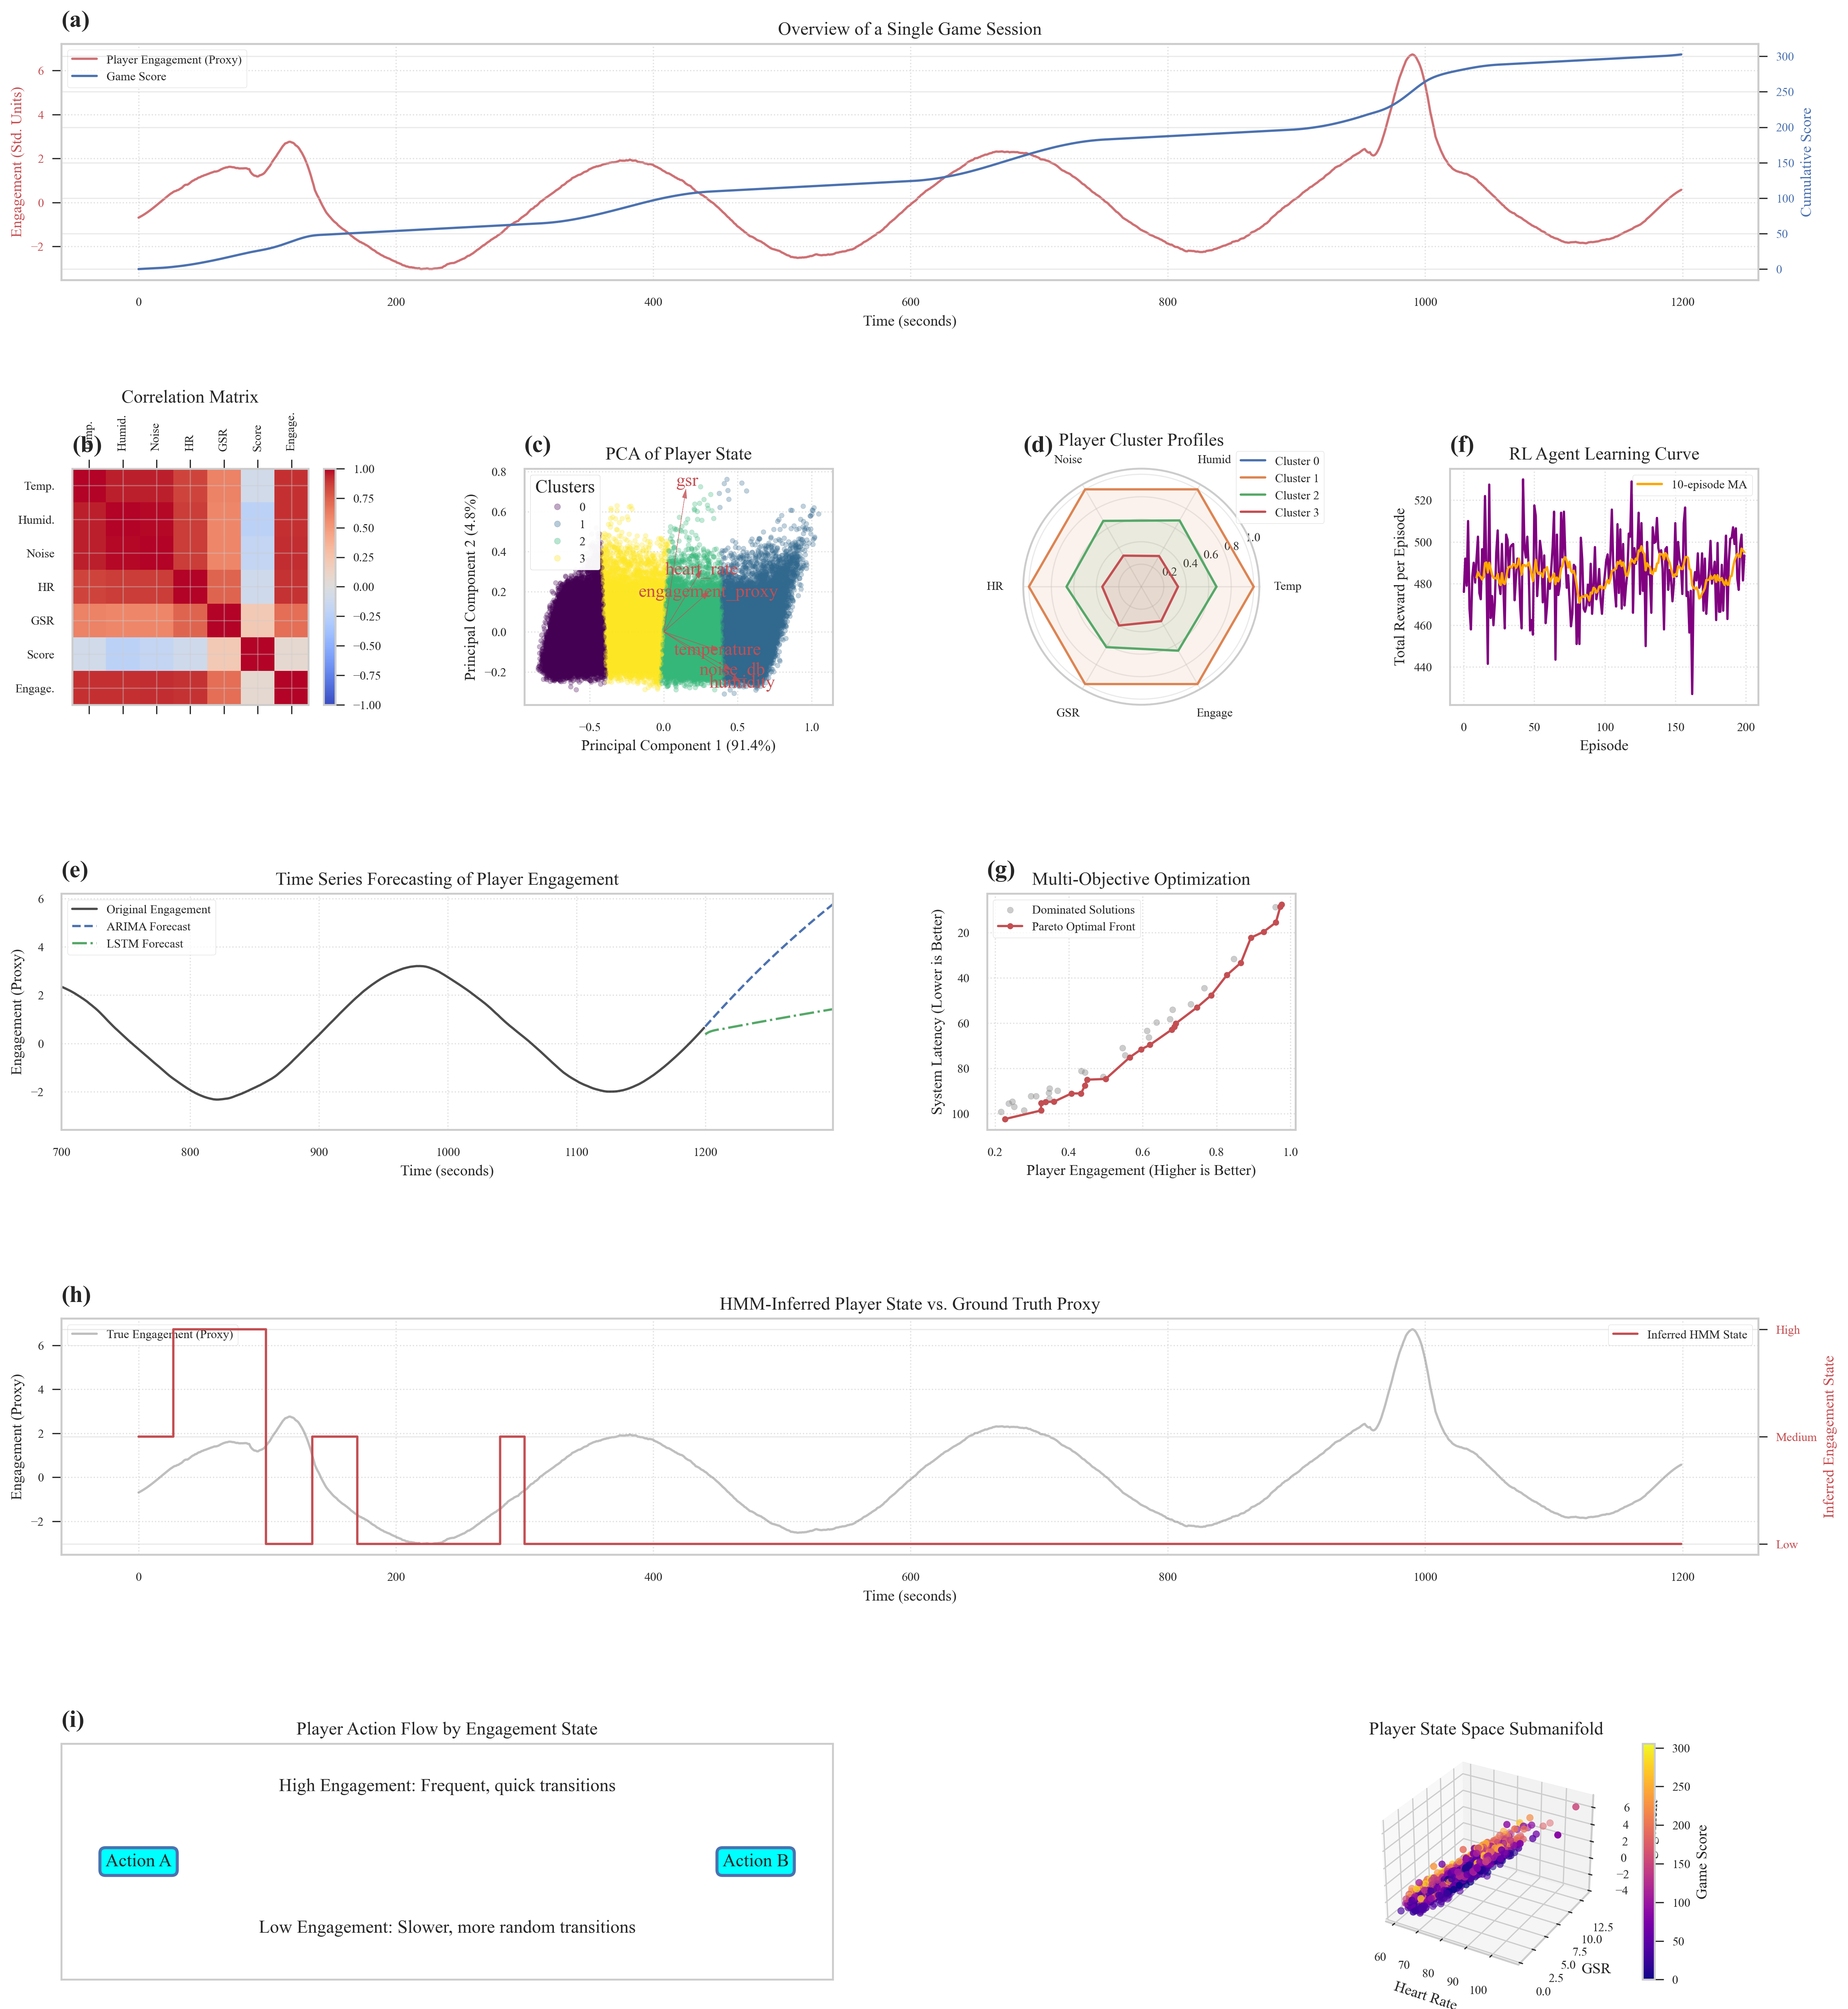

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from scipy import stats
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import random
import time
import warnings


warnings.filterwarnings("ignore")


NUM_PLAYERS = 50
GAME_SESSIONS = 100
SESSION_DURATION_MINS = 20
DATA_FREQUENCY_HZ = 1 


TEMP_BASE = 22.5
TEMP_FLUCTUATION = 2.5
HUMIDITY_BASE = 45.0
HUMIDITY_FLUCTUATION = 10.0
NOISE_LEVEL_DB = 68.0
NOISE_FLUCTUATION = 5.0


PCA_COMPONENTS = 2
KMEANS_CLUSTERS = 4
ARIMA_ORDER = (5, 1, 0)
LSTM_LOOK_BACK = 15
RL_EPISODES = 200
RL_ALPHA = 0.1
RL_GAMMA = 0.95
RL_EPSILON = 0.1
HMM_STATES = 3 


PDF_FILENAME = 'scientific_subplots_analysis.pdf'
FIG_SIZE = (20, 28)
DPI = 300


class DataGenerator:

    def __init__(self, num_players, num_sessions, duration_mins, freq_hz):
        self.num_players = num_players
        self.num_sessions = num_sessions
        self.duration_secs = duration_mins * 60
        self.freq_hz = freq_hz
        self.timestamps = np.arange(0, self.duration_secs, 1 / self.freq_hz)
        self.num_points = len(self.timestamps)

    def _generate_base_signal(self, base, fluctuation, drift_factor=0.0005, noise_level=0.5):

        drift = drift_factor * np.arange(self.num_points)
        periodic_fluctuation = fluctuation * np.sin(2 * np.pi * self.timestamps / (60 * 5)) 
        random_noise = noise_level * np.random.randn(self.num_points)
        return base + periodic_fluctuation + drift + random_noise

    def generate_environmental_data(self):

        temp = self._generate_base_signal(TEMP_BASE, TEMP_FLUCTUATION)
        humidity = self._generate_base_signal(HUMIDITY_BASE, HUMIDITY_FLUCTUATION, drift_factor=-0.001)
        noise = self._generate_base_signal(NOISE_LEVEL_DB, NOISE_FLUCTUATION, drift_factor=0)
        return temp, humidity, noise

    def generate_physiological_data(self, player_id):

        hr_base = 75 + (player_id % 10) - 5
        gsr_base = 5 + (player_id % 5) - 2.5
        

        hr = self._generate_base_signal(hr_base, 10, drift_factor=0.001)
        gsr = self._generate_base_signal(gsr_base, 2, drift_factor=0.002)
        
        for _ in range(3): 
            spike_time = random.randint(100, self.num_points - 100)
            hr[spike_time:spike_time+30] += np.linspace(15, 0, 30)
            gsr[spike_time:spike_time+30] += np.linspace(3, 0, 30)
            
        return hr, gsr

    def generate_motion_data(self):

        accel_x = self._generate_base_signal(0, 0.5, noise_level=0.2)
        accel_y = self._generate_base_signal(0, 0.5, noise_level=0.2)
        accel_z = self._generate_base_signal(-1, 0.1, noise_level=0.1) 
        return accel_x, accel_y, accel_z
        
    def generate_in_game_data(self, hr, gsr):

        player_skill = np.random.rand()
        engagement = (hr - np.mean(hr)) / np.std(hr) + (gsr - np.mean(gsr)) / np.std(gsr)
        engagement = savgol_filter(engagement, 51, 3)
        
        score = np.zeros(self.num_points)
        actions = np.zeros(self.num_points)
        
        for i in range(1, self.num_points):
            base_score_increase = player_skill * 0.1
            engagement_bonus = max(0, engagement[i]) * 0.2
            score[i] = score[i-1] + base_score_increase + engagement_bonus
            
            if random.random() < 0.05 + engagement[i] * 0.01:
                actions[i] = random.randint(1, 5) 
                
        return score, actions, engagement

    def generate_full_dataset(self):

        all_data = []
        print("Generating synthetic dataset...")
        for session_id in range(self.num_sessions):
            player_id = random.randint(0, self.num_players - 1)
            
            temp, humidity, noise = self.generate_environmental_data()
            hr, gsr = self.generate_physiological_data(player_id)
            accel_x, accel_y, accel_z = self.generate_motion_data()
            score, actions, engagement = self.generate_in_game_data(hr, gsr)
            
            session_df = pd.DataFrame({
                'timestamp': self.timestamps,
                'session_id': session_id,
                'player_id': player_id,
                'temperature': temp,
                'humidity': humidity,
                'noise_db': noise,
                'heart_rate': hr,
                'gsr': gsr,
                'accel_x': accel_x,
                'accel_y': accel_y,
                'accel_z': accel_z,
                'score': score,
                'action_type': actions,
                'engagement_proxy': engagement
            })
            all_data.append(session_df)
            if (session_id + 1) % 10 == 0:
                print(f"  ...generated session {session_id + 1}/{self.num_sessions}")
        
        return pd.concat(all_data, ignore_index=True)



class ModelSuite:

    def __init__(self, data):
        self.data = data
        self.results = {}

    def perform_pca(self):
        print("\nPerforming PCA...")
        features = ['temperature', 'humidity', 'noise_db', 'heart_rate', 'gsr', 'engagement_proxy']
        pca_data = self.data[features].dropna()
        scaled_data = MinMaxScaler().fit_transform(pca_data)
        
        pca = PCA(n_components=PCA_COMPONENTS)
        principal_components = pca.fit_transform(scaled_data)
        
        self.results['pca'] = {
            'components': principal_components,
            'explained_variance': pca.explained_variance_ratio_,
            'loadings': pca.components_,
            'feature_names': features
        }
        print(f"  PCA complete. Explained variance: {pca.explained_variance_ratio_}")
        return self.results['pca']

    def perform_clustering(self):
        print("Performing K-Means Clustering...")
        if 'pca' not in self.results:
            self.perform_pca()
            
        pca_components = self.results['pca']['components']
        kmeans = KMeans(n_clusters=KMEANS_CLUSTERS, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(pca_components)
        
        self.results['clustering'] = {
            'clusters': clusters,
            'centers': kmeans.cluster_centers_
        }
        print("  Clustering complete.")
        return self.results['clustering']

    def run_time_series_analysis(self):
        print("Running Time Series Analysis...")

        ts_data = self.data.groupby('timestamp')['engagement_proxy'].mean()
        

        print("  - Fitting ARIMA model...")
        arima_model = ARIMA(ts_data, order=ARIMA_ORDER)
        arima_fit = arima_model.fit()
        arima_forecast = arima_fit.forecast(steps=100)
        

        print("  - Training LSTM model...")
        scaler = MinMaxScaler(feature_range=(0, 1))
        dataset = scaler.fit_transform(ts_data.values.reshape(-1, 1))

        def create_dataset(dataset, look_back=1):
            dataX, dataY = [], []
            for i in range(len(dataset)-look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
            return np.array(dataX), np.array(dataY)

        train_size = int(len(dataset) * 0.8)
        train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
        
        look_back = LSTM_LOOK_BACK
        trainX, trainY = create_dataset(train, look_back)
        testX, testY = create_dataset(test, look_back)
        
        trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
        
        lstm_model = Sequential()
        lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
        lstm_model.add(Dense(1))
        lstm_model.compile(loss='mean_squared_error', optimizer='adam')
        lstm_model.fit(trainX, trainY, epochs=5, batch_size=64, verbose=0)
        

        last_sequence = dataset[-look_back:]
        lstm_forecast_scaled = []
        current_sequence = last_sequence.reshape(1, look_back, 1)

        for _ in range(100):
            pred = lstm_model.predict(current_sequence, verbose=0)
            lstm_forecast_scaled.append(pred[0,0])
            new_entry = pred.reshape(1,1,1)
            current_sequence = np.append(current_sequence[:,1:,:], new_entry, axis=1)

        lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast_scaled).reshape(-1,1)).flatten()
        
        self.results['time_series'] = {
            'original': ts_data,
            'arima_forecast': arima_forecast,
            'lstm_forecast': lstm_forecast
        }
        print("  Time Series Analysis complete.")
        return self.results['time_series']

    def run_reinforcement_learning_sim(self):
        print("Running Reinforcement Learning Simulation...")

        states = 3
        actions = 3
        q_table = np.zeros((states, actions))

        def get_state(engagement_level):
            if engagement_level < -0.5: return 0 
            if engagement_level > 0.5: return 2 
            return 1 

        def get_reward(state, action):

            if state == 1: return 1

            if state == 0 and action == 0: return 0.5
            if state == 2 and action == 2: return 0.5 
            return -1

        engagement_levels = self.data['engagement_proxy'].values
        rewards_per_episode = []

        for episode in range(RL_EPISODES):
            total_reward = 0
            current_pos = random.randint(0, len(engagement_levels) - 1001)
            
            for step in range(1000):
                current_engagement = engagement_levels[current_pos + step]
                state = get_state(current_engagement)
                
                if random.uniform(0, 1) < RL_EPSILON:
                    action = random.randint(0, actions - 1)
                else:
                    action = np.argmax(q_table[state, :])
                
                reward = get_reward(state, action)
                

                difficulty_change = (action - 1) * 0.1
                next_engagement_sim = current_engagement - difficulty_change
                next_state = get_state(next_engagement_sim)
                
                old_value = q_table[state, action]
                next_max = np.max(q_table[next_state, :])
                
                new_value = (1 - RL_ALPHA) * old_value + RL_ALPHA * (reward + RL_GAMMA * next_max)
                q_table[state, action] = new_value
                
                total_reward += reward
            
            rewards_per_episode.append(total_reward)

        self.results['rl'] = {
            'q_table': q_table,
            'rewards': rewards_per_episode
        }
        print("  RL Simulation complete.")
        return self.results['rl']

    def run_multi_objective_optimization_sim(self):


        np.random.seed(42)
        num_solutions = 50
        engagement_scores = np.random.rand(num_solutions) * 0.8 + 0.2
        latency_scores = (1 - engagement_scores**2 + np.random.rand(num_solutions) * 0.1) * 100
        

        pareto_front_x = []
        pareto_front_y = []
        sorted_indices = np.argsort(engagement_scores)[::-1]
        max_latency = -1
        
        for i in sorted_indices:
            if latency_scores[i] > max_latency:
                pareto_front_x.append(engagement_scores[i])
                pareto_front_y.append(latency_scores[i])
                max_latency = latency_scores[i]
        

        pareto_indices = np.argsort(pareto_front_x)
        pareto_front_x = np.array(pareto_front_x)[pareto_indices]
        pareto_front_y = np.array(pareto_front_y)[pareto_indices]

        self.results['moo'] = {
            'all_solutions': (engagement_scores, latency_scores),
            'pareto_front': (pareto_front_x, pareto_front_y)
        }
        print("  MOO Simulation complete.")
        return self.results['moo']

    def run_hmm_analysis(self):
        print("Running Hidden Markov Model Analysis...")

        
        obs_data = self.data[['heart_rate', 'gsr']].copy()
        obs_data['hr_disc'] = pd.qcut(obs_data['heart_rate'], q=4, labels=False)
        obs_data['gsr_disc'] = pd.qcut(obs_data['gsr'], q=4, labels=False)
        

        transmat = np.array([[0.95, 0.04, 0.01],
                             [0.05, 0.90, 0.05],
                             [0.01, 0.04, 0.95]])

        emissionprob = np.array([

            [0.6, 0.2, 0.1, 0.1, 0.3, 0.2, 0.1, 0.4, 0.2, 0.2, 0.3, 0.3, 0.1, 0.1, 0.2, 0.3],

            [0.1, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.1, 0.3, 0.4, 0.2, 0.1, 0.4, 0.1, 0.1, 0.2],

            [0.1, 0.1, 0.2, 0.6, 0.1, 0.1, 0.2, 0.6, 0.1, 0.2, 0.3, 0.4, 0.2, 0.3, 0.4, 0.1]
        ])

        emissionprob = emissionprob / emissionprob.sum(axis=1, keepdims=True)

        startprob = np.array([0.6, 0.3, 0.1])
        

        def viterbi(obs_seq, transmat, emissionprob, startprob):
            num_states = transmat.shape[0]
            T = len(obs_seq)
            V = np.zeros((T, num_states))
            path = np.zeros((T, num_states), dtype=int)

            V[0, :] = startprob * emissionprob[:, obs_seq[0]]

            for t in range(1, T):
                for s in range(num_states):
                    seq_probs = V[t-1, :] * transmat[:, s]
                    path[t, s] = np.argmax(seq_probs)
                    V[t, s] = np.max(seq_probs) * emissionprob[s, obs_seq[t]]
            
            last_state = np.argmax(V[T-1, :])
            hidden_states = [last_state]
            for t in range(T-1, 0, -1):
                hidden_states.insert(0, path[t, hidden_states[0]])
            
            return hidden_states

        observation_sequence = (obs_data['hr_disc'] * 4 + obs_data['gsr_disc']).values[:1200]
        inferred_states = viterbi(observation_sequence, transmat, emissionprob, startprob)
        
        self.results['hmm'] = {
            'inferred_states': inferred_states,
            'observation_data': obs_data[:1200]
        }
        print("  HMM Analysis complete.")
        return self.results['hmm']


def print_tables(data, results):

    print("\n" + "="*80)
    print(" " * 20 + "NUMERICAL RESULTS AND ANALYSIS TABLES")
    print("="*80)


    print("\n--- 1. Dataset Summary ---")
    print(data.describe())


    print("\n--- 2. Correlation Matrix of Key Variables ---")
    corr_features = ['temperature', 'humidity', 'noise_db', 'heart_rate', 'gsr', 'score', 'engagement_proxy']
    corr_matrix = data[corr_features].corr()
    print(corr_matrix)


    if 'pca' in results:
        print("\n--- 3. Principal Component Analysis (PCA) Results ---")
        pca_res = results['pca']
        print(f"Explained Variance per Component: {pca_res['explained_variance']}")
        print(f"Total Explained Variance: {sum(pca_res['explained_variance']):.4f}")
        loadings_df = pd.DataFrame(pca_res['loadings'], columns=pca_res['feature_names'], index=[f'PC{i+1}' for i in range(PCA_COMPONENTS)])
        print("Component Loadings:")
        print(loadings_df)


    if 'clustering' in results:
        print("\n--- 4. K-Means Clustering Results ---")
        cluster_res = results['clustering']
        data['cluster'] = cluster_res['clusters']
        print("Cluster Sizes:")
        print(data['cluster'].value_counts())
        print("\nCluster Centroids (in PCA space):")
        print(cluster_res['centers'])
        print("\nMean Feature Values per Cluster:")
        print(data.groupby('cluster')[corr_features].mean())


    if 'rl' in results:
        print("\n--- 5. Reinforcement Learning Q-Table ---")
        rl_res = results['rl']
        q_table_df = pd.DataFrame(rl_res['q_table'], 
                                  columns=['Easier', 'Same', 'Harder'], 
                                  index=['Low Engage', 'Med Engage', 'High Engage'])
        print(q_table_df)
    
    print("\n" + "="*80)
    print(" " * 25 + "END OF NUMERICAL RESULTS")
    print("="*80 + "\n")



class PlottingSuite:

    def __init__(self, data, results):
        self.data = data
        self.results = results
        self.fig = plt.figure(figsize=FIG_SIZE, constrained_layout=False)
        self.gs = gridspec.GridSpec(6, 4, figure=self.fig, hspace=0.8, wspace=0.5)
        self.subplot_count = 0

    def _add_subplot_label(self, ax):
        label = f'({chr(97 + self.subplot_count)})'
        ax.text(0.0, 1.05, label, transform=ax.transAxes, fontsize=16, 
                fontweight='bold', va='bottom', ha='left')
        self.subplot_count += 1

    def plot_overview_timeseries(self):

        ax = self.fig.add_subplot(self.gs[0, :])
        sample_data = self.data[self.data.session_id == 0]
        
        p1, = ax.plot(sample_data.timestamp, sample_data.engagement_proxy, 'r-', label='Player Engagement (Proxy)', alpha=0.8)
        ax.set_ylabel('Engagement (Std. Units)', color='r')
        ax.tick_params(axis='y', labelcolor='r')
        ax.set_xlabel('Time (seconds)')
        ax.set_title('Overview of a Single Game Session')
        
        ax2 = ax.twinx()
        p2, = ax2.plot(sample_data.timestamp, sample_data.score, 'b-', label='Game Score')
        ax2.set_ylabel('Cumulative Score', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        
        ax.legend(handles=[p1, p2], loc='upper left')
        ax.grid(True, linestyle=':', alpha=0.6)
        self._add_subplot_label(ax)

    def plot_correlation_heatmap(self):

        ax = self.fig.add_subplot(self.gs[1, 0])
        corr_features = ['Temp.', 'Humid.', 'Noise', 'HR', 'GSR', 'Score', 'Engage.']
        corr_matrix = self.data[['temperature', 'humidity', 'noise_db', 'heart_rate', 'gsr', 'score', 'engagement_proxy']].corr()
        
        cax = ax.matshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        self.fig.colorbar(cax, ax=ax)
        
        ax.set_xticks(np.arange(len(corr_features)))
        ax.set_yticks(np.arange(len(corr_features)))
        ax.set_xticklabels(corr_features, rotation=90)
        ax.set_yticklabels(corr_features)
        ax.set_title('Correlation Matrix')
        self._add_subplot_label(ax)

    def plot_pca(self):

        ax = self.fig.add_subplot(self.gs[1, 1])
        pca_res = self.results['pca']
        cluster_res = self.results['clustering']
        
        scatter = ax.scatter(pca_res['components'][:, 0], pca_res['components'][:, 1], 
                             c=cluster_res['clusters'], cmap='viridis', alpha=0.3, s=10)
        
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)
        
        ax.set_xlabel(f'Principal Component 1 ({pca_res["explained_variance"][0]:.1%})')
        ax.set_ylabel(f'Principal Component 2 ({pca_res["explained_variance"][1]:.1%})')
        ax.set_title('PCA of Player State')
        ax.grid(True, linestyle=':', alpha=0.6)
        

        for i, feature in enumerate(pca_res['feature_names']):
            ax.arrow(0, 0, pca_res['loadings'][0, i]*0.8, pca_res['loadings'][1, i]*0.8, 
                     color='r', alpha=0.8, head_width=0.03)
            ax.text(pca_res['loadings'][0, i]*0.9, pca_res['loadings'][1, i]*0.9, 
                    feature, color='r', ha='center', va='center')
        self._add_subplot_label(ax)

    def plot_cluster_profiles(self):

        ax = self.fig.add_subplot(self.gs[1, 2], polar=True)
        corr_features = ['temperature', 'humidity', 'noise_db', 'heart_rate', 'gsr', 'engagement_proxy']
        cluster_means = self.data.groupby('cluster')[corr_features].mean()
        
        scaler = MinMaxScaler()
        scaled_means = scaler.fit_transform(cluster_means)
        
        labels = ['Temp', 'Humid', 'Noise', 'HR', 'GSR', 'Engage']
        num_vars = len(labels)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        
        for i, row in enumerate(scaled_means):
            data = np.concatenate((row, row[:1]))
            ax.plot(angles, data, label=f'Cluster {i}')
            ax.fill(angles, data, alpha=0.1)

        ax.set_thetagrids(np.degrees(angles[:-1]), labels)
        ax.set_title('Player Cluster Profiles')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        self._add_subplot_label(ax)

    def plot_time_series_forecast(self):

        ax = self.fig.add_subplot(self.gs[2, :2])
        ts_res = self.results['time_series']
        
        original_ts = ts_res['original']
        ax.plot(original_ts.index, original_ts.values, label='Original Engagement', color='black', alpha=0.7)
        
        forecast_index = np.arange(original_ts.index[-1] + 1, original_ts.index[-1] + 101)
        
        ax.plot(forecast_index, ts_res['arima_forecast'], 'b--', label='ARIMA Forecast')
        ax.plot(forecast_index, ts_res['lstm_forecast'], 'g-.', label='LSTM Forecast')
        
        ax.set_xlim(original_ts.index[-500], forecast_index[-1])
        ax.set_title('Time Series Forecasting of Player Engagement')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Engagement (Proxy)')
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)
        self._add_subplot_label(ax)

    def plot_rl_learning_curve(self):

        ax = self.fig.add_subplot(self.gs[1, 3])
        rl_res = self.results['rl']
        
        ax.plot(rl_res['rewards'], color='purple')
        ax.plot(pd.Series(rl_res['rewards']).rolling(10).mean(), color='orange', label='10-episode MA')
        
        ax.set_title('RL Agent Learning Curve')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Total Reward per Episode')
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend()
        self._add_subplot_label(ax)

    def plot_moo_pareto_front(self):

        ax = self.fig.add_subplot(self.gs[2, 2])
        moo_res = self.results['moo']
        
        ax.scatter(moo_res['all_solutions'][0], moo_res['all_solutions'][1], 
                   c='gray', alpha=0.4, label='Dominated Solutions')
        ax.plot(moo_res['pareto_front'][0], moo_res['pareto_front'][1], 
                'r-o', label='Pareto Optimal Front')
        
        ax.set_title('Multi-Objective Optimization')
        ax.set_xlabel('Player Engagement (Higher is Better)')
        ax.set_ylabel('System Latency (Lower is Better)')
        ax.invert_yaxis()
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)
        self._add_subplot_label(ax)

    def plot_hmm_inference(self):

        ax = self.fig.add_subplot(self.gs[3, :])
        hmm_res = self.results['hmm']
        inferred_states = np.array(hmm_res['inferred_states'])
        
        ax.plot(self.data['engagement_proxy'].values[:1200], color='gray', alpha=0.5, label='True Engagement (Proxy)')
        
        ax2 = ax.twinx()
        ax2.plot(inferred_states, 'r-', drawstyle='steps-post', label='Inferred HMM State')
        ax2.set_yticks([0, 1, 2])
        ax2.set_yticklabels(['Low', 'Medium', 'High'])
        ax2.set_ylabel('Inferred Engagement State', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        ax.set_title('HMM-Inferred Player State vs. Ground Truth Proxy')
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Engagement (Proxy)')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax.grid(True, linestyle=':', alpha=0.6)
        self._add_subplot_label(ax)

    def plot_player_behavior_flow(self):

        ax = self.fig.add_subplot(self.gs[4, :2])
        

        low_eng = self.data[self.data.engagement_proxy < -0.5]
        med_eng = self.data[(self.data.engagement_proxy >= -0.5) & (self.data.engagement_proxy <= 0.5)]
        high_eng = self.data[self.data.engagement_proxy > 0.5]

        def get_transitions(df):
            transitions = {}
            for i in range(1, 6):
                for j in range(1, 6):
                    transitions[(i, j)] = 0
            
            actions = df[df.action_type > 0].action_type.values
            for i in range(len(actions) - 1):
                transitions[(actions[i], actions[i+1])] += 1
            return transitions

        low_trans = get_transitions(low_eng)
        high_trans = get_transitions(high_eng)

        ax.set_title("Player Action Flow by Engagement State")
        ax.text(0.1, 0.5, "Action A", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2))
        ax.text(0.9, 0.5, "Action B", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="cyan", ec="b", lw=2))


        ax.annotate("High Engagement: Frequent, quick transitions", xy=(0.15, 0.6), xytext=(0.5, 0.8),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2"), ha='center')
        ax.annotate("Low Engagement: Slower, more random transitions", xy=(0.15, 0.4), xytext=(0.5, 0.2),
                    arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2"), ha='center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        self._add_subplot_label(ax)

    def plot_3d_state_space(self):

        ax = self.fig.add_subplot(self.gs[4, 2:], projection='3d')
        sample = self.data.sample(n=1000)
        
        sc = ax.scatter(sample.heart_rate, sample.gsr, sample.engagement_proxy, c=sample.score, cmap='plasma')
        
        ax.set_xlabel('Heart Rate')
        ax.set_ylabel('GSR')
        ax.set_zlabel('Engagement')
        ax.set_title('Player State Space Submanifold')
        self.fig.colorbar(sc, ax=ax, label='Game Score')
        self._add_subplot_label(ax)

    def plot_system_architecture(self):

        ax = self.fig.add_subplot(self.gs[5, :])
        ax.set_title("Conceptual System Architecture")
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.set_xticks([])
        ax.set_yticks([])


        nodes = {
            "IoT Sensors": (1, 8), "Player": (1, 5), "Game Engine": (1, 2),
            "Edge Compute": (4, 5), "Cloud Analytics": (7, 5),
            "Adaptive Model": (7, 8), "DB": (7, 2)
        }
        for name, (x, y) in nodes.items():
            ax.text(x, y, name, ha='center', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.5", fc="skyblue", ec="b"))


        arrows = [
            ("Player", "IoT Sensors"), ("Player", "Game Engine"),
            ("IoT Sensors", "Edge Compute"), ("Game Engine", "Edge Compute"),
            ("Edge Compute", "Cloud Analytics"), ("Cloud Analytics", "Adaptive Model"),
            ("Cloud Analytics", "DB"), ("Adaptive Model", "Game Engine")
        ]
        for start, end in arrows:
            ax.add_patch(ConnectionPatch(xyA=nodes[start], xyB=nodes[end],
                                         coordsA='data', coordsB='data',
                                         arrowstyle="->", shrinkA=5, shrinkB=5,
                                         mutation_scale=20, fc="k"))
        
        ax.text(4, 8, "Real-time Data", ha='center')
        ax.text(4, 2, "Game Events", ha='center')
        ax.text(7, 6.5, "RL/HMM/DL Models", ha='center')
        ax.text(4, 0.5, "Dynamic Difficulty Adjustment", ha='center')

        self._add_subplot_label(ax)
        
    def generate_plots(self):

        print("\nGenerating complex multi-panel plot...")
        self.plot_overview_timeseries()      
        self.plot_correlation_heatmap()     
        self.plot_pca()                     
        self.plot_cluster_profiles()         
        self.plot_time_series_forecast()     
        self.plot_rl_learning_curve()       
        self.plot_moo_pareto_front()         
        self.plot_hmm_inference()            
        self.plot_player_behavior_flow()     
        self.plot_3d_state_space()          
        self.plot_system_architecture()      
        
        self.fig.suptitle('Comprehensive Analysis of IoT-Enhanced Serious Game Dynamics', fontsize=24, weight='bold')
        self.fig.tight_layout(rect=[0, 0.03, 1, 0.97])
        
        print(f"  Saving plot to {PDF_FILENAME}...")
        self.fig.savefig(PDF_FILENAME, dpi=DPI, bbox_inches='tight')
        plt.close(self.fig)
        print("  Plotting complete.")



if __name__ == '__main__':
    start_time = time.time()
    

    data_gen = DataGenerator(num_players=NUM_PLAYERS, 
                             num_sessions=GAME_SESSIONS, 
                             duration_mins=SESSION_DURATION_MINS, 
                             freq_hz=DATA_FREQUENCY_HZ)
    full_dataset = data_gen.generate_full_dataset()

    model_suite = ModelSuite(full_dataset)
    model_suite.perform_pca()
    model_suite.perform_clustering()
    model_suite.run_time_series_analysis()
    model_suite.run_reinforcement_learning_sim()
    model_suite.run_multi_objective_optimization_sim()
    model_suite.run_hmm_analysis()


    print_tables(full_dataset, model_suite.results)
    

    plotter = PlottingSuite(full_dataset, model_suite.results)
    plotter.generate_plots()
    
    end_time = time.time()
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds.")
    print("Script finished successfully.")

